## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (145, 145)
Hypercube shape: (145, 145, 200)


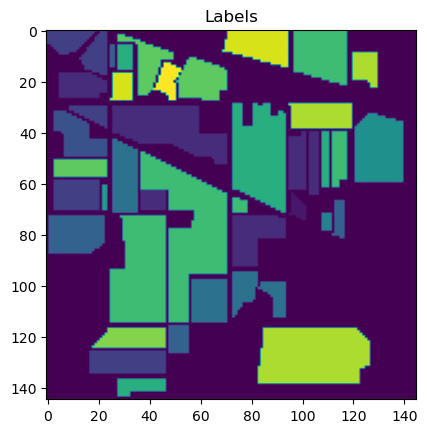

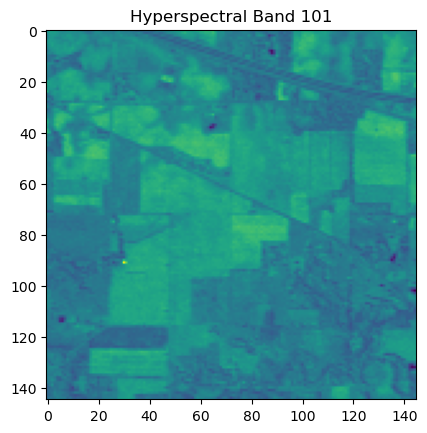

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Indian_pines_gt.mat'
data_files = 'Indian_pines_corrected.mat'
label_files = 'indian_pines_gt'
hypercube_files = 'indian_pines_corrected'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 10249
Extracted windows shape: (10249, 5, 5, 200)
Corresponding labels shape: (10249,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 46 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 1428 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 830 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 237 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 483 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 730 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 28 samples
Shuffled class indices for class '7'
Se


All datasets saved to the 'indices' folder.
(80, 5, 5, 200)
(80, 5, 5, 200)
(10089, 5, 5, 200)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 80
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (8199, 5, 5, 200)
Validation data shape: (2050, 5, 5, 200)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

200


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/129], Loss: 0.0772, PSNR: 10.7492


Epoch [1/50] Training Loss: 0.0648, PSNR: 11.4637
	[Val]   Batch [1/33] Loss: 0.0495, PSNR: 12.7165
	[Val]   Batch [10/33] Loss: 0.0489, PSNR: 12.3687
	[Val]   Batch [20/33] Loss: 0.0486, PSNR: 11.9640
	[Val]   Batch [30/33] Loss: 0.0474, PSNR: 12.3203
Epoch [1/50] Validation Loss: 0.0492, PSNR: 12.5332

LOG: Epoch [2/50]
	 Training Batch [1/129], Loss: 0.0502, PSNR: 12.0508


Epoch [2/50] Training Loss: 0.0399, PSNR: 13.5458
	[Val]   Batch [1/33] Loss: 0.0290, PSNR: 15.0470
	[Val]   Batch [10/33] Loss: 0.0285, PSNR: 14.7226
	[Val]   Batch [20/33] Loss: 0.0282, PSNR: 14.3309
	[Val]   Batch [30/33] Loss: 0.0275, PSNR: 14.6783
Epoch [2/50] Validation Loss: 0.0288, PSNR: 14.8589

LOG: Epoch [3/50]
	 Training Batch [1/129], Loss: 0.0284, PSNR: 14.7328


Epoch [3/50] Training Loss: 0.0233, PSNR: 15.8891
	[Val]   Batch [1/33] Loss: 0.0175, PSNR: 17.2454
	[Val]   Batch [10/33] Loss: 0.0170, PSNR: 16.9539
	[Val]   Batch [20/33] Loss: 0.0167, PSNR: 16.5930
	[Val]   Batch [30/33] Loss: 0.0163, PSNR: 16.9637
Epoch [3/50] Validation Loss: 0.0174, PSNR: 17.0536

LOG: Epoch [4/50]
	 Training Batch [1/129], Loss: 0.0174, PSNR: 17.2314


Epoch [4/50] Training Loss: 0.0142, PSNR: 18.0359
	[Val]   Batch [1/33] Loss: 0.0116, PSNR: 19.0341
	[Val]   Batch [10/33] Loss: 0.0111, PSNR: 18.7977
	[Val]   Batch [20/33] Loss: 0.0109, PSNR: 18.4747
	[Val]   Batch [30/33] Loss: 0.0105, PSNR: 18.8540
Epoch [4/50] Validation Loss: 0.0115, PSNR: 18.8438

LOG: Epoch [5/50]
	 Training Batch [1/129], Loss: 0.0112, PSNR: 19.1411


Epoch [5/50] Training Loss: 0.0095, PSNR: 19.7691
	[Val]   Batch [1/33] Loss: 0.0083, PSNR: 20.4700
	[Val]   Batch [10/33] Loss: 0.0079, PSNR: 20.2978
	[Val]   Batch [20/33] Loss: 0.0076, PSNR: 20.0106
	[Val]   Batch [30/33] Loss: 0.0074, PSNR: 20.3822
Epoch [5/50] Validation Loss: 0.0083, PSNR: 20.2792

LOG: Epoch [6/50]
	 Training Batch [1/129], Loss: 0.0078, PSNR: 21.0851


Epoch [6/50] Training Loss: 0.0071, PSNR: 21.0574
	[Val]   Batch [1/33] Loss: 0.0064, PSNR: 21.6072
	[Val]   Batch [10/33] Loss: 0.0060, PSNR: 21.5030
	[Val]   Batch [20/33] Loss: 0.0057, PSNR: 21.2608
	[Val]   Batch [30/33] Loss: 0.0055, PSNR: 21.6376
Epoch [6/50] Validation Loss: 0.0064, PSNR: 21.4183

LOG: Epoch [7/50]
	 Training Batch [1/129], Loss: 0.0071, PSNR: 21.2815


Epoch [7/50] Training Loss: 0.0056, PSNR: 22.0577
	[Val]   Batch [1/33] Loss: 0.0052, PSNR: 22.5273
	[Val]   Batch [10/33] Loss: 0.0048, PSNR: 22.4882
	[Val]   Batch [20/33] Loss: 0.0045, PSNR: 22.2848
	[Val]   Batch [30/33] Loss: 0.0044, PSNR: 22.6597
Epoch [7/50] Validation Loss: 0.0052, PSNR: 22.3388

LOG: Epoch [8/50]
	 Training Batch [1/129], Loss: 0.0052, PSNR: 22.6177


Epoch [8/50] Training Loss: 0.0047, PSNR: 22.8528
	[Val]   Batch [1/33] Loss: 0.0044, PSNR: 23.2633
	[Val]   Batch [10/33] Loss: 0.0040, PSNR: 23.2847
	[Val]   Batch [20/33] Loss: 0.0037, PSNR: 23.1207
	[Val]   Batch [30/33] Loss: 0.0036, PSNR: 23.5127
Epoch [8/50] Validation Loss: 0.0044, PSNR: 23.0818

LOG: Epoch [9/50]
	 Training Batch [1/129], Loss: 0.0039, PSNR: 23.2505


Epoch [9/50] Training Loss: 0.0041, PSNR: 23.4662
	[Val]   Batch [1/33] Loss: 0.0037, PSNR: 23.9251
	[Val]   Batch [10/33] Loss: 0.0034, PSNR: 24.0151
	[Val]   Batch [20/33] Loss: 0.0031, PSNR: 23.8787
	[Val]   Batch [30/33] Loss: 0.0030, PSNR: 24.2660
Epoch [9/50] Validation Loss: 0.0038, PSNR: 23.7510

LOG: Epoch [10/50]
	 Training Batch [1/129], Loss: 0.0040, PSNR: 24.0339


Epoch [10/50] Training Loss: 0.0036, PSNR: 24.0224
	[Val]   Batch [1/33] Loss: 0.0034, PSNR: 24.3967
	[Val]   Batch [10/33] Loss: 0.0030, PSNR: 24.5578
	[Val]   Batch [20/33] Loss: 0.0027, PSNR: 24.4503
	[Val]   Batch [30/33] Loss: 0.0026, PSNR: 24.8952
Epoch [10/50] Validation Loss: 0.0033, PSNR: 24.2588

LOG: Epoch [11/50]
	 Training Batch [1/129], Loss: 0.0038, PSNR: 24.2126


Epoch [11/50] Training Loss: 0.0032, PSNR: 24.5636
	[Val]   Batch [1/33] Loss: 0.0029, PSNR: 24.9912
	[Val]   Batch [10/33] Loss: 0.0025, PSNR: 25.2295
	[Val]   Batch [20/33] Loss: 0.0023, PSNR: 25.1323
	[Val]   Batch [30/33] Loss: 0.0022, PSNR: 25.6105
Epoch [11/50] Validation Loss: 0.0029, PSNR: 24.8834

LOG: Epoch [12/50]
	 Training Batch [1/129], Loss: 0.0026, PSNR: 25.4524


Epoch [12/50] Training Loss: 0.0028, PSNR: 25.0965
	[Val]   Batch [1/33] Loss: 0.0026, PSNR: 25.5106
	[Val]   Batch [10/33] Loss: 0.0022, PSNR: 25.8089
	[Val]   Batch [20/33] Loss: 0.0020, PSNR: 25.7399
	[Val]   Batch [30/33] Loss: 0.0019, PSNR: 26.2628
Epoch [12/50] Validation Loss: 0.0026, PSNR: 25.4380

LOG: Epoch [13/50]
	 Training Batch [1/129], Loss: 0.0022, PSNR: 25.6287


Epoch [13/50] Training Loss: 0.0026, PSNR: 25.5232
	[Val]   Batch [1/33] Loss: 0.0024, PSNR: 25.9091
	[Val]   Batch [10/33] Loss: 0.0020, PSNR: 26.2335
	[Val]   Batch [20/33] Loss: 0.0018, PSNR: 26.1725
	[Val]   Batch [30/33] Loss: 0.0017, PSNR: 26.7467
Epoch [13/50] Validation Loss: 0.0023, PSNR: 25.8674

LOG: Epoch [14/50]
	 Training Batch [1/129], Loss: 0.0023, PSNR: 25.8069


Epoch [14/50] Training Loss: 0.0023, PSNR: 25.9940
	[Val]   Batch [1/33] Loss: 0.0021, PSNR: 26.3754
	[Val]   Batch [10/33] Loss: 0.0018, PSNR: 26.6943
	[Val]   Batch [20/33] Loss: 0.0017, PSNR: 26.6379
	[Val]   Batch [30/33] Loss: 0.0015, PSNR: 27.2318
Epoch [14/50] Validation Loss: 0.0021, PSNR: 26.3307

LOG: Epoch [15/50]
	 Training Batch [1/129], Loss: 0.0024, PSNR: 25.7720


Epoch [15/50] Training Loss: 0.0021, PSNR: 26.4000
	[Val]   Batch [1/33] Loss: 0.0019, PSNR: 26.9269
	[Val]   Batch [10/33] Loss: 0.0016, PSNR: 27.2508
	[Val]   Batch [20/33] Loss: 0.0015, PSNR: 27.1961
	[Val]   Batch [30/33] Loss: 0.0013, PSNR: 27.7870
Epoch [15/50] Validation Loss: 0.0018, PSNR: 26.8763

LOG: Epoch [16/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.1503


Epoch [16/50] Training Loss: 0.0019, PSNR: 26.7956
	[Val]   Batch [1/33] Loss: 0.0017, PSNR: 27.4053
	[Val]   Batch [10/33] Loss: 0.0014, PSNR: 27.6880
	[Val]   Batch [20/33] Loss: 0.0013, PSNR: 27.6503
	[Val]   Batch [30/33] Loss: 0.0012, PSNR: 28.2680
Epoch [16/50] Validation Loss: 0.0017, PSNR: 27.3412

LOG: Epoch [17/50]
	 Training Batch [1/129], Loss: 0.0017, PSNR: 27.0084


Epoch [17/50] Training Loss: 0.0017, PSNR: 27.1345
	[Val]   Batch [1/33] Loss: 0.0015, PSNR: 27.7827
	[Val]   Batch [10/33] Loss: 0.0013, PSNR: 28.0407
	[Val]   Batch [20/33] Loss: 0.0012, PSNR: 28.0422
	[Val]   Batch [30/33] Loss: 0.0011, PSNR: 28.6332
Epoch [17/50] Validation Loss: 0.0015, PSNR: 27.7292

LOG: Epoch [18/50]
	 Training Batch [1/129], Loss: 0.0020, PSNR: 26.5807


Epoch [18/50] Training Loss: 0.0016, PSNR: 27.4998
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2855
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.5527
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.5697
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.1864
Epoch [18/50] Validation Loss: 0.0013, PSNR: 28.2413

LOG: Epoch [19/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 27.0981


Epoch [19/50] Training Loss: 0.0015, PSNR: 27.8113
	[Val]   Batch [1/33] Loss: 0.0014, PSNR: 28.2943
	[Val]   Batch [10/33] Loss: 0.0012, PSNR: 28.4315
	[Val]   Batch [20/33] Loss: 0.0011, PSNR: 28.4590
	[Val]   Batch [30/33] Loss: 0.0010, PSNR: 29.1640
Epoch [19/50] Validation Loss: 0.0013, PSNR: 28.2305

LOG: Epoch [20/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.5227


Epoch [20/50] Training Loss: 0.0014, PSNR: 28.1563
	[Val]   Batch [1/33] Loss: 0.0012, PSNR: 29.0283
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.1700
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.2296
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 29.8639
Epoch [20/50] Validation Loss: 0.0011, PSNR: 28.9452

LOG: Epoch [21/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.6756


Epoch [21/50] Training Loss: 0.0013, PSNR: 28.4045
	[Val]   Batch [1/33] Loss: 0.0011, PSNR: 29.2312
	[Val]   Batch [10/33] Loss: 0.0010, PSNR: 29.3811
	[Val]   Batch [20/33] Loss: 0.0009, PSNR: 29.4689
	[Val]   Batch [30/33] Loss: 0.0008, PSNR: 30.1041
Epoch [21/50] Validation Loss: 0.0011, PSNR: 29.1586

LOG: Epoch [22/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.1690


Epoch [22/50] Training Loss: 0.0012, PSNR: 28.5930
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.6847
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.7881
	[Val]   Batch [20/33] Loss: 0.0008, PSNR: 29.9387
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.5903
Epoch [22/50] Validation Loss: 0.0010, PSNR: 29.6165

LOG: Epoch [23/50]
	 Training Batch [1/129], Loss: 0.0010, PSNR: 29.6607


Epoch [23/50] Training Loss: 0.0012, PSNR: 28.8600
	[Val]   Batch [1/33] Loss: 0.0010, PSNR: 29.8704
	[Val]   Batch [10/33] Loss: 0.0009, PSNR: 29.9535
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.1471
	[Val]   Batch [30/33] Loss: 0.0007, PSNR: 30.8381
Epoch [23/50] Validation Loss: 0.0009, PSNR: 29.8217

LOG: Epoch [24/50]
	 Training Batch [1/129], Loss: 0.0018, PSNR: 27.1740


Epoch [24/50] Training Loss: 0.0011, PSNR: 29.0752
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.0908
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.1696
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.3831
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.0873
Epoch [24/50] Validation Loss: 0.0009, PSNR: 30.0577

LOG: Epoch [25/50]
	 Training Batch [1/129], Loss: 0.0013, PSNR: 28.5918


Epoch [25/50] Training Loss: 0.0011, PSNR: 29.2099
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3526
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4408
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6811
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.3480
Epoch [25/50] Validation Loss: 0.0008, PSNR: 30.3271

LOG: Epoch [26/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.9986


Epoch [26/50] Training Loss: 0.0010, PSNR: 29.3786
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.5229
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.6059
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 30.8472
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.5767
Epoch [26/50] Validation Loss: 0.0008, PSNR: 30.5065

LOG: Epoch [27/50]
	 Training Batch [1/129], Loss: 0.0009, PSNR: 29.8809


Epoch [27/50] Training Loss: 0.0010, PSNR: 29.4525
	[Val]   Batch [1/33] Loss: 0.0009, PSNR: 30.3499
	[Val]   Batch [10/33] Loss: 0.0008, PSNR: 30.4281
	[Val]   Batch [20/33] Loss: 0.0007, PSNR: 30.6688
	[Val]   Batch [30/33] Loss: 0.0006, PSNR: 31.4238
Epoch [27/50] Validation Loss: 0.0008, PSNR: 30.3418

LOG: Epoch [28/50]
	 Training Batch [1/129], Loss: 0.0012, PSNR: 28.8128


Epoch [28/50] Training Loss: 0.0010, PSNR: 29.6751
	[Val]   Batch [1/33] Loss: 0.0008, PSNR: 30.7132
	[Val]   Batch [10/33] Loss: 0.0007, PSNR: 30.7906
	[Val]   Batch [20/33] Loss: 0.0006, PSNR: 31.0274
	[Val]   Batch [30/33] Loss: 0.0005, PSNR: 31.7772
Epoch [28/50] Validation Loss: 0.0008, PSNR: 30.6915
Early stopping triggered at epoch 28. No improvement for 3 epochs.


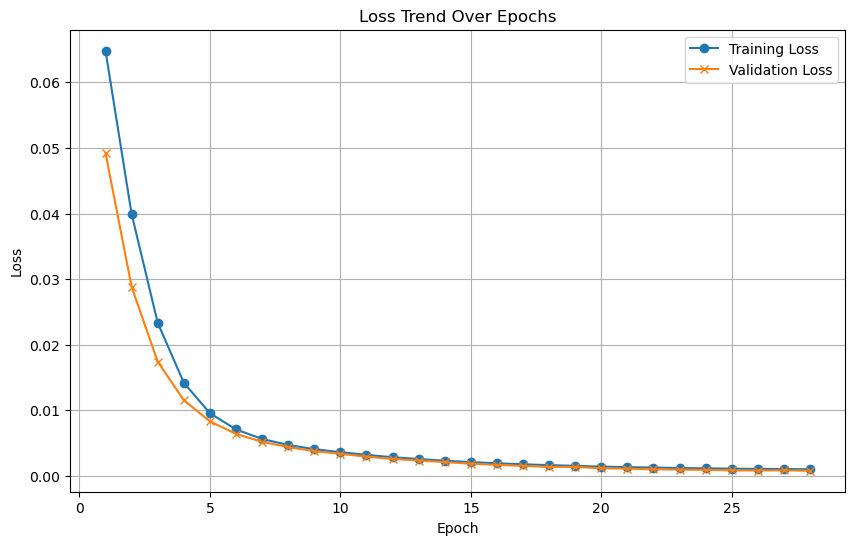

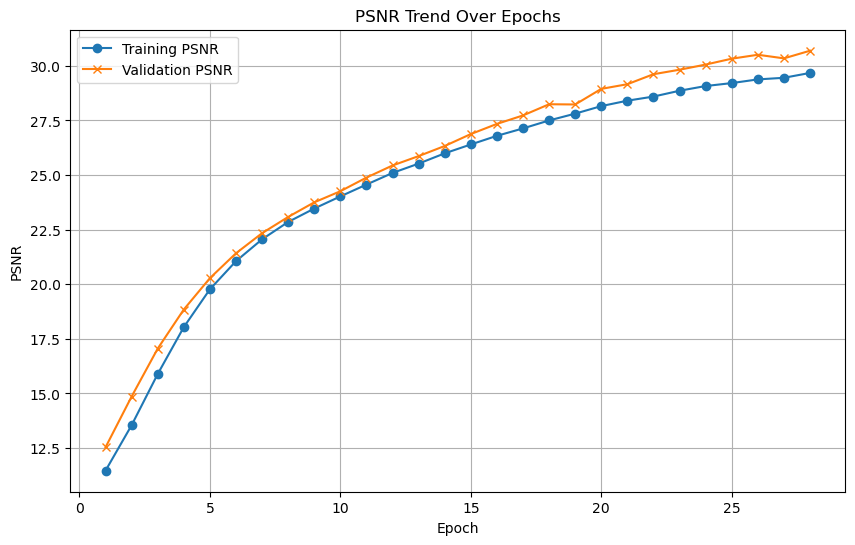

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/40 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.7809
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss improved from inf to 2.7782. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.7486
    Validation Batch [1/1], Loss: 2.7781
Validation Loss: 2.7781, Validation Accuracy: 6.25%
Validation loss improved from 2.7782 to 2.7781. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.7407
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.7092
    Validation Batch [1/1], Loss: 2.7782
Validation Loss: 2.7782, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] comple

Epoch [10/1000] completed, Average Training Loss: 2.6377
    Validation Batch [1/1], Loss: 2.7781
Validation Loss: 2.7781, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.6246
    Validation Batch [1/1], Loss: 2.7781
Validation Loss: 2.7781, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.6360
    Validation Batch [1/1], Loss: 2.7781
Validation Loss: 2.7781, Validation Accuracy: 6.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.6068
    Validation Batch [1/1], Loss: 2.7780
Validation Loss: 2.7780, Validation Accuracy: 6.25%
Validation loss improved from 2.7781 to 2.7780. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.5962


Epoch [20/1000] completed, Average Training Loss: 2.5575
    Validation Batch [1/1], Loss: 2.7770
Validation Loss: 2.7770, Validation Accuracy: 6.25%
Validation loss improved from 2.7772 to 2.7770. Saving model...

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.5530
    Validation Batch [1/1], Loss: 2.7767
Validation Loss: 2.7767, Validation Accuracy: 6.25%
Validation loss improved from 2.7770 to 2.7767. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.5346
    Validation Batch [1/1], Loss: 2.7763
Validation Loss: 2.7763, Validation Accuracy: 6.25%
Validation loss improved from 2.7767 to 2.7763. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.5412
    Validation Batch [1/1], Loss: 2.7757
Validation Loss: 2.7757, Validation Accuracy: 6.25%
Validation loss improved from 2.7763 to 2.7757. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/10

Epoch [39/1000] completed, Average Training Loss: 2.4181
    Validation Batch [1/1], Loss: 2.7305
Validation Loss: 2.7305, Validation Accuracy: 18.75%
Validation loss improved from 2.7373 to 2.7305. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 2.4258
    Validation Batch [1/1], Loss: 2.7252
Validation Loss: 2.7252, Validation Accuracy: 18.75%
Validation loss improved from 2.7305 to 2.7252. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.3863
    Validation Batch [1/1], Loss: 2.7237
Validation Loss: 2.7237, Validation Accuracy: 18.75%
Validation loss improved from 2.7252 to 2.7237. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.3906
    Validation Batch [1/1], Loss: 2.7200
Validation Loss: 2.7200, Validation Accuracy: 18.75%
Validation loss improved from 2.7237 to 2.7200. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [4

Epoch [49/1000] completed, Average Training Loss: 2.3548
    Validation Batch [1/1], Loss: 2.6420
Validation Loss: 2.6420, Validation Accuracy: 21.25%
Validation loss improved from 2.6517 to 2.6420. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 2.3387
    Validation Batch [1/1], Loss: 2.6325
Validation Loss: 2.6325, Validation Accuracy: 20.00%
Validation loss improved from 2.6420 to 2.6325. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 2.3226
    Validation Batch [1/1], Loss: 2.6235
Validation Loss: 2.6235, Validation Accuracy: 18.75%
Validation loss improved from 2.6325 to 2.6235. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.3233
    Validation Batch [1/1], Loss: 2.6164
Validation Loss: 2.6164, Validation Accuracy: 18.75%
Validation loss improved from 2.6235 to 2.6164. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [5

    Validation Batch [1/1], Loss: 2.4724
Validation Loss: 2.4724, Validation Accuracy: 25.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 2.1947
    Validation Batch [1/1], Loss: 2.4624
Validation Loss: 2.4624, Validation Accuracy: 27.50%
Validation loss improved from 2.4704 to 2.4624. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 2.1989
    Validation Batch [1/1], Loss: 2.4462
Validation Loss: 2.4462, Validation Accuracy: 31.25%
Validation loss improved from 2.4624 to 2.4462. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 2.1844
    Validation Batch [1/1], Loss: 2.4357
Validation Loss: 2.4357, Validation Accuracy: 27.50%
Validation loss improved from 2.4462 to 2.4357. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 2.1717
    Validation Batch [1

Epoch [81/1000] completed, Average Training Loss: 2.0960
    Validation Batch [1/1], Loss: 2.4068
Validation Loss: 2.4068, Validation Accuracy: 31.25%
Validation loss improved from 2.4104 to 2.4068. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 2.0687
    Validation Batch [1/1], Loss: 2.3900
Validation Loss: 2.3900, Validation Accuracy: 33.75%
Validation loss improved from 2.4068 to 2.3900. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 2.0910
    Validation Batch [1/1], Loss: 2.3885
Validation Loss: 2.3885, Validation Accuracy: 35.00%
Validation loss improved from 2.3900 to 2.3885. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 2.0532
    Validation Batch [1/1], Loss: 2.3852
Validation Loss: 2.3852, Validation Accuracy: 35.00%
Validation loss improved from 2.3885 to 2.3852. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [8

Epoch [98/1000] completed, Average Training Loss: 1.9624
    Validation Batch [1/1], Loss: 2.3515
Validation Loss: 2.3515, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [99/1000] - Training
Epoch [99/1000] completed, Average Training Loss: 1.9630
    Validation Batch [1/1], Loss: 2.3499
Validation Loss: 2.3499, Validation Accuracy: 35.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 1.9362
    Validation Batch [1/1], Loss: 2.3360
Validation Loss: 2.3360, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 1.9675
    Validation Batch [1/1], Loss: 2.3230
Validation Loss: 2.3230, Validation Accuracy: 41.25%
Validation loss improved from 2.3308 to 2.3230. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Los

    Validation Batch [1/1], Loss: 2.2895
Validation Loss: 2.2895, Validation Accuracy: 41.25%
Validation loss improved from 2.2921 to 2.2895. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.8799
    Validation Batch [1/1], Loss: 2.2797
Validation Loss: 2.2797, Validation Accuracy: 40.00%
Validation loss improved from 2.2895 to 2.2797. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.8356
    Validation Batch [1/1], Loss: 2.2741
Validation Loss: 2.2741, Validation Accuracy: 42.50%
Validation loss improved from 2.2797 to 2.2741. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.8997
    Validation Batch [1/1], Loss: 2.2699
Validation Loss: 2.2699, Validation Accuracy: 45.00%
Validation loss improved from 2.2741 to 2.2699. Saving model...

LOG: Epoch [114/1000] - Training
Epoch [114/1000] completed, Average Training Loss: 1.8183


Epoch [126/1000] completed, Average Training Loss: 1.6985
    Validation Batch [1/1], Loss: 2.2344
Validation Loss: 2.2344, Validation Accuracy: 38.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [127/1000] - Training
Epoch [127/1000] completed, Average Training Loss: 1.7422
    Validation Batch [1/1], Loss: 2.2125
Validation Loss: 2.2125, Validation Accuracy: 42.50%
Validation loss improved from 2.2201 to 2.2125. Saving model...

LOG: Epoch [128/1000] - Training
Epoch [128/1000] completed, Average Training Loss: 1.6850
    Validation Batch [1/1], Loss: 2.2119
Validation Loss: 2.2119, Validation Accuracy: 43.75%
Validation loss improved from 2.2125 to 2.2119. Saving model...

LOG: Epoch [129/1000] - Training
Epoch [129/1000] completed, Average Training Loss: 1.6626
    Validation Batch [1/1], Loss: 2.2171
Validation Loss: 2.2171, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [130/1000] - Training
Epoch [130/1000] completed, Av

    Validation Batch [1/1], Loss: 2.1577
Validation Loss: 2.1577, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.5855
    Validation Batch [1/1], Loss: 2.1605
Validation Loss: 2.1605, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.5287
    Validation Batch [1/1], Loss: 2.1839
Validation Loss: 2.1839, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.5930
    Validation Batch [1/1], Loss: 2.1975
Validation Loss: 2.1975, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [144/1000] - Training
Epoch [144/1000] completed, Average Training Loss: 1.5261
    Validation Batch [1/1], Loss: 2.1898
Validation Loss: 2.

Epoch [155/1000] completed, Average Training Loss: 1.4262
    Validation Batch [1/1], Loss: 2.1112
Validation Loss: 2.1112, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.4908
    Validation Batch [1/1], Loss: 2.1243
Validation Loss: 2.1243, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.4268
    Validation Batch [1/1], Loss: 2.1433
Validation Loss: 2.1433, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.4263
    Validation Batch [1/1], Loss: 2.1624
Validation Loss: 2.1624, Validation Accuracy: 40.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.3972
  

    Validation Batch [1/1], Loss: 2.1107
Validation Loss: 2.1107, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 1.4098
    Validation Batch [1/1], Loss: 2.0780
Validation Loss: 2.0780, Validation Accuracy: 42.50%
Validation loss improved from 2.0903 to 2.0780. Saving model...

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training Loss: 1.3558
    Validation Batch [1/1], Loss: 2.0444
Validation Loss: 2.0444, Validation Accuracy: 41.25%
Validation loss improved from 2.0780 to 2.0444. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.3665
    Validation Batch [1/1], Loss: 2.0341
Validation Loss: 2.0341, Validation Accuracy: 43.75%
Validation loss improved from 2.0444 to 2.0341. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.3246
    Validation 

Epoch [180/1000] completed, Average Training Loss: 1.2936
    Validation Batch [1/1], Loss: 2.0251
Validation Loss: 2.0251, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.3160
    Validation Batch [1/1], Loss: 2.0142
Validation Loss: 2.0142, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.2780
    Validation Batch [1/1], Loss: 2.0119
Validation Loss: 2.0119, Validation Accuracy: 46.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [183/1000] - Training
Epoch [183/1000] completed, Average Training Loss: 1.2267
    Validation Batch [1/1], Loss: 2.0165
Validation Loss: 2.0165, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 1.2645
  

    Validation Batch [1/1], Loss: 1.9597
Validation Loss: 1.9597, Validation Accuracy: 45.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [196/1000] - Training
Epoch [196/1000] completed, Average Training Loss: 1.1498
    Validation Batch [1/1], Loss: 1.9516
Validation Loss: 1.9516, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [197/1000] - Training
Epoch [197/1000] completed, Average Training Loss: 1.1283
    Validation Batch [1/1], Loss: 1.9977
Validation Loss: 1.9977, Validation Accuracy: 41.25%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [198/1000] - Training
Epoch [198/1000] completed, Average Training Loss: 1.1615
    Validation Batch [1/1], Loss: 1.9886
Validation Loss: 1.9886, Validation Accuracy: 43.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 1.1664
    Validation Batch [1/1], Loss: 1.9585
Validation Loss: 1.

    Validation Batch [1/1], Loss: 1.9348
Validation Loss: 1.9348, Validation Accuracy: 42.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 1.1324
    Validation Batch [1/1], Loss: 1.9131
Validation Loss: 1.9131, Validation Accuracy: 46.25%
Validation loss improved from 1.9145 to 1.9131. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 1.1263
    Validation Batch [1/1], Loss: 1.8918
Validation Loss: 1.8918, Validation Accuracy: 50.00%
Validation loss improved from 1.9131 to 1.8918. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 1.0709
    Validation Batch [1/1], Loss: 1.8674
Validation Loss: 1.8674, Validation Accuracy: 45.00%
Validation loss improved from 1.8918 to 1.8674. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 1.1272
    Validation 

    Validation Batch [1/1], Loss: 1.8479
Validation Loss: 1.8479, Validation Accuracy: 50.00%
Validation loss improved from 1.8547 to 1.8479. Saving model...

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.9654
    Validation Batch [1/1], Loss: 1.8622
Validation Loss: 1.8622, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.9674
    Validation Batch [1/1], Loss: 1.8626
Validation Loss: 1.8626, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.9424
    Validation Batch [1/1], Loss: 1.8636
Validation Loss: 1.8636, Validation Accuracy: 47.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.9386
    Validation Batch [1/1], Loss: 1.8705
Vali

    Validation Batch [1/1], Loss: 1.8640
Validation Loss: 1.8640, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.8621
    Validation Batch [1/1], Loss: 1.8237
Validation Loss: 1.8237, Validation Accuracy: 51.25%
Validation loss improved from 1.8479 to 1.8237. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.8816
    Validation Batch [1/1], Loss: 1.8106
Validation Loss: 1.8106, Validation Accuracy: 51.25%
Validation loss improved from 1.8237 to 1.8106. Saving model...

LOG: Epoch [238/1000] - Training
Epoch [238/1000] completed, Average Training Loss: 0.9194
    Validation Batch [1/1], Loss: 1.8355
Validation Loss: 1.8355, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [239/1000] - Training
Epoch [239/1000] completed, Average Training Loss: 0.9003
    Validation Batch [1/1], L

    Validation Batch [1/1], Loss: 1.7502
Validation Loss: 1.7502, Validation Accuracy: 52.50%
Validation loss improved from 1.7603 to 1.7502. Saving model...

LOG: Epoch [256/1000] - Training
Epoch [256/1000] completed, Average Training Loss: 0.7807
    Validation Batch [1/1], Loss: 1.7793
Validation Loss: 1.7793, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [257/1000] - Training
Epoch [257/1000] completed, Average Training Loss: 0.7823
    Validation Batch [1/1], Loss: 1.8070
Validation Loss: 1.8070, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.7421
    Validation Batch [1/1], Loss: 1.7904
Validation Loss: 1.7904, Validation Accuracy: 48.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.7622
    Validation Batch [1/1], Loss: 1.7944
Vali

Epoch [266/1000] completed, Average Training Loss: 0.7582
    Validation Batch [1/1], Loss: 1.7335
Validation Loss: 1.7335, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.6795
    Validation Batch [1/1], Loss: 1.7159
Validation Loss: 1.7159, Validation Accuracy: 55.00%
Validation loss improved from 1.7304 to 1.7159. Saving model...

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.7200
    Validation Batch [1/1], Loss: 1.7313
Validation Loss: 1.7313, Validation Accuracy: 51.25%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.6661
    Validation Batch [1/1], Loss: 1.7078
Validation Loss: 1.7078, Validation Accuracy: 52.50%
Validation loss improved from 1.7159 to 1.7078. Saving model...

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Av

Epoch [285/1000] completed, Average Training Loss: 0.5951
    Validation Batch [1/1], Loss: 1.7043
Validation Loss: 1.7043, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.6112
    Validation Batch [1/1], Loss: 1.7308
Validation Loss: 1.7308, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [287/1000] - Training
Epoch [287/1000] completed, Average Training Loss: 0.5820
    Validation Batch [1/1], Loss: 1.6895
Validation Loss: 1.6895, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.6280
    Validation Batch [1/1], Loss: 1.6771
Validation Loss: 1.6771, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.5852
  

    Validation Batch [1/1], Loss: 1.6823
Validation Loss: 1.6823, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [295/1000] - Training
Epoch [295/1000] completed, Average Training Loss: 0.5171
    Validation Batch [1/1], Loss: 1.6707
Validation Loss: 1.6707, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [296/1000] - Training
Epoch [296/1000] completed, Average Training Loss: 0.5494
    Validation Batch [1/1], Loss: 1.6856
Validation Loss: 1.6856, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [297/1000] - Training
Epoch [297/1000] completed, Average Training Loss: 0.5674
    Validation Batch [1/1], Loss: 1.6438
Validation Loss: 1.6438, Validation Accuracy: 57.50%
Validation loss improved from 1.6468 to 1.6438. Saving model...

LOG: Epoch [298/1000] - Training
Epoch [298/1000] completed, Average Training Loss: 0.4959
    Validation Batch [1/1], Loss: 1.6345
V

    Validation Batch [1/1], Loss: 1.6616
Validation Loss: 1.6616, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.4409
    Validation Batch [1/1], Loss: 1.6302
Validation Loss: 1.6302, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.5187
    Validation Batch [1/1], Loss: 1.5760
Validation Loss: 1.5760, Validation Accuracy: 61.25%
Validation loss improved from 1.6101 to 1.5760. Saving model...

LOG: Epoch [314/1000] - Training
Epoch [314/1000] completed, Average Training Loss: 0.5089
    Validation Batch [1/1], Loss: 1.6311
Validation Loss: 1.6311, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [315/1000] - Training
Epoch [315/1000] completed, Average Training Loss: 0.5214
    Validation Batch [1/1], Loss: 1.6311
Va

Epoch [324/1000] completed, Average Training Loss: 0.4449
    Validation Batch [1/1], Loss: 1.5650
Validation Loss: 1.5650, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [325/1000] - Training
Epoch [325/1000] completed, Average Training Loss: 0.4218
    Validation Batch [1/1], Loss: 1.5734
Validation Loss: 1.5734, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [326/1000] - Training
Epoch [326/1000] completed, Average Training Loss: 0.4053
    Validation Batch [1/1], Loss: 1.5321
Validation Loss: 1.5321, Validation Accuracy: 56.25%
Validation loss improved from 1.5567 to 1.5321. Saving model...

LOG: Epoch [327/1000] - Training
Epoch [327/1000] completed, Average Training Loss: 0.4511
    Validation Batch [1/1], Loss: 1.5324
Validation Loss: 1.5324, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [328/1000] - Training
Epoch [328/1000] completed, Average Training 

Epoch [340/1000] completed, Average Training Loss: 0.3623
    Validation Batch [1/1], Loss: 1.5037
Validation Loss: 1.5037, Validation Accuracy: 53.75%
Validation loss improved from 1.5087 to 1.5037. Saving model...

LOG: Epoch [341/1000] - Training
Epoch [341/1000] completed, Average Training Loss: 0.3269
    Validation Batch [1/1], Loss: 1.5510
Validation Loss: 1.5510, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [342/1000] - Training
Epoch [342/1000] completed, Average Training Loss: 0.3858
    Validation Batch [1/1], Loss: 1.6620
Validation Loss: 1.6620, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [343/1000] - Training
Epoch [343/1000] completed, Average Training Loss: 0.3629
    Validation Batch [1/1], Loss: 1.7316
Validation Loss: 1.7316, Validation Accuracy: 53.75%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [344/1000] - Training
Epoch [344/1000] completed, Average Training 

Epoch [352/1000] completed, Average Training Loss: 0.3071
    Validation Batch [1/1], Loss: 1.5730
Validation Loss: 1.5730, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.3485
    Validation Batch [1/1], Loss: 1.4942
Validation Loss: 1.4942, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.3090
    Validation Batch [1/1], Loss: 1.4750
Validation Loss: 1.4750, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.3434
    Validation Batch [1/1], Loss: 1.4432
Validation Loss: 1.4432, Validation Accuracy: 57.50%
Validation loss improved from 1.4552 to 1.4432. Saving model...

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training 

Epoch [367/1000] completed, Average Training Loss: 0.2989
    Validation Batch [1/1], Loss: 1.5633
Validation Loss: 1.5633, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2931
    Validation Batch [1/1], Loss: 1.4986
Validation Loss: 1.4986, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [369/1000] - Training
Epoch [369/1000] completed, Average Training Loss: 0.2466
    Validation Batch [1/1], Loss: 1.4208
Validation Loss: 1.4208, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [370/1000] - Training
Epoch [370/1000] completed, Average Training Loss: 0.2736
    Validation Batch [1/1], Loss: 1.4010
Validation Loss: 1.4010, Validation Accuracy: 57.50%
Validation loss improved from 1.4056 to 1.4010. Saving model...

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.4732
Validation Loss: 1.4732, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.2680
    Validation Batch [1/1], Loss: 1.4709
Validation Loss: 1.4709, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.2534
    Validation Batch [1/1], Loss: 1.5033
Validation Loss: 1.5033, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [382/1000] - Training
Epoch [382/1000] completed, Average Training Loss: 0.2595
    Validation Batch [1/1], Loss: 1.5027
Validation Loss: 1.5027, Validation Accuracy: 52.50%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [383/1000] - Training
Epoch [383/1000] completed, Average Training Loss: 0.2324
    Validation Batch [1/1], Loss: 1.4717
Validation Loss:

Epoch [397/1000] completed, Average Training Loss: 0.2292
    Validation Batch [1/1], Loss: 1.5651
Validation Loss: 1.5651, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [398/1000] - Training
Epoch [398/1000] completed, Average Training Loss: 0.1720
    Validation Batch [1/1], Loss: 1.5273
Validation Loss: 1.5273, Validation Accuracy: 55.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [399/1000] - Training
Epoch [399/1000] completed, Average Training Loss: 0.2457
    Validation Batch [1/1], Loss: 1.4321
Validation Loss: 1.4321, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [400/1000] - Training
Epoch [400/1000] completed, Average Training Loss: 0.2250
    Validation Batch [1/1], Loss: 1.3826
Validation Loss: 1.3826, Validation Accuracy: 62.50%
Validation loss improved from 1.3956 to 1.3826. Saving model...

LOG: Epoch [401/1000] - Training
Epoch [401/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 1.4612
Validation Loss: 1.4612, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.2019
    Validation Batch [1/1], Loss: 1.4696
Validation Loss: 1.4696, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.2132
    Validation Batch [1/1], Loss: 1.4241
Validation Loss: 1.4241, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.2304
    Validation Batch [1/1], Loss: 1.4679
Validation Loss: 1.4679, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [411/1000] - Training
Epoch [411/1000] completed, Average Training Loss: 0.1865
    Validation Batch [1/1], Loss: 1.5343
Validation Loss: 1.

Epoch [428/1000] completed, Average Training Loss: 0.1584
    Validation Batch [1/1], Loss: 1.4934
Validation Loss: 1.4934, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [429/1000] - Training
Epoch [429/1000] completed, Average Training Loss: 0.1604
    Validation Batch [1/1], Loss: 1.4842
Validation Loss: 1.4842, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [430/1000] - Training
Epoch [430/1000] completed, Average Training Loss: 0.2008
    Validation Batch [1/1], Loss: 1.4349
Validation Loss: 1.4349, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [431/1000] - Training
Epoch [431/1000] completed, Average Training Loss: 0.1638
    Validation Batch [1/1], Loss: 1.4252
Validation Loss: 1.4252, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [432/1000] - Training
Epoch [432/1000] completed, Average Training Loss: 0.1774
  

    Validation Batch [1/1], Loss: 1.3958
Validation Loss: 1.3958, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [436/1000] - Training
Epoch [436/1000] completed, Average Training Loss: 0.1527
    Validation Batch [1/1], Loss: 1.3676
Validation Loss: 1.3676, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [437/1000] - Training
Epoch [437/1000] completed, Average Training Loss: 0.1968
    Validation Batch [1/1], Loss: 1.3766
Validation Loss: 1.3766, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.1748
    Validation Batch [1/1], Loss: 1.3852
Validation Loss: 1.3852, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.1887
    Validation Batch [1/1], Loss: 1.4070
Validation Loss

    Validation Batch [1/1], Loss: 1.4132
Validation Loss: 1.4132, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1425
    Validation Batch [1/1], Loss: 1.3784
Validation Loss: 1.3784, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1759
    Validation Batch [1/1], Loss: 1.3551
Validation Loss: 1.3551, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.1910
    Validation Batch [1/1], Loss: 1.3444
Validation Loss: 1.3444, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.1862
    Validation Batch [1/1], Loss: 1.3656
Validation Loss: 1.

Epoch [465/1000] completed, Average Training Loss: 0.1648
    Validation Batch [1/1], Loss: 1.3881
Validation Loss: 1.3881, Validation Accuracy: 65.00%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.1540
    Validation Batch [1/1], Loss: 1.3887
Validation Loss: 1.3887, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.1631
    Validation Batch [1/1], Loss: 1.3954
Validation Loss: 1.3954, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.1544
    Validation Batch [1/1], Loss: 1.3801
Validation Loss: 1.3801, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.137

Epoch [483/1000] completed, Average Training Loss: 0.1258
    Validation Batch [1/1], Loss: 1.3692
Validation Loss: 1.3692, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.1612
    Validation Batch [1/1], Loss: 1.3477
Validation Loss: 1.3477, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1191
    Validation Batch [1/1], Loss: 1.3904
Validation Loss: 1.3904, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1291
    Validation Batch [1/1], Loss: 1.4222
Validation Loss: 1.4222, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.1443

    Validation Batch [1/1], Loss: 1.5469
Validation Loss: 1.5469, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.1373
    Validation Batch [1/1], Loss: 1.5887
Validation Loss: 1.5887, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.1377
    Validation Batch [1/1], Loss: 1.4677
Validation Loss: 1.4677, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [495/1000] - Training
Epoch [495/1000] completed, Average Training Loss: 0.1087
    Validation Batch [1/1], Loss: 1.3356
Validation Loss: 1.3356, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [496/1000] - Training
Epoch [496/1000] completed, Average Training Loss: 0.1148
    Validation Batch [1/1], Loss: 1.2890
Validation Loss

Epoch [514/1000] completed, Average Training Loss: 0.1232
    Validation Batch [1/1], Loss: 1.3438
Validation Loss: 1.3438, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0774
    Validation Batch [1/1], Loss: 1.3557
Validation Loss: 1.3557, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.1083
    Validation Batch [1/1], Loss: 1.3082
Validation Loss: 1.3082, Validation Accuracy: 63.75%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [517/1000] - Training
Epoch [517/1000] completed, Average Training Loss: 0.0908
    Validation Batch [1/1], Loss: 1.3071
Validation Loss: 1.3071, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [518/1000] - Training
Epoch [518/1000] completed, Average Training Loss: 0.122

Epoch [522/1000] completed, Average Training Loss: 0.0953
    Validation Batch [1/1], Loss: 1.5527
Validation Loss: 1.5527, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [523/1000] - Training
Epoch [523/1000] completed, Average Training Loss: 0.1143
    Validation Batch [1/1], Loss: 1.5075
Validation Loss: 1.5075, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [524/1000] - Training
Epoch [524/1000] completed, Average Training Loss: 0.0943
    Validation Batch [1/1], Loss: 1.4304
Validation Loss: 1.4304, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [525/1000] - Training
Epoch [525/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 1.3963
Validation Loss: 1.3963, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [526/1000] - Training
Epoch [526/1000] completed, Average Training Loss: 0.093

Epoch [544/1000] completed, Average Training Loss: 0.0934
    Validation Batch [1/1], Loss: 1.3528
Validation Loss: 1.3528, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 47/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.1323
    Validation Batch [1/1], Loss: 1.3464
Validation Loss: 1.3464, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0901
    Validation Batch [1/1], Loss: 1.3752
Validation Loss: 1.3752, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0966
    Validation Batch [1/1], Loss: 1.4054
Validation Loss: 1.4054, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.098

Epoch [552/1000] completed, Average Training Loss: 0.0861
    Validation Batch [1/1], Loss: 1.3790
Validation Loss: 1.3790, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [553/1000] - Training
Epoch [553/1000] completed, Average Training Loss: 0.0795
    Validation Batch [1/1], Loss: 1.3671
Validation Loss: 1.3671, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [554/1000] - Training
Epoch [554/1000] completed, Average Training Loss: 0.0756
    Validation Batch [1/1], Loss: 1.3636
Validation Loss: 1.3636, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [555/1000] - Training
Epoch [555/1000] completed, Average Training Loss: 0.1085
    Validation Batch [1/1], Loss: 1.3853
Validation Loss: 1.3853, Validation Accuracy: 61.25%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [556/1000] - Training
Epoch [556/1000] completed, Average Training Loss: 0.106

Epoch [573/1000] completed, Average Training Loss: 0.0965
    Validation Batch [1/1], Loss: 1.3089
Validation Loss: 1.3089, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0985
    Validation Batch [1/1], Loss: 1.3041
Validation Loss: 1.3041, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.0829
    Validation Batch [1/1], Loss: 1.3290
Validation Loss: 1.3290, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 78/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0955
    Validation Batch [1/1], Loss: 1.3259
Validation Loss: 1.3259, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 79/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.086

    Validation Batch [1/1], Loss: 1.3394
Validation Loss: 1.3394, Validation Accuracy: 62.50%
Validation loss did not improve. Patience: 84/100

LOG: Epoch [582/1000] - Training
Epoch [582/1000] completed, Average Training Loss: 0.0807
    Validation Batch [1/1], Loss: 1.3506
Validation Loss: 1.3506, Validation Accuracy: 57.50%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [583/1000] - Training
Epoch [583/1000] completed, Average Training Loss: 0.0794
    Validation Batch [1/1], Loss: 1.3417
Validation Loss: 1.3417, Validation Accuracy: 58.75%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [584/1000] - Training
Epoch [584/1000] completed, Average Training Loss: 0.0889
    Validation Batch [1/1], Loss: 1.3085
Validation Loss: 1.3085, Validation Accuracy: 56.25%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [585/1000] - Training
Epoch [585/1000] completed, Average Training Loss: 0.0757
    Validation Batch [1/1], Loss: 1.3322
Validation Loss

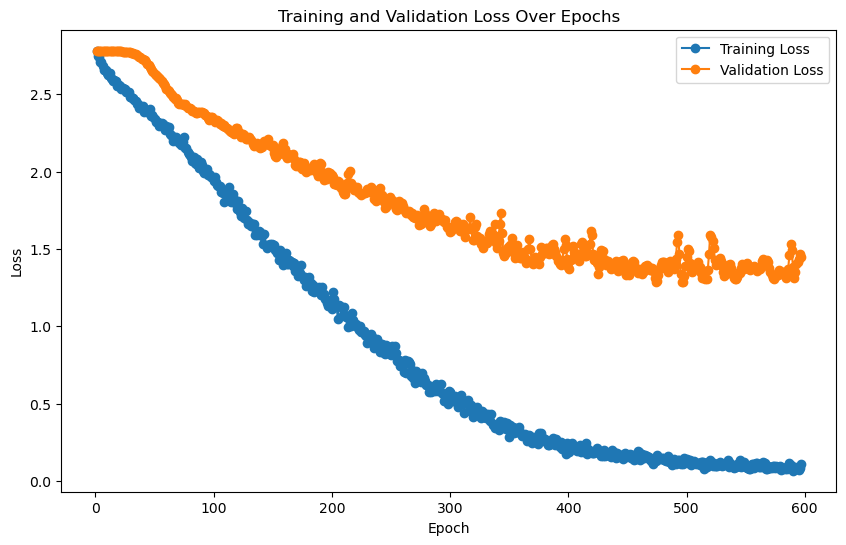

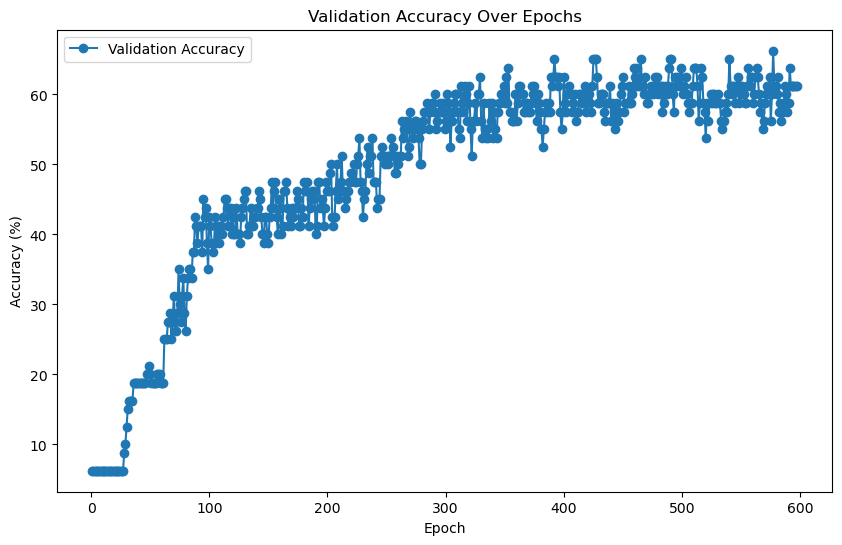


Evaluating on the test set...
    Test Batch [1/40], Loss: 2.6083

Final Test Loss: 1.7461, Test Accuracy: 46.68%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...


  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.
  Processed batch 30/40 for test dataset.


  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)

LOG: Training features shape: (80, 64), Training labels shape: (80,)
LOG: Validation features shape: (80, 64), Validation labels shape: (80,)
LOG: Test features shape: (10089, 64), Test labels shape: (10089,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.20      0.20      0.20         5
           2       0.67      0.40      0.50         5
           3       0.33      0.60      0.43         5
           4       0.60      0.60      0.60         5
           5       0.00      0.00      0.00         5
           6       1.00      0.60      0.75         5
           7       0.57      0.80      0.67         5
           8       0.83      1.00

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)
Train reps shape: (80, 64)
Train labels shape: (80,)
Val reps shape: (80, 64)
Val labels shape: (80,)
Test reps shape: (10089, 64)
Test labels shape: (10089,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.9709  |  Val Loss: 2.8573
Validation loss improved from inf to 2.8573.
[Epoch 2/1000] Train Loss: 2.8223  |  Val Loss: 2.7998
Validation loss improved from 2.8573 to 2.7998.
[Epoch 3/1000] Train Loss: 2.7639  |  Val Loss: 2.7691
Validation loss improved from 2.7998 to 2.7691.
[Epoch 4/1000] Train Loss: 2.7233  |  Val Loss: 2.7492
Validation loss improved from 2.7691 to 2.7492.
[Epoch 5/1000] Train Loss: 2.6894  |  Val Loss: 2.7313
Validation loss improved from 2.7492 to 2.7313.
[Epoch 6/1000] Train Loss: 2.6625  |  Val Loss: 2.7142
Validation loss improved from 2.7313 to 2.7142.
[Epoch 7/1000] Train Loss: 2.6403  |  Val Loss: 2.7002
Validation loss improved from 2.7142 to 2.7002.
[Epoch 8/1000] Train Loss: 2.6220  |  Val Loss: 2.6908
Validation loss improved from 2.7002 to 2.6908.
[Epoch 9/1000] Train Loss: 2.6042  |  Val Loss: 2.6784
Validation loss improved from 2.6908 to 2.6784.
[Epoch 10/1000] Train Loss: 2.5828  |  Val Loss: 2.6623
Validation loss impr

[Epoch 22/1000] Train Loss: 2.2804  |  Val Loss: 2.4547
Validation loss improved from 2.4736 to 2.4547.
[Epoch 23/1000] Train Loss: 2.2450  |  Val Loss: 2.4367
Validation loss improved from 2.4547 to 2.4367.
[Epoch 24/1000] Train Loss: 2.2223  |  Val Loss: 2.4229
Validation loss improved from 2.4367 to 2.4229.
[Epoch 25/1000] Train Loss: 2.1931  |  Val Loss: 2.4024
Validation loss improved from 2.4229 to 2.4024.
[Epoch 26/1000] Train Loss: 2.1584  |  Val Loss: 2.3754
Validation loss improved from 2.4024 to 2.3754.
[Epoch 27/1000] Train Loss: 2.1260  |  Val Loss: 2.3551
Validation loss improved from 2.3754 to 2.3551.
[Epoch 28/1000] Train Loss: 2.1072  |  Val Loss: 2.3373
Validation loss improved from 2.3551 to 2.3373.
[Epoch 29/1000] Train Loss: 2.0799  |  Val Loss: 2.3123
Validation loss improved from 2.3373 to 2.3123.
[Epoch 30/1000] Train Loss: 2.0408  |  Val Loss: 2.2892
Validation loss improved from 2.3123 to 2.2892.
[Epoch 31/1000] Train Loss: 2.0137  |  Val Loss: 2.2687
Validati

[Epoch 36/1000] Train Loss: 1.8671  |  Val Loss: 2.1521
Validation loss improved from 2.1764 to 2.1521.
[Epoch 37/1000] Train Loss: 1.8335  |  Val Loss: 2.1332
Validation loss improved from 2.1521 to 2.1332.
[Epoch 38/1000] Train Loss: 1.8087  |  Val Loss: 2.1197
Validation loss improved from 2.1332 to 2.1197.
[Epoch 39/1000] Train Loss: 1.7862  |  Val Loss: 2.1023
Validation loss improved from 2.1197 to 2.1023.
[Epoch 40/1000] Train Loss: 1.7585  |  Val Loss: 2.0838
Validation loss improved from 2.1023 to 2.0838.
[Epoch 41/1000] Train Loss: 1.7226  |  Val Loss: 2.0808
Validation loss improved from 2.0838 to 2.0808.
[Epoch 42/1000] Train Loss: 1.7147  |  Val Loss: 2.0801
Validation loss improved from 2.0808 to 2.0801.
[Epoch 43/1000] Train Loss: 1.6990  |  Val Loss: 2.0557
Validation loss improved from 2.0801 to 2.0557.
[Epoch 44/1000] Train Loss: 1.6630  |  Val Loss: 2.0247
Validation loss improved from 2.0557 to 2.0247.
[Epoch 45/1000] Train Loss: 1.6283  |  Val Loss: 2.0115
Validati

[Epoch 61/1000] Train Loss: 1.3156  |  Val Loss: 1.8235
Validation loss improved from 1.8338 to 1.8235.
[Epoch 62/1000] Train Loss: 1.2997  |  Val Loss: 1.8102
Validation loss improved from 1.8235 to 1.8102.
[Epoch 63/1000] Train Loss: 1.2732  |  Val Loss: 1.8166
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 64/1000] Train Loss: 1.2689  |  Val Loss: 1.8192
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 65/1000] Train Loss: 1.2699  |  Val Loss: 1.7874
Validation loss improved from 1.8102 to 1.7874.
[Epoch 66/1000] Train Loss: 1.2416  |  Val Loss: 1.7628
Validation loss improved from 1.7874 to 1.7628.
[Epoch 67/1000] Train Loss: 1.2223  |  Val Loss: 1.7581
Validation loss improved from 1.7628 to 1.7581.
[Epoch 68/1000] Train Loss: 1.2163  |  Val Loss: 1.7560
Validation loss improved from 1.7581 to 1.7560.
[Epoch 69/1000] Train Loss: 1.2061  |  Val Loss: 1.7414
Validation loss improved from 1.7560 to 1.7414.
[Epoch 70/1000] Train Loss: 1.1779  |  Val Loss: 1.7

[Epoch 76/1000] Train Loss: 1.1151  |  Val Loss: 1.7117
Validation loss improved from 1.7301 to 1.7117.
[Epoch 77/1000] Train Loss: 1.0967  |  Val Loss: 1.7145
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 78/1000] Train Loss: 1.0757  |  Val Loss: 1.7488
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 79/1000] Train Loss: 1.0933  |  Val Loss: 1.7479
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 80/1000] Train Loss: 1.0803  |  Val Loss: 1.7104
Validation loss improved from 1.7117 to 1.7104.
[Epoch 81/1000] Train Loss: 1.0421  |  Val Loss: 1.7118
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.0541  |  Val Loss: 1.7270
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 1.0653  |  Val Loss: 1.7109
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 84/1000] Train Loss: 1.0363  |  Val Loss: 1.6991
Validation loss improved from 1.7104 to 1.6991.
[Epoch 85/1000] Train Loss: 

[Epoch 101/1000] Train Loss: 0.8894  |  Val Loss: 1.6755
Validation loss improved from 1.6769 to 1.6755.
[Epoch 102/1000] Train Loss: 0.8744  |  Val Loss: 1.6589
Validation loss improved from 1.6755 to 1.6589.
[Epoch 103/1000] Train Loss: 0.8678  |  Val Loss: 1.6502
Validation loss improved from 1.6589 to 1.6502.
[Epoch 104/1000] Train Loss: 0.8707  |  Val Loss: 1.6502
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 105/1000] Train Loss: 0.8574  |  Val Loss: 1.6746
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 106/1000] Train Loss: 0.8615  |  Val Loss: 1.7069
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 107/1000] Train Loss: 0.8759  |  Val Loss: 1.7045
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 108/1000] Train Loss: 0.8600  |  Val Loss: 1.6972
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 109/1000] Train Loss: 0.8412  |  Val Loss: 1.6989
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 110/1000] Tr

[Epoch 115/1000] Train Loss: 0.8187  |  Val Loss: 1.6593
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 116/1000] Train Loss: 0.8099  |  Val Loss: 1.6575
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 117/1000] Train Loss: 0.7930  |  Val Loss: 1.6640
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 118/1000] Train Loss: 0.7737  |  Val Loss: 1.6690
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 119/1000] Train Loss: 0.7679  |  Val Loss: 1.6742
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 120/1000] Train Loss: 0.7641  |  Val Loss: 1.6823
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 121/1000] Train Loss: 0.7522  |  Val Loss: 1.6959
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 122/1000] Train Loss: 0.7476  |  Val Loss: 1.6909
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 123/1000] Train Loss: 0.7431  |  Val Loss: 1.6705
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 139/1000] Train Loss: 0.6997  |  Val Loss: 1.6882
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 140/1000] Train Loss: 0.6836  |  Val Loss: 1.6983
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 141/1000] Train Loss: 0.6646  |  Val Loss: 1.7212
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 142/1000] Train Loss: 0.6593  |  Val Loss: 1.7426
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 143/1000] Train Loss: 0.6608  |  Val Loss: 1.7302
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 144/1000] Train Loss: 0.6516  |  Val Loss: 1.7174
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 145/1000] Train Loss: 0.6492  |  Val Loss: 1.7181
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 146/1000] Train Loss: 0.6481  |  Val Loss: 1.7221
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 147/1000] Train Loss: 0.6385  |  Val Loss: 1.7209
!! Validation loss did NOT improve !! Patience:

[Epoch 152/1000] Train Loss: 0.6365  |  Val Loss: 1.7616
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 153/1000] Train Loss: 0.6555  |  Val Loss: 1.7603
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 154/1000] Train Loss: 0.6450  |  Val Loss: 1.7253
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 155/1000] Train Loss: 0.6103  |  Val Loss: 1.7092
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 156/1000] Train Loss: 0.6064  |  Val Loss: 1.7324
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 157/1000] Train Loss: 0.6146  |  Val Loss: 1.7497
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 158/1000] Train Loss: 0.6165  |  Val Loss: 1.7385
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 159/1000] Train Loss: 0.5958  |  Val Loss: 1.7279
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 160/1000] Train Loss: 0.5808  |  Val Loss: 1.7459
!! Validation loss did NOT improve !! Patience:

[Epoch 181/1000] Train Loss: 0.5193  |  Val Loss: 1.8298
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 182/1000] Train Loss: 0.5212  |  Val Loss: 1.8398
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 183/1000] Train Loss: 0.5197  |  Val Loss: 1.8130
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 184/1000] Train Loss: 0.5014  |  Val Loss: 1.7833
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 185/1000] Train Loss: 0.4958  |  Val Loss: 1.7821
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 186/1000] Train Loss: 0.5018  |  Val Loss: 1.7806
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 187/1000] Train Loss: 0.4961  |  Val Loss: 1.7807
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 188/1000] Train Loss: 0.4759  |  Val Loss: 1.8012
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 189/1000] Train Loss: 0.4740  |  Val Loss: 1.8260
!! Validation loss did NOT improve !! Patience:

[Epoch 192/1000] Train Loss: 0.4828  |  Val Loss: 1.8240
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 193/1000] Train Loss: 0.4773  |  Val Loss: 1.8204
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 194/1000] Train Loss: 0.4682  |  Val Loss: 1.8094
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 195/1000] Train Loss: 0.4606  |  Val Loss: 1.8090
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 196/1000] Train Loss: 0.4567  |  Val Loss: 1.7890
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 197/1000] Train Loss: 0.4608  |  Val Loss: 1.7891
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 198/1000] Train Loss: 0.4739  |  Val Loss: 1.7973
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 199/1000] Train Loss: 0.4642  |  Val Loss: 1.8197
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 200/1000] Train Loss: 0.4559  |  Val Loss: 1.8542
!! Validation loss did NOT improve !! Patience:

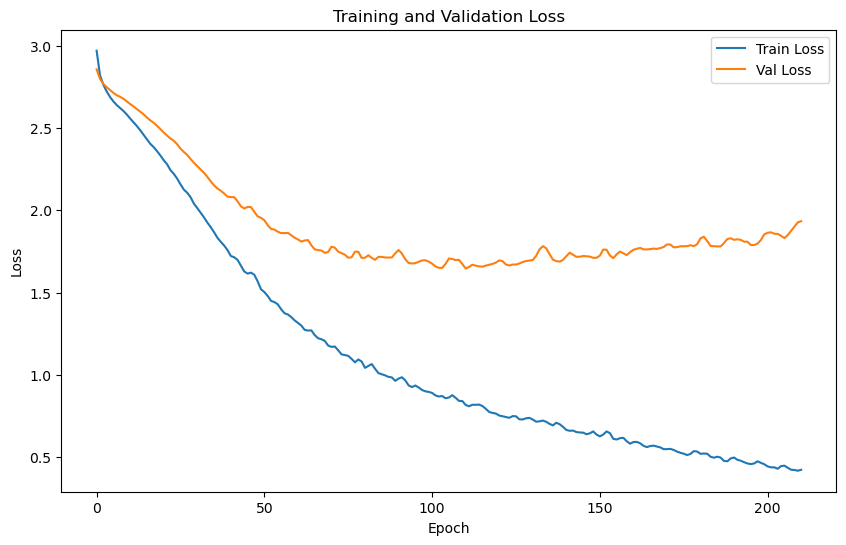

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.6311 | Test Accuracy: 37.37%


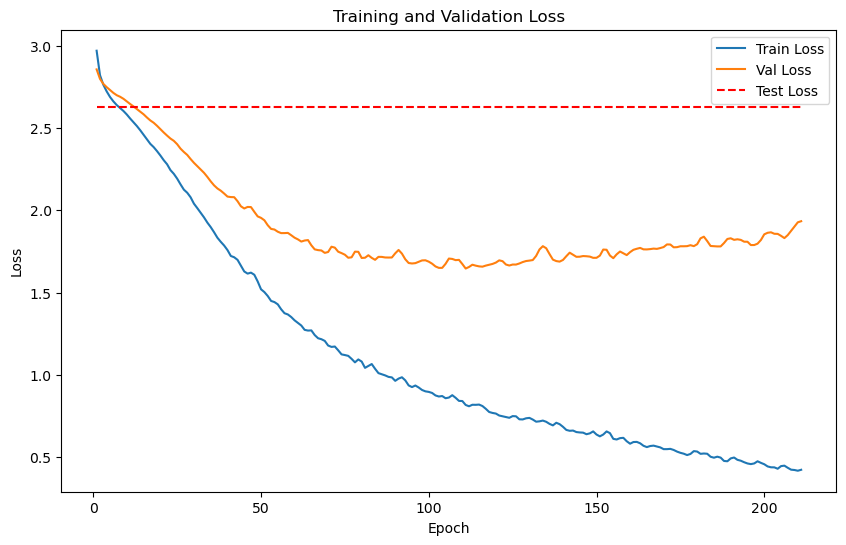

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 9.1936
Epoch [1/2000], Avg Train Loss: 9.1936
Epoch [1/2000], Avg Val Loss: 5.5925
Validation loss improved from inf to 5.5925. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 9.4038
Epoch [2/2000], Avg Train Loss: 9.4038


Epoch [2/2000], Avg Val Loss: 5.5318
Validation loss improved from 5.5925 to 5.5318. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 9.1803
Epoch [3/2000], Avg Train Loss: 9.1803
Epoch [3/2000], Avg Val Loss: 5.4727
Validation loss improved from 5.5318 to 5.4727. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 9.0300
Epoch [4/2000], Avg Train Loss: 9.0300
Epoch [4/2000], Avg Val Loss: 5.4152
Validation loss improved from 5.4727 to 5.4152. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 9.0161
Epoch [5/2000], Avg Train Loss: 9.0161
Epoch [5/2000], Avg Val Loss: 5.3592
Validation loss improved from 5.4152 to 5.3592. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 8.9301
Epoch [6/2000], Avg Train Loss: 8.9301
Epoch [6/2000], Avg Val Loss: 5.3044
Validation loss improved from 5.3592 to 5.3044. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 9.0410

    Batch [1/1], Train Loss: 7.9257
Epoch [19/2000], Avg Train Loss: 7.9257


Epoch [19/2000], Avg Val Loss: 4.7012
Validation loss improved from 4.7409 to 4.7012. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 8.2008
Epoch [20/2000], Avg Train Loss: 8.2008
Epoch [20/2000], Avg Val Loss: 4.6625
Validation loss improved from 4.7012 to 4.6625. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 7.7941
Epoch [21/2000], Avg Train Loss: 7.7941
Epoch [21/2000], Avg Val Loss: 4.6251
Validation loss improved from 4.6625 to 4.6251. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.7328
Epoch [22/2000], Avg Train Loss: 7.7328
Epoch [22/2000], Avg Val Loss: 4.5888
Validation loss improved from 4.6251 to 4.5888. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.6608
Epoch [23/2000], Avg Train Loss: 7.6608
Epoch [23/2000], Avg Val Loss: 4.5538
Validation loss improved from 4.5888 to 4.5538. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 7.1883
Epoch [30/2000], Avg Train Loss: 7.1883
Epoch [30/2000], Avg Val Loss: 4.3369
Validation loss improved from 4.3649 to 4.3369. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 7.2366
Epoch [31/2000], Avg Train Loss: 7.2366
Epoch [31/2000], Avg Val Loss: 4.3098
Validation loss improved from 4.3369 to 4.3098. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.7680
Epoch [32/2000], Avg Train Loss: 6.7680
Epoch [32/2000], Avg Val Loss: 4.2836
Validation loss improved from 4.3098 to 4.2836. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.9138
Epoch [33/2000], Avg Train Loss: 6.9138
Epoch [33/2000], Avg Val Loss: 4.2583
Validation loss improved from 4.2836 to 4.2583. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 7.0233
Epoch [34/2000], Avg Train Loss: 7.0233
Epoch [34/2000], Avg Val Loss: 4.2336
Validation loss improved from 4.2583 to 4.

    Batch [1/1], Train Loss: 6.1762
Epoch [51/2000], Avg Train Loss: 6.1762
Epoch [51/2000], Avg Val Loss: 3.9269
Validation loss improved from 3.9398 to 3.9269. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/1], Train Loss: 6.0280
Epoch [52/2000], Avg Train Loss: 6.0280
Epoch [52/2000], Avg Val Loss: 3.9144
Validation loss improved from 3.9269 to 3.9144. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 6.0341
Epoch [53/2000], Avg Train Loss: 6.0341
Epoch [53/2000], Avg Val Loss: 3.9023
Validation loss improved from 3.9144 to 3.9023. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 5.7940
Epoch [54/2000], Avg Train Loss: 5.7940
Epoch [54/2000], Avg Val Loss: 3.8907
Validation loss improved from 3.9023 to 3.8907. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 5.8191
Epoch [55/2000], Avg Train Loss: 5.8191
Epoch [55/2000], Avg Val Loss: 3.8795
Validation loss improved from 3.8907 to 3.

    Batch [1/1], Train Loss: 5.6881
Epoch [63/2000], Avg Train Loss: 5.6881
Epoch [63/2000], Avg Val Loss: 3.8049
Validation loss improved from 3.8130 to 3.8049. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 5.5241
Epoch [64/2000], Avg Train Loss: 5.5241
Epoch [64/2000], Avg Val Loss: 3.7971
Validation loss improved from 3.8049 to 3.7971. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 5.3585
Epoch [65/2000], Avg Train Loss: 5.3585
Epoch [65/2000], Avg Val Loss: 3.7896
Validation loss improved from 3.7971 to 3.7896. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 5.5769
Epoch [66/2000], Avg Train Loss: 5.5769
Epoch [66/2000], Avg Val Loss: 3.7825
Validation loss improved from 3.7896 to 3.7825. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 5.3513
Epoch [67/2000], Avg Train Loss: 5.3513
Epoch [67/2000], Avg Val Loss: 3.7757
Validation loss improved from 3.7825 to 3.

Epoch [69/2000], Avg Val Loss: 3.7628
Validation loss improved from 3.7691 to 3.7628. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.3847
Epoch [70/2000], Avg Train Loss: 5.3847
Epoch [70/2000], Avg Val Loss: 3.7568
Validation loss improved from 3.7628 to 3.7568. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.3043
Epoch [71/2000], Avg Train Loss: 5.3043
Epoch [71/2000], Avg Val Loss: 3.7511
Validation loss improved from 3.7568 to 3.7511. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.2435
Epoch [72/2000], Avg Train Loss: 5.2435
Epoch [72/2000], Avg Val Loss: 3.7456
Validation loss improved from 3.7511 to 3.7456. Saving model...

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 5.2433
Epoch [73/2000], Avg Train Loss: 5.2433
Epoch [73/2000], Avg Val Loss: 3.7404
Validation loss improved from 3.7456 to 3.7404. Saving model...

LOG: Epoch [74/2000] - Training
    Batch [1/1], Trai

Epoch [95/2000], Avg Val Loss: 3.6681
Validation loss improved from 3.6702 to 3.6681. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 4.5964
Epoch [96/2000], Avg Train Loss: 4.5964
Epoch [96/2000], Avg Val Loss: 3.6661
Validation loss improved from 3.6681 to 3.6661. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/1], Train Loss: 4.7002
Epoch [97/2000], Avg Train Loss: 4.7002
Epoch [97/2000], Avg Val Loss: 3.6641
Validation loss improved from 3.6661 to 3.6641. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 4.6850
Epoch [98/2000], Avg Train Loss: 4.6850
Epoch [98/2000], Avg Val Loss: 3.6623
Validation loss improved from 3.6641 to 3.6623. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 4.6298
Epoch [99/2000], Avg Train Loss: 4.6298
Epoch [99/2000], Avg Val Loss: 3.6604
Validation loss improved from 3.6623 to 3.6604. Saving model...

LOG: Epoch [100/2000] - Training
    Batch [1/1], Tra

    Batch [1/1], Train Loss: 4.4863
Epoch [109/2000], Avg Train Loss: 4.4863
Epoch [109/2000], Avg Val Loss: 3.6451
Validation loss improved from 3.6464 to 3.6451. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 4.5660
Epoch [110/2000], Avg Train Loss: 4.5660
Epoch [110/2000], Avg Val Loss: 3.6438
Validation loss improved from 3.6451 to 3.6438. Saving model...

LOG: Epoch [111/2000] - Training
    Batch [1/1], Train Loss: 4.5064
Epoch [111/2000], Avg Train Loss: 4.5064
Epoch [111/2000], Avg Val Loss: 3.6425
Validation loss improved from 3.6438 to 3.6425. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/1], Train Loss: 4.6091
Epoch [112/2000], Avg Train Loss: 4.6091
Epoch [112/2000], Avg Val Loss: 3.6412
Validation loss improved from 3.6425 to 3.6412. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 4.6322
Epoch [113/2000], Avg Train Loss: 4.6322
Epoch [113/2000], Avg Val Loss: 3.6400
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3235
Epoch [144/2000], Avg Train Loss: 4.3235
Epoch [144/2000], Avg Val Loss: 3.6146
Validation loss improved from 3.6153 to 3.6146. Saving model...

LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 4.1626
Epoch [145/2000], Avg Train Loss: 4.1626
Epoch [145/2000], Avg Val Loss: 3.6140
Validation loss improved from 3.6146 to 3.6140. Saving model...

LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 4.2848
Epoch [146/2000], Avg Train Loss: 4.2848
Epoch [146/2000], Avg Val Loss: 3.6133
Validation loss improved from 3.6140 to 3.6133. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 4.2885
Epoch [147/2000], Avg Train Loss: 4.2885
Epoch [147/2000], Avg Val Loss: 3.6127
Validation loss improved from 3.6133 to 3.6127. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 4.2896
Epoch [148/2000], Avg Train Loss: 4.2896
Epoch [148/2000], Avg Val Loss: 3.6120
Validation loss improved fro

    Batch [1/1], Train Loss: 4.1720
Epoch [154/2000], Avg Train Loss: 4.1720
Epoch [154/2000], Avg Val Loss: 3.6080
Validation loss improved from 3.6087 to 3.6080. Saving model...

LOG: Epoch [155/2000] - Training
    Batch [1/1], Train Loss: 4.3535
Epoch [155/2000], Avg Train Loss: 4.3535
Epoch [155/2000], Avg Val Loss: 3.6074
Validation loss improved from 3.6080 to 3.6074. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 4.1744
Epoch [156/2000], Avg Train Loss: 4.1744
Epoch [156/2000], Avg Val Loss: 3.6068
Validation loss improved from 3.6074 to 3.6068. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 4.1947
Epoch [157/2000], Avg Train Loss: 4.1947
Epoch [157/2000], Avg Val Loss: 3.6062
Validation loss improved from 3.6068 to 3.6062. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 4.2360
Epoch [158/2000], Avg Train Loss: 4.2360
Epoch [158/2000], Avg Val Loss: 3.6055
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0495
Epoch [190/2000], Avg Train Loss: 4.0495
Epoch [190/2000], Avg Val Loss: 3.5877
Validation loss improved from 3.5882 to 3.5877. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/1], Train Loss: 3.9755
Epoch [191/2000], Avg Train Loss: 3.9755
Epoch [191/2000], Avg Val Loss: 3.5871
Validation loss improved from 3.5877 to 3.5871. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 4.1167
Epoch [192/2000], Avg Train Loss: 4.1167
Epoch [192/2000], Avg Val Loss: 3.5865
Validation loss improved from 3.5871 to 3.5865. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 4.0716
Epoch [193/2000], Avg Train Loss: 4.0716
Epoch [193/2000], Avg Val Loss: 3.5859
Validation loss improved from 3.5865 to 3.5859. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 4.1075
Epoch [194/2000], Avg Train Loss: 4.1075
Epoch [194/2000], Avg Val Loss: 3.5853
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0535
Epoch [199/2000], Avg Train Loss: 4.0535
Epoch [199/2000], Avg Val Loss: 3.5821
Validation loss improved from 3.5828 to 3.5821. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/1], Train Loss: 4.0673
Epoch [200/2000], Avg Train Loss: 4.0673
Epoch [200/2000], Avg Val Loss: 3.5815
Validation loss improved from 3.5821 to 3.5815. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 4.0703
Epoch [201/2000], Avg Train Loss: 4.0703
Epoch [201/2000], Avg Val Loss: 3.5809
Validation loss improved from 3.5815 to 3.5809. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 4.0020
Epoch [202/2000], Avg Train Loss: 4.0020
Epoch [202/2000], Avg Val Loss: 3.5802
Validation loss improved from 3.5809 to 3.5802. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 4.0636
Epoch [203/2000], Avg Train Loss: 4.0636
Epoch [203/2000], Avg Val Loss: 3.5796
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9599
Epoch [233/2000], Avg Train Loss: 3.9599
Epoch [233/2000], Avg Val Loss: 3.5591
Validation loss improved from 3.5598 to 3.5591. Saving model...

LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 3.9207
Epoch [234/2000], Avg Train Loss: 3.9207
Epoch [234/2000], Avg Val Loss: 3.5584
Validation loss improved from 3.5591 to 3.5584. Saving model...

LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 3.9912
Epoch [235/2000], Avg Train Loss: 3.9912
Epoch [235/2000], Avg Val Loss: 3.5577
Validation loss improved from 3.5584 to 3.5577. Saving model...

LOG: Epoch [236/2000] - Training
    Batch [1/1], Train Loss: 3.9558
Epoch [236/2000], Avg Train Loss: 3.9558
Epoch [236/2000], Avg Val Loss: 3.5570
Validation loss improved from 3.5577 to 3.5570. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/1], Train Loss: 3.9588
Epoch [237/2000], Avg Train Loss: 3.9588
Epoch [237/2000], Avg Val Loss: 3.5563
Validation loss improved fro

    Batch [1/1], Train Loss: 3.9199
Epoch [246/2000], Avg Train Loss: 3.9199
Epoch [246/2000], Avg Val Loss: 3.5501
Validation loss improved from 3.5508 to 3.5501. Saving model...

LOG: Epoch [247/2000] - Training
    Batch [1/1], Train Loss: 3.9237
Epoch [247/2000], Avg Train Loss: 3.9237
Epoch [247/2000], Avg Val Loss: 3.5495
Validation loss improved from 3.5501 to 3.5495. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/1], Train Loss: 3.8658
Epoch [248/2000], Avg Train Loss: 3.8658
Epoch [248/2000], Avg Val Loss: 3.5488
Validation loss improved from 3.5495 to 3.5488. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/1], Train Loss: 3.8569
Epoch [249/2000], Avg Train Loss: 3.8569
Epoch [249/2000], Avg Val Loss: 3.5481
Validation loss improved from 3.5488 to 3.5481. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 3.9531
Epoch [250/2000], Avg Train Loss: 3.9531
Epoch [250/2000], Avg Val Loss: 3.5475
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8660
Epoch [279/2000], Avg Train Loss: 3.8660
Epoch [279/2000], Avg Val Loss: 3.5275
Validation loss improved from 3.5282 to 3.5275. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 3.9300
Epoch [280/2000], Avg Train Loss: 3.9300
Epoch [280/2000], Avg Val Loss: 3.5268
Validation loss improved from 3.5275 to 3.5268. Saving model...

LOG: Epoch [281/2000] - Training
    Batch [1/1], Train Loss: 3.8266
Epoch [281/2000], Avg Train Loss: 3.8266
Epoch [281/2000], Avg Val Loss: 3.5260
Validation loss improved from 3.5268 to 3.5260. Saving model...

LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 3.8689
Epoch [282/2000], Avg Train Loss: 3.8689
Epoch [282/2000], Avg Val Loss: 3.5253
Validation loss improved from 3.5260 to 3.5253. Saving model...

LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 3.8728
Epoch [283/2000], Avg Train Loss: 3.8728
Epoch [283/2000], Avg Val Loss: 3.5246
Validation loss improved fro

    Batch [1/1], Train Loss: 3.8319
Epoch [288/2000], Avg Train Loss: 3.8319
Epoch [288/2000], Avg Val Loss: 3.5211
Validation loss improved from 3.5218 to 3.5211. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.8628
Epoch [289/2000], Avg Train Loss: 3.8628
Epoch [289/2000], Avg Val Loss: 3.5204
Validation loss improved from 3.5211 to 3.5204. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/1], Train Loss: 3.8412
Epoch [290/2000], Avg Train Loss: 3.8412
Epoch [290/2000], Avg Val Loss: 3.5198
Validation loss improved from 3.5204 to 3.5198. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 3.7879
Epoch [291/2000], Avg Train Loss: 3.7879
Epoch [291/2000], Avg Val Loss: 3.5191
Validation loss improved from 3.5198 to 3.5191. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 3.8609
Epoch [292/2000], Avg Train Loss: 3.8609
Epoch [292/2000], Avg Val Loss: 3.5184
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7741
Epoch [319/2000], Avg Train Loss: 3.7741
Epoch [319/2000], Avg Val Loss: 3.4996
Validation loss improved from 3.5003 to 3.4996. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 3.7861
Epoch [320/2000], Avg Train Loss: 3.7861
Epoch [320/2000], Avg Val Loss: 3.4989
Validation loss improved from 3.4996 to 3.4989. Saving model...

LOG: Epoch [321/2000] - Training
    Batch [1/1], Train Loss: 3.7544
Epoch [321/2000], Avg Train Loss: 3.7544
Epoch [321/2000], Avg Val Loss: 3.4982
Validation loss improved from 3.4989 to 3.4982. Saving model...

LOG: Epoch [322/2000] - Training
    Batch [1/1], Train Loss: 3.8214
Epoch [322/2000], Avg Train Loss: 3.8214
Epoch [322/2000], Avg Val Loss: 3.4975
Validation loss improved from 3.4982 to 3.4975. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 3.7380
Epoch [323/2000], Avg Train Loss: 3.7380
Epoch [323/2000], Avg Val Loss: 3.4968
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7873
Epoch [332/2000], Avg Train Loss: 3.7873
Epoch [332/2000], Avg Val Loss: 3.4909
Validation loss improved from 3.4916 to 3.4909. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 3.7470
Epoch [333/2000], Avg Train Loss: 3.7470
Epoch [333/2000], Avg Val Loss: 3.4902
Validation loss improved from 3.4909 to 3.4902. Saving model...

LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 3.7240
Epoch [334/2000], Avg Train Loss: 3.7240
Epoch [334/2000], Avg Val Loss: 3.4896
Validation loss improved from 3.4902 to 3.4896. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 3.7456
Epoch [335/2000], Avg Train Loss: 3.7456
Epoch [335/2000], Avg Val Loss: 3.4889
Validation loss improved from 3.4896 to 3.4889. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 3.6828
Epoch [336/2000], Avg Train Loss: 3.6828
Epoch [336/2000], Avg Val Loss: 3.4883
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7812
Epoch [365/2000], Avg Train Loss: 3.7812
Epoch [365/2000], Avg Val Loss: 3.4680
Validation loss improved from 3.4687 to 3.4680. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/1], Train Loss: 3.7117
Epoch [366/2000], Avg Train Loss: 3.7117
Epoch [366/2000], Avg Val Loss: 3.4673
Validation loss improved from 3.4680 to 3.4673. Saving model...

LOG: Epoch [367/2000] - Training
    Batch [1/1], Train Loss: 3.6687
Epoch [367/2000], Avg Train Loss: 3.6687
Epoch [367/2000], Avg Val Loss: 3.4666
Validation loss improved from 3.4673 to 3.4666. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 3.7354
Epoch [368/2000], Avg Train Loss: 3.7354
Epoch [368/2000], Avg Val Loss: 3.4660
Validation loss improved from 3.4666 to 3.4660. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 3.6489
Epoch [369/2000], Avg Train Loss: 3.6489
Epoch [369/2000], Avg Val Loss: 3.4653
Validation loss improved fro

Epoch [377/2000], Avg Val Loss: 3.4599
Validation loss improved from 3.4605 to 3.4599. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 3.6502
Epoch [378/2000], Avg Train Loss: 3.6502
Epoch [378/2000], Avg Val Loss: 3.4591
Validation loss improved from 3.4599 to 3.4591. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 3.6407
Epoch [379/2000], Avg Train Loss: 3.6407
Epoch [379/2000], Avg Val Loss: 3.4584
Validation loss improved from 3.4591 to 3.4584. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.7227
Epoch [380/2000], Avg Train Loss: 3.7227
Epoch [380/2000], Avg Val Loss: 3.4578
Validation loss improved from 3.4584 to 3.4578. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.7067
Epoch [381/2000], Avg Train Loss: 3.7067
Epoch [381/2000], Avg Val Loss: 3.4571
Validation loss improved from 3.4578 to 3.4571. Saving model...

LOG: Epoch [382/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.6566
Epoch [407/2000], Avg Train Loss: 3.6566
Epoch [407/2000], Avg Val Loss: 3.4410
Validation loss improved from 3.4416 to 3.4410. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.6172
Epoch [408/2000], Avg Train Loss: 3.6172
Epoch [408/2000], Avg Val Loss: 3.4404
Validation loss improved from 3.4410 to 3.4404. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.6381
Epoch [409/2000], Avg Train Loss: 3.6381
Epoch [409/2000], Avg Val Loss: 3.4399
Validation loss improved from 3.4404 to 3.4399. Saving model...

LOG: Epoch [410/2000] - Training
    Batch [1/1], Train Loss: 3.6111
Epoch [410/2000], Avg Train Loss: 3.6111
Epoch [410/2000], Avg Val Loss: 3.4393
Validation loss improved from 3.4399 to 3.4393. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/1], Train Loss: 3.6392
Epoch [411/2000], Avg Train Loss: 3.6392
Epoch [411/2000], Avg Val Loss: 3.4387
Validation loss improved fro

Epoch [420/2000], Avg Val Loss: 3.4331
Validation loss improved from 3.4337 to 3.4331. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/1], Train Loss: 3.6589
Epoch [421/2000], Avg Train Loss: 3.6589
Epoch [421/2000], Avg Val Loss: 3.4324
Validation loss improved from 3.4331 to 3.4324. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/1], Train Loss: 3.5723
Epoch [422/2000], Avg Train Loss: 3.5723
Epoch [422/2000], Avg Val Loss: 3.4318
Validation loss improved from 3.4324 to 3.4318. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/1], Train Loss: 3.6312
Epoch [423/2000], Avg Train Loss: 3.6312
Epoch [423/2000], Avg Val Loss: 3.4312
Validation loss improved from 3.4318 to 3.4312. Saving model...

LOG: Epoch [424/2000] - Training
    Batch [1/1], Train Loss: 3.6541
Epoch [424/2000], Avg Train Loss: 3.6541
Epoch [424/2000], Avg Val Loss: 3.4306
Validation loss improved from 3.4312 to 3.4306. Saving model...

LOG: Epoch [425/2000] - Training
    Bat

Epoch [446/2000], Avg Val Loss: 3.4182
Validation loss improved from 3.4188 to 3.4182. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/1], Train Loss: 3.6956
Epoch [447/2000], Avg Train Loss: 3.6956
Epoch [447/2000], Avg Val Loss: 3.4177
Validation loss improved from 3.4182 to 3.4177. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/1], Train Loss: 3.6492
Epoch [448/2000], Avg Train Loss: 3.6492
Epoch [448/2000], Avg Val Loss: 3.4172
Validation loss improved from 3.4177 to 3.4172. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/1], Train Loss: 3.5834
Epoch [449/2000], Avg Train Loss: 3.5834
Epoch [449/2000], Avg Val Loss: 3.4166
Validation loss improved from 3.4172 to 3.4166. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/1], Train Loss: 3.6487
Epoch [450/2000], Avg Train Loss: 3.6487
Epoch [450/2000], Avg Val Loss: 3.4161
Validation loss improved from 3.4166 to 3.4161. Saving model...

LOG: Epoch [451/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5048
Epoch [463/2000], Avg Train Loss: 3.5048
Epoch [463/2000], Avg Val Loss: 3.4086
Validation loss improved from 3.4092 to 3.4086. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/1], Train Loss: 3.5558
Epoch [464/2000], Avg Train Loss: 3.5558
Epoch [464/2000], Avg Val Loss: 3.4080
Validation loss improved from 3.4086 to 3.4080. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/1], Train Loss: 3.6087
Epoch [465/2000], Avg Train Loss: 3.6087
Epoch [465/2000], Avg Val Loss: 3.4074
Validation loss improved from 3.4080 to 3.4074. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/1], Train Loss: 3.6530
Epoch [466/2000], Avg Train Loss: 3.6530
Epoch [466/2000], Avg Val Loss: 3.4068
Validation loss improved from 3.4074 to 3.4068. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/1], Train Loss: 3.5552
Epoch [467/2000], Avg Train Loss: 3.5552
Epoch [467/2000], Avg Val Loss: 3.4063
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5934
Epoch [493/2000], Avg Train Loss: 3.5934
Epoch [493/2000], Avg Val Loss: 3.3928
Validation loss improved from 3.3934 to 3.3928. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/1], Train Loss: 3.6463
Epoch [494/2000], Avg Train Loss: 3.6463
Epoch [494/2000], Avg Val Loss: 3.3923
Validation loss improved from 3.3928 to 3.3923. Saving model...

LOG: Epoch [495/2000] - Training
    Batch [1/1], Train Loss: 3.5512
Epoch [495/2000], Avg Train Loss: 3.5512
Epoch [495/2000], Avg Val Loss: 3.3918
Validation loss improved from 3.3923 to 3.3918. Saving model...

LOG: Epoch [496/2000] - Training
    Batch [1/1], Train Loss: 3.6346
Epoch [496/2000], Avg Train Loss: 3.6346
Epoch [496/2000], Avg Val Loss: 3.3913
Validation loss improved from 3.3918 to 3.3913. Saving model...

LOG: Epoch [497/2000] - Training
    Batch [1/1], Train Loss: 3.5380
Epoch [497/2000], Avg Train Loss: 3.5380
Epoch [497/2000], Avg Val Loss: 3.3908
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5724
Epoch [514/2000], Avg Train Loss: 3.5724
Epoch [514/2000], Avg Val Loss: 3.3825
Validation loss improved from 3.3830 to 3.3825. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 3.5386
Epoch [515/2000], Avg Train Loss: 3.5386
Epoch [515/2000], Avg Val Loss: 3.3819
Validation loss improved from 3.3825 to 3.3819. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 3.5066
Epoch [516/2000], Avg Train Loss: 3.5066
Epoch [516/2000], Avg Val Loss: 3.3814
Validation loss improved from 3.3819 to 3.3814. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 3.5722
Epoch [517/2000], Avg Train Loss: 3.5722
Epoch [517/2000], Avg Val Loss: 3.3808
Validation loss improved from 3.3814 to 3.3808. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.4682
Epoch [518/2000], Avg Train Loss: 3.4682
Epoch [518/2000], Avg Val Loss: 3.3802
Validation loss improved fro

Epoch [540/2000], Avg Val Loss: 3.3690
Validation loss improved from 3.3695 to 3.3690. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 3.4077
Epoch [541/2000], Avg Train Loss: 3.4077
Epoch [541/2000], Avg Val Loss: 3.3685
Validation loss improved from 3.3690 to 3.3685. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 3.4729
Epoch [542/2000], Avg Train Loss: 3.4729
Epoch [542/2000], Avg Val Loss: 3.3680
Validation loss improved from 3.3685 to 3.3680. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 3.4957
Epoch [543/2000], Avg Train Loss: 3.4957
Epoch [543/2000], Avg Val Loss: 3.3675
Validation loss improved from 3.3680 to 3.3675. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.4630
Epoch [544/2000], Avg Train Loss: 3.4630
Epoch [544/2000], Avg Val Loss: 3.3670
Validation loss improved from 3.3675 to 3.3670. Saving model...

LOG: Epoch [545/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4712
Epoch [557/2000], Avg Train Loss: 3.4712
Epoch [557/2000], Avg Val Loss: 3.3610
Validation loss improved from 3.3615 to 3.3610. Saving model...

LOG: Epoch [558/2000] - Training
    Batch [1/1], Train Loss: 3.4542
Epoch [558/2000], Avg Train Loss: 3.4542
Epoch [558/2000], Avg Val Loss: 3.3605
Validation loss improved from 3.3610 to 3.3605. Saving model...

LOG: Epoch [559/2000] - Training
    Batch [1/1], Train Loss: 3.5023
Epoch [559/2000], Avg Train Loss: 3.5023
Epoch [559/2000], Avg Val Loss: 3.3600
Validation loss improved from 3.3605 to 3.3600. Saving model...

LOG: Epoch [560/2000] - Training
    Batch [1/1], Train Loss: 3.4130
Epoch [560/2000], Avg Train Loss: 3.4130
Epoch [560/2000], Avg Val Loss: 3.3595
Validation loss improved from 3.3600 to 3.3595. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.4117
Epoch [561/2000], Avg Train Loss: 3.4117
Epoch [561/2000], Avg Val Loss: 3.3590
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4818
Epoch [582/2000], Avg Train Loss: 3.4818
Epoch [582/2000], Avg Val Loss: 3.3497
Validation loss improved from 3.3502 to 3.3497. Saving model...

LOG: Epoch [583/2000] - Training
    Batch [1/1], Train Loss: 3.4539
Epoch [583/2000], Avg Train Loss: 3.4539
Epoch [583/2000], Avg Val Loss: 3.3493
Validation loss improved from 3.3497 to 3.3493. Saving model...

LOG: Epoch [584/2000] - Training
    Batch [1/1], Train Loss: 3.4589
Epoch [584/2000], Avg Train Loss: 3.4589
Epoch [584/2000], Avg Val Loss: 3.3488
Validation loss improved from 3.3493 to 3.3488. Saving model...

LOG: Epoch [585/2000] - Training
    Batch [1/1], Train Loss: 3.4689
Epoch [585/2000], Avg Train Loss: 3.4689
Epoch [585/2000], Avg Val Loss: 3.3484
Validation loss improved from 3.3488 to 3.3484. Saving model...

LOG: Epoch [586/2000] - Training
    Batch [1/1], Train Loss: 3.4970
Epoch [586/2000], Avg Train Loss: 3.4970
Epoch [586/2000], Avg Val Loss: 3.3479
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3601
Epoch [602/2000], Avg Train Loss: 3.3601
Epoch [602/2000], Avg Val Loss: 3.3406
Validation loss improved from 3.3410 to 3.3406. Saving model...

LOG: Epoch [603/2000] - Training
    Batch [1/1], Train Loss: 3.3554
Epoch [603/2000], Avg Train Loss: 3.3554
Epoch [603/2000], Avg Val Loss: 3.3402
Validation loss improved from 3.3406 to 3.3402. Saving model...

LOG: Epoch [604/2000] - Training
    Batch [1/1], Train Loss: 3.3277
Epoch [604/2000], Avg Train Loss: 3.3277
Epoch [604/2000], Avg Val Loss: 3.3398
Validation loss improved from 3.3402 to 3.3398. Saving model...

LOG: Epoch [605/2000] - Training
    Batch [1/1], Train Loss: 3.4251
Epoch [605/2000], Avg Train Loss: 3.4251
Epoch [605/2000], Avg Val Loss: 3.3394
Validation loss improved from 3.3398 to 3.3394. Saving model...

LOG: Epoch [606/2000] - Training
    Batch [1/1], Train Loss: 3.4219
Epoch [606/2000], Avg Train Loss: 3.4219
Epoch [606/2000], Avg Val Loss: 3.3390
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3624
Epoch [625/2000], Avg Train Loss: 3.3624
Epoch [625/2000], Avg Val Loss: 3.3313
Validation loss improved from 3.3317 to 3.3313. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/1], Train Loss: 3.4337
Epoch [626/2000], Avg Train Loss: 3.4337
Epoch [626/2000], Avg Val Loss: 3.3310
Validation loss improved from 3.3313 to 3.3310. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/1], Train Loss: 3.3763
Epoch [627/2000], Avg Train Loss: 3.3763
Epoch [627/2000], Avg Val Loss: 3.3306
Validation loss improved from 3.3310 to 3.3306. Saving model...

LOG: Epoch [628/2000] - Training
    Batch [1/1], Train Loss: 3.4304
Epoch [628/2000], Avg Train Loss: 3.4304
Epoch [628/2000], Avg Val Loss: 3.3303
Validation loss improved from 3.3306 to 3.3303. Saving model...

LOG: Epoch [629/2000] - Training
    Batch [1/1], Train Loss: 3.3510
Epoch [629/2000], Avg Train Loss: 3.3510
Epoch [629/2000], Avg Val Loss: 3.3299
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3744
Epoch [649/2000], Avg Train Loss: 3.3744
Epoch [649/2000], Avg Val Loss: 3.3228
Validation loss improved from 3.3231 to 3.3228. Saving model...

LOG: Epoch [650/2000] - Training
    Batch [1/1], Train Loss: 3.4568
Epoch [650/2000], Avg Train Loss: 3.4568
Epoch [650/2000], Avg Val Loss: 3.3225
Validation loss improved from 3.3228 to 3.3225. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/1], Train Loss: 3.3796
Epoch [651/2000], Avg Train Loss: 3.3796
Epoch [651/2000], Avg Val Loss: 3.3222
Validation loss improved from 3.3225 to 3.3222. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/1], Train Loss: 3.3811
Epoch [652/2000], Avg Train Loss: 3.3811
Epoch [652/2000], Avg Val Loss: 3.3219
Validation loss improved from 3.3222 to 3.3219. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/1], Train Loss: 3.3991
Epoch [653/2000], Avg Train Loss: 3.3991
Epoch [653/2000], Avg Val Loss: 3.3216
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3285
Epoch [672/2000], Avg Train Loss: 3.3285
Epoch [672/2000], Avg Val Loss: 3.3159
Validation loss improved from 3.3161 to 3.3159. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/1], Train Loss: 3.3989
Epoch [673/2000], Avg Train Loss: 3.3989
Epoch [673/2000], Avg Val Loss: 3.3156
Validation loss improved from 3.3159 to 3.3156. Saving model...

LOG: Epoch [674/2000] - Training
    Batch [1/1], Train Loss: 3.3658
Epoch [674/2000], Avg Train Loss: 3.3658
Epoch [674/2000], Avg Val Loss: 3.3154
Validation loss improved from 3.3156 to 3.3154. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/1], Train Loss: 3.4655
Epoch [675/2000], Avg Train Loss: 3.4655
Epoch [675/2000], Avg Val Loss: 3.3151
Validation loss improved from 3.3154 to 3.3151. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/1], Train Loss: 3.4302
Epoch [676/2000], Avg Train Loss: 3.4302
Epoch [676/2000], Avg Val Loss: 3.3149
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2649
Epoch [696/2000], Avg Train Loss: 3.2649
Epoch [696/2000], Avg Val Loss: 3.3106
Validation loss improved from 3.3108 to 3.3106. Saving model...

LOG: Epoch [697/2000] - Training
    Batch [1/1], Train Loss: 3.3699
Epoch [697/2000], Avg Train Loss: 3.3699
Epoch [697/2000], Avg Val Loss: 3.3103
Validation loss improved from 3.3106 to 3.3103. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 3.3794
Epoch [698/2000], Avg Train Loss: 3.3794
Epoch [698/2000], Avg Val Loss: 3.3101
Validation loss improved from 3.3103 to 3.3101. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 3.3232
Epoch [699/2000], Avg Train Loss: 3.3232
Epoch [699/2000], Avg Val Loss: 3.3098
Validation loss improved from 3.3101 to 3.3098. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 3.2971
Epoch [700/2000], Avg Train Loss: 3.2971
Epoch [700/2000], Avg Val Loss: 3.3096
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2879
Epoch [717/2000], Avg Train Loss: 3.2879
Epoch [717/2000], Avg Val Loss: 3.3047
Validation loss improved from 3.3050 to 3.3047. Saving model...

LOG: Epoch [718/2000] - Training
    Batch [1/1], Train Loss: 3.2474
Epoch [718/2000], Avg Train Loss: 3.2474
Epoch [718/2000], Avg Val Loss: 3.3045
Validation loss improved from 3.3047 to 3.3045. Saving model...

LOG: Epoch [719/2000] - Training
    Batch [1/1], Train Loss: 3.2678
Epoch [719/2000], Avg Train Loss: 3.2678
Epoch [719/2000], Avg Val Loss: 3.3042
Validation loss improved from 3.3045 to 3.3042. Saving model...

LOG: Epoch [720/2000] - Training
    Batch [1/1], Train Loss: 3.2596
Epoch [720/2000], Avg Train Loss: 3.2596
Epoch [720/2000], Avg Val Loss: 3.3040
Validation loss improved from 3.3042 to 3.3040. Saving model...

LOG: Epoch [721/2000] - Training
    Batch [1/1], Train Loss: 3.2798
Epoch [721/2000], Avg Train Loss: 3.2798
Epoch [721/2000], Avg Val Loss: 3.3037
Validation loss improved fro

    Batch [1/1], Train Loss: 3.3281
Epoch [741/2000], Avg Train Loss: 3.3281
Epoch [741/2000], Avg Val Loss: 3.2972
Validation loss improved from 3.2975 to 3.2972. Saving model...

LOG: Epoch [742/2000] - Training
    Batch [1/1], Train Loss: 3.3287
Epoch [742/2000], Avg Train Loss: 3.3287
Epoch [742/2000], Avg Val Loss: 3.2970
Validation loss improved from 3.2972 to 3.2970. Saving model...

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 3.3110
Epoch [743/2000], Avg Train Loss: 3.3110
Epoch [743/2000], Avg Val Loss: 3.2967
Validation loss improved from 3.2970 to 3.2967. Saving model...

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 3.3763
Epoch [744/2000], Avg Train Loss: 3.3763
Epoch [744/2000], Avg Val Loss: 3.2964
Validation loss improved from 3.2967 to 3.2964. Saving model...

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 3.2837
Epoch [745/2000], Avg Train Loss: 3.2837
Epoch [745/2000], Avg Val Loss: 3.2961
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2470
Epoch [766/2000], Avg Train Loss: 3.2470
Epoch [766/2000], Avg Val Loss: 3.2915
Validation loss improved from 3.2917 to 3.2915. Saving model...

LOG: Epoch [767/2000] - Training
    Batch [1/1], Train Loss: 3.2659
Epoch [767/2000], Avg Train Loss: 3.2659
Epoch [767/2000], Avg Val Loss: 3.2913
Validation loss improved from 3.2915 to 3.2913. Saving model...

LOG: Epoch [768/2000] - Training
    Batch [1/1], Train Loss: 3.3469
Epoch [768/2000], Avg Train Loss: 3.3469
Epoch [768/2000], Avg Val Loss: 3.2911
Validation loss improved from 3.2913 to 3.2911. Saving model...

LOG: Epoch [769/2000] - Training
    Batch [1/1], Train Loss: 3.2875
Epoch [769/2000], Avg Train Loss: 3.2875
Epoch [769/2000], Avg Val Loss: 3.2909
Validation loss improved from 3.2911 to 3.2909. Saving model...

LOG: Epoch [770/2000] - Training
    Batch [1/1], Train Loss: 3.2969
Epoch [770/2000], Avg Train Loss: 3.2969
Epoch [770/2000], Avg Val Loss: 3.2908
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2253
Epoch [789/2000], Avg Train Loss: 3.2253
Epoch [789/2000], Avg Val Loss: 3.2886
Validation loss improved from 3.2887 to 3.2886. Saving model...

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 3.2433
Epoch [790/2000], Avg Train Loss: 3.2433
Epoch [790/2000], Avg Val Loss: 3.2885
Validation loss improved from 3.2886 to 3.2885. Saving model...

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 3.2551
Epoch [791/2000], Avg Train Loss: 3.2551
Epoch [791/2000], Avg Val Loss: 3.2884
Validation loss improved from 3.2885 to 3.2884. Saving model...

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.2684
Epoch [792/2000], Avg Train Loss: 3.2684
Epoch [792/2000], Avg Val Loss: 3.2883
Validation loss improved from 3.2884 to 3.2883. Saving model...

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 3.2763
Epoch [793/2000], Avg Train Loss: 3.2763
Epoch [793/2000], Avg Val Loss: 3.2882
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2629
Epoch [813/2000], Avg Train Loss: 3.2629
Epoch [813/2000], Avg Val Loss: 3.2861
Validation loss improved from 3.2862 to 3.2861. Saving model...

LOG: Epoch [814/2000] - Training
    Batch [1/1], Train Loss: 3.1969
Epoch [814/2000], Avg Train Loss: 3.1969
Epoch [814/2000], Avg Val Loss: 3.2861
Validation loss improved from 3.2861 to 3.2861. Saving model...

LOG: Epoch [815/2000] - Training
    Batch [1/1], Train Loss: 3.2422
Epoch [815/2000], Avg Train Loss: 3.2422
Epoch [815/2000], Avg Val Loss: 3.2860
Validation loss improved from 3.2861 to 3.2860. Saving model...

LOG: Epoch [816/2000] - Training
    Batch [1/1], Train Loss: 3.2712
Epoch [816/2000], Avg Train Loss: 3.2712
Epoch [816/2000], Avg Val Loss: 3.2860
Validation loss improved from 3.2860 to 3.2860. Saving model...

LOG: Epoch [817/2000] - Training
    Batch [1/1], Train Loss: 3.2244
Epoch [817/2000], Avg Train Loss: 3.2244
Epoch [817/2000], Avg Val Loss: 3.2860
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1631
Epoch [836/2000], Avg Train Loss: 3.1631
Epoch [836/2000], Avg Val Loss: 3.2844
Validation loss improved from 3.2845 to 3.2844. Saving model...

LOG: Epoch [837/2000] - Training
    Batch [1/1], Train Loss: 3.1579
Epoch [837/2000], Avg Train Loss: 3.1579
Epoch [837/2000], Avg Val Loss: 3.2843
Validation loss improved from 3.2844 to 3.2843. Saving model...

LOG: Epoch [838/2000] - Training
    Batch [1/1], Train Loss: 3.1556
Epoch [838/2000], Avg Train Loss: 3.1556
Epoch [838/2000], Avg Val Loss: 3.2841
Validation loss improved from 3.2843 to 3.2841. Saving model...

LOG: Epoch [839/2000] - Training
    Batch [1/1], Train Loss: 3.1643
Epoch [839/2000], Avg Train Loss: 3.1643
Epoch [839/2000], Avg Val Loss: 3.2841
Validation loss improved from 3.2841 to 3.2841. Saving model...

LOG: Epoch [840/2000] - Training
    Batch [1/1], Train Loss: 3.2188
Epoch [840/2000], Avg Train Loss: 3.2188
Epoch [840/2000], Avg Val Loss: 3.2840
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2160
Epoch [853/2000], Avg Train Loss: 3.2160
Epoch [853/2000], Avg Val Loss: 3.2835
Validation loss improved from 3.2836 to 3.2835. Saving model...

LOG: Epoch [854/2000] - Training
    Batch [1/1], Train Loss: 3.1919
Epoch [854/2000], Avg Train Loss: 3.1919
Epoch [854/2000], Avg Val Loss: 3.2835
Validation loss improved from 3.2835 to 3.2835. Saving model...

LOG: Epoch [855/2000] - Training
    Batch [1/1], Train Loss: 3.1536
Epoch [855/2000], Avg Train Loss: 3.1536
Epoch [855/2000], Avg Val Loss: 3.2834
Validation loss improved from 3.2835 to 3.2834. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/1], Train Loss: 3.2648
Epoch [856/2000], Avg Train Loss: 3.2648
Epoch [856/2000], Avg Val Loss: 3.2833
Validation loss improved from 3.2834 to 3.2833. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/1], Train Loss: 3.2100
Epoch [857/2000], Avg Train Loss: 3.2100
Epoch [857/2000], Avg Val Loss: 3.2832
Validation loss improved fro

Epoch [877/2000], Avg Val Loss: 3.2837
Validation loss did not improve. Patience: 16/100

LOG: Epoch [878/2000] - Training
    Batch [1/1], Train Loss: 3.2720
Epoch [878/2000], Avg Train Loss: 3.2720
Epoch [878/2000], Avg Val Loss: 3.2837
Validation loss did not improve. Patience: 17/100

LOG: Epoch [879/2000] - Training
    Batch [1/1], Train Loss: 3.1849
Epoch [879/2000], Avg Train Loss: 3.1849
Epoch [879/2000], Avg Val Loss: 3.2837
Validation loss did not improve. Patience: 18/100

LOG: Epoch [880/2000] - Training
    Batch [1/1], Train Loss: 3.1294
Epoch [880/2000], Avg Train Loss: 3.1294
Epoch [880/2000], Avg Val Loss: 3.2838
Validation loss did not improve. Patience: 19/100

LOG: Epoch [881/2000] - Training
    Batch [1/1], Train Loss: 3.1461
Epoch [881/2000], Avg Train Loss: 3.1461
Epoch [881/2000], Avg Val Loss: 3.2838
Validation loss did not improve. Patience: 20/100

LOG: Epoch [882/2000] - Training
    Batch [1/1], Train Loss: 3.1716
Epoch [882/2000], Avg Train Loss: 3.1716


Epoch [895/2000], Avg Val Loss: 3.2848
Validation loss did not improve. Patience: 34/100

LOG: Epoch [896/2000] - Training
    Batch [1/1], Train Loss: 3.1520
Epoch [896/2000], Avg Train Loss: 3.1520
Epoch [896/2000], Avg Val Loss: 3.2848
Validation loss did not improve. Patience: 35/100

LOG: Epoch [897/2000] - Training
    Batch [1/1], Train Loss: 3.1969
Epoch [897/2000], Avg Train Loss: 3.1969
Epoch [897/2000], Avg Val Loss: 3.2849
Validation loss did not improve. Patience: 36/100

LOG: Epoch [898/2000] - Training
    Batch [1/1], Train Loss: 3.1532
Epoch [898/2000], Avg Train Loss: 3.1532
Epoch [898/2000], Avg Val Loss: 3.2850
Validation loss did not improve. Patience: 37/100

LOG: Epoch [899/2000] - Training
    Batch [1/1], Train Loss: 3.1507
Epoch [899/2000], Avg Train Loss: 3.1507
Epoch [899/2000], Avg Val Loss: 3.2851
Validation loss did not improve. Patience: 38/100

LOG: Epoch [900/2000] - Training
    Batch [1/1], Train Loss: 3.1706
Epoch [900/2000], Avg Train Loss: 3.1706


Epoch [921/2000], Avg Val Loss: 3.2889
Validation loss did not improve. Patience: 60/100

LOG: Epoch [922/2000] - Training
    Batch [1/1], Train Loss: 3.2457
Epoch [922/2000], Avg Train Loss: 3.2457
Epoch [922/2000], Avg Val Loss: 3.2891
Validation loss did not improve. Patience: 61/100

LOG: Epoch [923/2000] - Training
    Batch [1/1], Train Loss: 3.1659
Epoch [923/2000], Avg Train Loss: 3.1659
Epoch [923/2000], Avg Val Loss: 3.2892
Validation loss did not improve. Patience: 62/100

LOG: Epoch [924/2000] - Training
    Batch [1/1], Train Loss: 3.1904
Epoch [924/2000], Avg Train Loss: 3.1904
Epoch [924/2000], Avg Val Loss: 3.2893
Validation loss did not improve. Patience: 63/100

LOG: Epoch [925/2000] - Training
    Batch [1/1], Train Loss: 3.1145
Epoch [925/2000], Avg Train Loss: 3.1145
Epoch [925/2000], Avg Val Loss: 3.2894
Validation loss did not improve. Patience: 64/100

LOG: Epoch [926/2000] - Training
    Batch [1/1], Train Loss: 3.1955
Epoch [926/2000], Avg Train Loss: 3.1955


    Batch [1/1], Train Loss: 3.1767
Epoch [933/2000], Avg Train Loss: 3.1767
Epoch [933/2000], Avg Val Loss: 3.2904
Validation loss did not improve. Patience: 72/100

LOG: Epoch [934/2000] - Training
    Batch [1/1], Train Loss: 3.1142
Epoch [934/2000], Avg Train Loss: 3.1142
Epoch [934/2000], Avg Val Loss: 3.2905
Validation loss did not improve. Patience: 73/100

LOG: Epoch [935/2000] - Training
    Batch [1/1], Train Loss: 3.1745
Epoch [935/2000], Avg Train Loss: 3.1745
Epoch [935/2000], Avg Val Loss: 3.2904
Validation loss did not improve. Patience: 74/100

LOG: Epoch [936/2000] - Training
    Batch [1/1], Train Loss: 3.1563
Epoch [936/2000], Avg Train Loss: 3.1563
Epoch [936/2000], Avg Val Loss: 3.2904
Validation loss did not improve. Patience: 75/100

LOG: Epoch [937/2000] - Training
    Batch [1/1], Train Loss: 3.1386
Epoch [937/2000], Avg Train Loss: 3.1386
Epoch [937/2000], Avg Val Loss: 3.2905
Validation loss did not improve. Patience: 76/100

LOG: Epoch [938/2000] - Training


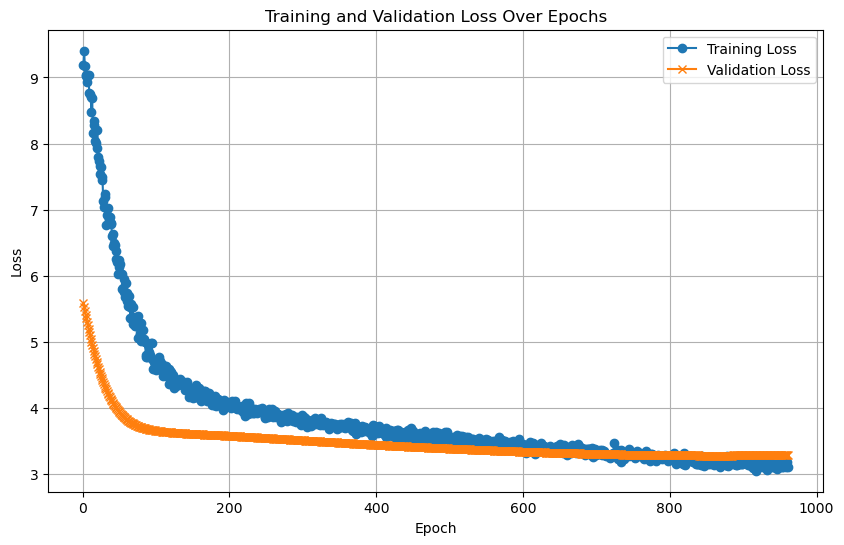

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/40], Loss: 4.8900
Test Batch [20/40], Loss: 4.8733
Test Batch [30/40], Loss: 5.3996
Test Batch [40/40], Loss: 5.2290

Test Loss: 5.1409


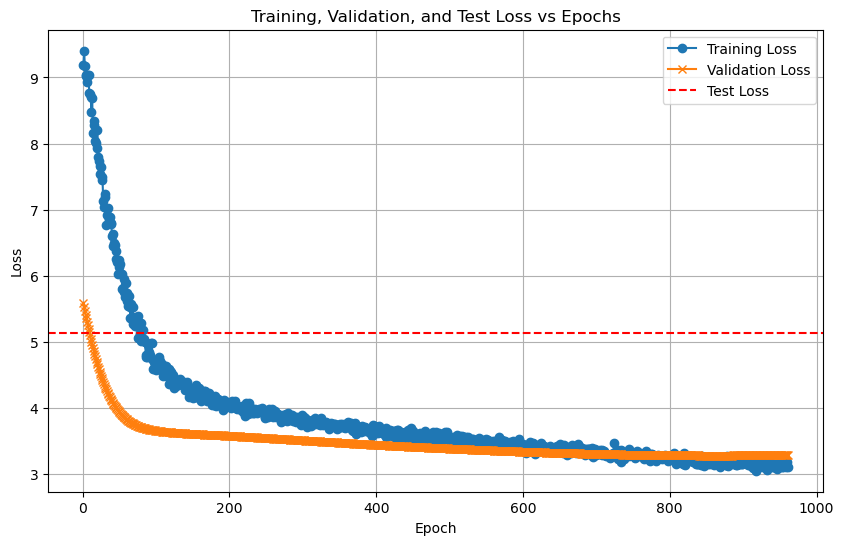

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/40 for test dataset.
  Processed batch 20/40 for test dataset.


  Processed batch 30/40 for test dataset.
  Processed batch 40/40 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.25      0.20      0.22         5
           2       0.00      0.00      0.00         5
           3       0.38      0.60      0.46         5
           4       0.33      0.40      0.36         5
           5       1.00      0.20      0.33         5
           6       0.83      1.00      0.91         5
           7       0.33      0.40      0.36         5
           8       0.83      1.00      0.91         5
           9       0.38      0.60      0.46         5
          10       0.50      0.20      0.29         5
          11       0.20      0.20      0.20         5
          12       0.62      1.00      0.77         5
          13       0.7

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8358  |  Val Loss: 2.8269
Validation loss improved from inf to 2.8269.
[Epoch 2/1000] Train Loss: 2.8261  |  Val Loss: 2.8191
Validation loss improved from 2.8269 to 2.8191.
[Epoch 3/1000] Train Loss: 2.8164  |  Val Loss: 2.8119
Validation loss improved from 2.8191 to 2.8119.
[Epoch 4/1000] Train Loss: 2.8077  |  Val Loss: 2.8051
Validation loss improved from 2.8119 to 2.8051.
[Epoch 5/1000] Train Loss: 2.7982  |  Val Loss: 2.7987
Validation loss improved from 2.8051 to 2.7987.
[Epoch 6/1000] Train Loss: 2.7910  |  Val Loss: 2.7927
Validation loss improved from 2.7987 to 2.7927.
[Epoch 7/1000] Train Loss: 2.7834  |  Val Loss: 2.7874
Validation loss improved from 2.7927 to 2.7874.
[Epoch 8/1000] Train Loss: 2.7761  |  Val Loss: 2.7822
Validation loss improved from 2.7874 to 2.7822.
[Epoch 9/1000] Train Loss: 2.7690  |  Val Loss: 2.7773
Validation loss improved from 2.7822 to 2.7773.
[Epoch 10/1000] Train Loss: 2.7619  |  Val Loss: 2.7727
Validation loss impr

[Epoch 22/1000] Train Loss: 2.6896  |  Val Loss: 2.7187
Validation loss improved from 2.7229 to 2.7187.
[Epoch 23/1000] Train Loss: 2.6842  |  Val Loss: 2.7146
Validation loss improved from 2.7187 to 2.7146.
[Epoch 24/1000] Train Loss: 2.6785  |  Val Loss: 2.7106
Validation loss improved from 2.7146 to 2.7106.
[Epoch 25/1000] Train Loss: 2.6727  |  Val Loss: 2.7065
Validation loss improved from 2.7106 to 2.7065.
[Epoch 26/1000] Train Loss: 2.6674  |  Val Loss: 2.7025
Validation loss improved from 2.7065 to 2.7025.
[Epoch 27/1000] Train Loss: 2.6618  |  Val Loss: 2.6985
Validation loss improved from 2.7025 to 2.6985.
[Epoch 28/1000] Train Loss: 2.6564  |  Val Loss: 2.6945
Validation loss improved from 2.6985 to 2.6945.
[Epoch 29/1000] Train Loss: 2.6512  |  Val Loss: 2.6906
Validation loss improved from 2.6945 to 2.6906.
[Epoch 30/1000] Train Loss: 2.6459  |  Val Loss: 2.6868
Validation loss improved from 2.6906 to 2.6868.
[Epoch 31/1000] Train Loss: 2.6411  |  Val Loss: 2.6831
Validati

[Epoch 37/1000] Train Loss: 2.6128  |  Val Loss: 2.6622
Validation loss improved from 2.6658 to 2.6622.


[Epoch 38/1000] Train Loss: 2.6077  |  Val Loss: 2.6585
Validation loss improved from 2.6622 to 2.6585.
[Epoch 39/1000] Train Loss: 2.6028  |  Val Loss: 2.6548
Validation loss improved from 2.6585 to 2.6548.
[Epoch 40/1000] Train Loss: 2.5983  |  Val Loss: 2.6510
Validation loss improved from 2.6548 to 2.6510.
[Epoch 41/1000] Train Loss: 2.5935  |  Val Loss: 2.6473
Validation loss improved from 2.6510 to 2.6473.
[Epoch 42/1000] Train Loss: 2.5886  |  Val Loss: 2.6437
Validation loss improved from 2.6473 to 2.6437.
[Epoch 43/1000] Train Loss: 2.5835  |  Val Loss: 2.6400
Validation loss improved from 2.6437 to 2.6400.
[Epoch 44/1000] Train Loss: 2.5789  |  Val Loss: 2.6361
Validation loss improved from 2.6400 to 2.6361.
[Epoch 45/1000] Train Loss: 2.5743  |  Val Loss: 2.6324
Validation loss improved from 2.6361 to 2.6324.
[Epoch 46/1000] Train Loss: 2.5693  |  Val Loss: 2.6288
Validation loss improved from 2.6324 to 2.6288.
[Epoch 47/1000] Train Loss: 2.5646  |  Val Loss: 2.6253
Validati

[Epoch 64/1000] Train Loss: 2.4862  |  Val Loss: 2.5633
Validation loss improved from 2.5668 to 2.5633.
[Epoch 65/1000] Train Loss: 2.4814  |  Val Loss: 2.5599
Validation loss improved from 2.5633 to 2.5599.
[Epoch 66/1000] Train Loss: 2.4769  |  Val Loss: 2.5565
Validation loss improved from 2.5599 to 2.5565.
[Epoch 67/1000] Train Loss: 2.4722  |  Val Loss: 2.5530
Validation loss improved from 2.5565 to 2.5530.
[Epoch 68/1000] Train Loss: 2.4676  |  Val Loss: 2.5495
Validation loss improved from 2.5530 to 2.5495.
[Epoch 69/1000] Train Loss: 2.4631  |  Val Loss: 2.5460
Validation loss improved from 2.5495 to 2.5460.
[Epoch 70/1000] Train Loss: 2.4585  |  Val Loss: 2.5425
Validation loss improved from 2.5460 to 2.5425.
[Epoch 71/1000] Train Loss: 2.4540  |  Val Loss: 2.5390
Validation loss improved from 2.5425 to 2.5390.
[Epoch 72/1000] Train Loss: 2.4497  |  Val Loss: 2.5353
Validation loss improved from 2.5390 to 2.5353.
[Epoch 73/1000] Train Loss: 2.4449  |  Val Loss: 2.5316
Validati

[Epoch 81/1000] Train Loss: 2.4071  |  Val Loss: 2.5002
Validation loss improved from 2.5045 to 2.5002.
[Epoch 82/1000] Train Loss: 2.4026  |  Val Loss: 2.4960
Validation loss improved from 2.5002 to 2.4960.
[Epoch 83/1000] Train Loss: 2.3975  |  Val Loss: 2.4918
Validation loss improved from 2.4960 to 2.4918.
[Epoch 84/1000] Train Loss: 2.3925  |  Val Loss: 2.4876
Validation loss improved from 2.4918 to 2.4876.
[Epoch 85/1000] Train Loss: 2.3873  |  Val Loss: 2.4834
Validation loss improved from 2.4876 to 2.4834.
[Epoch 86/1000] Train Loss: 2.3823  |  Val Loss: 2.4791
Validation loss improved from 2.4834 to 2.4791.
[Epoch 87/1000] Train Loss: 2.3773  |  Val Loss: 2.4748
Validation loss improved from 2.4791 to 2.4748.
[Epoch 88/1000] Train Loss: 2.3723  |  Val Loss: 2.4707
Validation loss improved from 2.4748 to 2.4707.
[Epoch 89/1000] Train Loss: 2.3670  |  Val Loss: 2.4665
Validation loss improved from 2.4707 to 2.4665.
[Epoch 90/1000] Train Loss: 2.3619  |  Val Loss: 2.4621
Validati

[Epoch 105/1000] Train Loss: 2.2829  |  Val Loss: 2.3975
Validation loss improved from 2.4019 to 2.3975.
[Epoch 106/1000] Train Loss: 2.2778  |  Val Loss: 2.3928
Validation loss improved from 2.3975 to 2.3928.
[Epoch 107/1000] Train Loss: 2.2725  |  Val Loss: 2.3881
Validation loss improved from 2.3928 to 2.3881.
[Epoch 108/1000] Train Loss: 2.2670  |  Val Loss: 2.3834
Validation loss improved from 2.3881 to 2.3834.
[Epoch 109/1000] Train Loss: 2.2614  |  Val Loss: 2.3787
Validation loss improved from 2.3834 to 2.3787.
[Epoch 110/1000] Train Loss: 2.2559  |  Val Loss: 2.3742
Validation loss improved from 2.3787 to 2.3742.
[Epoch 111/1000] Train Loss: 2.2503  |  Val Loss: 2.3696
Validation loss improved from 2.3742 to 2.3696.
[Epoch 112/1000] Train Loss: 2.2447  |  Val Loss: 2.3648
Validation loss improved from 2.3696 to 2.3648.
[Epoch 113/1000] Train Loss: 2.2391  |  Val Loss: 2.3600
Validation loss improved from 2.3648 to 2.3600.
[Epoch 114/1000] Train Loss: 2.2333  |  Val Loss: 2.355

[Epoch 122/1000] Train Loss: 2.1841  |  Val Loss: 2.3130
Validation loss improved from 2.3185 to 2.3130.
[Epoch 123/1000] Train Loss: 2.1778  |  Val Loss: 2.3076
Validation loss improved from 2.3130 to 2.3076.
[Epoch 124/1000] Train Loss: 2.1718  |  Val Loss: 2.3023
Validation loss improved from 2.3076 to 2.3023.
[Epoch 125/1000] Train Loss: 2.1657  |  Val Loss: 2.2966
Validation loss improved from 2.3023 to 2.2966.
[Epoch 126/1000] Train Loss: 2.1592  |  Val Loss: 2.2908
Validation loss improved from 2.2966 to 2.2908.
[Epoch 127/1000] Train Loss: 2.1527  |  Val Loss: 2.2849
Validation loss improved from 2.2908 to 2.2849.
[Epoch 128/1000] Train Loss: 2.1460  |  Val Loss: 2.2785
Validation loss improved from 2.2849 to 2.2785.
[Epoch 129/1000] Train Loss: 2.1393  |  Val Loss: 2.2720
Validation loss improved from 2.2785 to 2.2720.
[Epoch 130/1000] Train Loss: 2.1322  |  Val Loss: 2.2658
Validation loss improved from 2.2720 to 2.2658.
[Epoch 131/1000] Train Loss: 2.1253  |  Val Loss: 2.260

[Epoch 145/1000] Train Loss: 2.0268  |  Val Loss: 2.1876
Validation loss improved from 2.1925 to 2.1876.
[Epoch 146/1000] Train Loss: 2.0198  |  Val Loss: 2.1825
Validation loss improved from 2.1876 to 2.1825.
[Epoch 147/1000] Train Loss: 2.0130  |  Val Loss: 2.1775
Validation loss improved from 2.1825 to 2.1775.
[Epoch 148/1000] Train Loss: 2.0061  |  Val Loss: 2.1723
Validation loss improved from 2.1775 to 2.1723.
[Epoch 149/1000] Train Loss: 1.9994  |  Val Loss: 2.1672
Validation loss improved from 2.1723 to 2.1672.
[Epoch 150/1000] Train Loss: 1.9924  |  Val Loss: 2.1622
Validation loss improved from 2.1672 to 2.1622.
[Epoch 151/1000] Train Loss: 1.9857  |  Val Loss: 2.1571
Validation loss improved from 2.1622 to 2.1571.
[Epoch 152/1000] Train Loss: 1.9790  |  Val Loss: 2.1518
Validation loss improved from 2.1571 to 2.1518.
[Epoch 153/1000] Train Loss: 1.9720  |  Val Loss: 2.1467
Validation loss improved from 2.1518 to 2.1467.
[Epoch 154/1000] Train Loss: 1.9656  |  Val Loss: 2.141

[Epoch 162/1000] Train Loss: 1.9156  |  Val Loss: 2.0988
Validation loss improved from 2.1035 to 2.0988.
[Epoch 163/1000] Train Loss: 1.9094  |  Val Loss: 2.0941
Validation loss improved from 2.0988 to 2.0941.
[Epoch 164/1000] Train Loss: 1.9034  |  Val Loss: 2.0897
Validation loss improved from 2.0941 to 2.0897.
[Epoch 165/1000] Train Loss: 1.8972  |  Val Loss: 2.0854
Validation loss improved from 2.0897 to 2.0854.
[Epoch 166/1000] Train Loss: 1.8913  |  Val Loss: 2.0810
Validation loss improved from 2.0854 to 2.0810.
[Epoch 167/1000] Train Loss: 1.8853  |  Val Loss: 2.0764
Validation loss improved from 2.0810 to 2.0764.
[Epoch 168/1000] Train Loss: 1.8798  |  Val Loss: 2.0718
Validation loss improved from 2.0764 to 2.0718.
[Epoch 169/1000] Train Loss: 1.8735  |  Val Loss: 2.0672
Validation loss improved from 2.0718 to 2.0672.
[Epoch 170/1000] Train Loss: 1.8677  |  Val Loss: 2.0627
Validation loss improved from 2.0672 to 2.0627.
[Epoch 171/1000] Train Loss: 1.8618  |  Val Loss: 2.058

[Epoch 180/1000] Train Loss: 1.8110  |  Val Loss: 2.0206
Validation loss improved from 2.0246 to 2.0206.
[Epoch 181/1000] Train Loss: 1.8055  |  Val Loss: 2.0168
Validation loss improved from 2.0206 to 2.0168.
[Epoch 182/1000] Train Loss: 1.7995  |  Val Loss: 2.0130
Validation loss improved from 2.0168 to 2.0130.
[Epoch 183/1000] Train Loss: 1.7939  |  Val Loss: 2.0091
Validation loss improved from 2.0130 to 2.0091.
[Epoch 184/1000] Train Loss: 1.7884  |  Val Loss: 2.0052
Validation loss improved from 2.0091 to 2.0052.
[Epoch 185/1000] Train Loss: 1.7830  |  Val Loss: 2.0012
Validation loss improved from 2.0052 to 2.0012.
[Epoch 186/1000] Train Loss: 1.7774  |  Val Loss: 1.9970
Validation loss improved from 2.0012 to 1.9970.
[Epoch 187/1000] Train Loss: 1.7720  |  Val Loss: 1.9925
Validation loss improved from 1.9970 to 1.9925.
[Epoch 188/1000] Train Loss: 1.7668  |  Val Loss: 1.9879
Validation loss improved from 1.9925 to 1.9879.
[Epoch 189/1000] Train Loss: 1.7612  |  Val Loss: 1.983

[Epoch 198/1000] Train Loss: 1.7145  |  Val Loss: 1.9504
Validation loss improved from 1.9530 to 1.9504.
[Epoch 199/1000] Train Loss: 1.7092  |  Val Loss: 1.9474
Validation loss improved from 1.9504 to 1.9474.
[Epoch 200/1000] Train Loss: 1.7051  |  Val Loss: 1.9444
Validation loss improved from 1.9474 to 1.9444.
[Epoch 201/1000] Train Loss: 1.7000  |  Val Loss: 1.9411
Validation loss improved from 1.9444 to 1.9411.
[Epoch 202/1000] Train Loss: 1.6951  |  Val Loss: 1.9374
Validation loss improved from 1.9411 to 1.9374.
[Epoch 203/1000] Train Loss: 1.6902  |  Val Loss: 1.9335
Validation loss improved from 1.9374 to 1.9335.
[Epoch 204/1000] Train Loss: 1.6854  |  Val Loss: 1.9296
Validation loss improved from 1.9335 to 1.9296.
[Epoch 205/1000] Train Loss: 1.6804  |  Val Loss: 1.9256
Validation loss improved from 1.9296 to 1.9256.
[Epoch 206/1000] Train Loss: 1.6755  |  Val Loss: 1.9217
Validation loss improved from 1.9256 to 1.9217.
[Epoch 207/1000] Train Loss: 1.6705  |  Val Loss: 1.918

[Epoch 221/1000] Train Loss: 1.6033  |  Val Loss: 1.8700
Validation loss improved from 1.8733 to 1.8700.
[Epoch 222/1000] Train Loss: 1.5988  |  Val Loss: 1.8667
Validation loss improved from 1.8700 to 1.8667.
[Epoch 223/1000] Train Loss: 1.5942  |  Val Loss: 1.8634
Validation loss improved from 1.8667 to 1.8634.
[Epoch 224/1000] Train Loss: 1.5896  |  Val Loss: 1.8601
Validation loss improved from 1.8634 to 1.8601.
[Epoch 225/1000] Train Loss: 1.5847  |  Val Loss: 1.8567
Validation loss improved from 1.8601 to 1.8567.
[Epoch 226/1000] Train Loss: 1.5803  |  Val Loss: 1.8533
Validation loss improved from 1.8567 to 1.8533.
[Epoch 227/1000] Train Loss: 1.5762  |  Val Loss: 1.8501
Validation loss improved from 1.8533 to 1.8501.
[Epoch 228/1000] Train Loss: 1.5717  |  Val Loss: 1.8470
Validation loss improved from 1.8501 to 1.8470.
[Epoch 229/1000] Train Loss: 1.5675  |  Val Loss: 1.8441
Validation loss improved from 1.8470 to 1.8441.
[Epoch 230/1000] Train Loss: 1.5631  |  Val Loss: 1.841

[Epoch 236/1000] Train Loss: 1.5367  |  Val Loss: 1.8270
Validation loss improved from 1.8284 to 1.8270.
[Epoch 237/1000] Train Loss: 1.5327  |  Val Loss: 1.8253
Validation loss improved from 1.8270 to 1.8253.
[Epoch 238/1000] Train Loss: 1.5288  |  Val Loss: 1.8228
Validation loss improved from 1.8253 to 1.8228.
[Epoch 239/1000] Train Loss: 1.5245  |  Val Loss: 1.8199
Validation loss improved from 1.8228 to 1.8199.
[Epoch 240/1000] Train Loss: 1.5199  |  Val Loss: 1.8165
Validation loss improved from 1.8199 to 1.8165.
[Epoch 241/1000] Train Loss: 1.5156  |  Val Loss: 1.8131
Validation loss improved from 1.8165 to 1.8131.
[Epoch 242/1000] Train Loss: 1.5106  |  Val Loss: 1.8100
Validation loss improved from 1.8131 to 1.8100.
[Epoch 243/1000] Train Loss: 1.5062  |  Val Loss: 1.8071
Validation loss improved from 1.8100 to 1.8071.
[Epoch 244/1000] Train Loss: 1.5019  |  Val Loss: 1.8043
Validation loss improved from 1.8071 to 1.8043.
[Epoch 245/1000] Train Loss: 1.4974  |  Val Loss: 1.801

[Epoch 262/1000] Train Loss: 1.4263  |  Val Loss: 1.7543
Validation loss improved from 1.7573 to 1.7543.
[Epoch 263/1000] Train Loss: 1.4223  |  Val Loss: 1.7518
Validation loss improved from 1.7543 to 1.7518.
[Epoch 264/1000] Train Loss: 1.4184  |  Val Loss: 1.7495
Validation loss improved from 1.7518 to 1.7495.
[Epoch 265/1000] Train Loss: 1.4142  |  Val Loss: 1.7472
Validation loss improved from 1.7495 to 1.7472.
[Epoch 266/1000] Train Loss: 1.4104  |  Val Loss: 1.7451
Validation loss improved from 1.7472 to 1.7451.
[Epoch 267/1000] Train Loss: 1.4063  |  Val Loss: 1.7429
Validation loss improved from 1.7451 to 1.7429.
[Epoch 268/1000] Train Loss: 1.4017  |  Val Loss: 1.7407
Validation loss improved from 1.7429 to 1.7407.
[Epoch 269/1000] Train Loss: 1.3979  |  Val Loss: 1.7391
Validation loss improved from 1.7407 to 1.7391.
[Epoch 270/1000] Train Loss: 1.3939  |  Val Loss: 1.7374
Validation loss improved from 1.7391 to 1.7374.
[Epoch 271/1000] Train Loss: 1.3896  |  Val Loss: 1.735

[Epoch 275/1000] Train Loss: 1.3750  |  Val Loss: 1.7279
Validation loss improved from 1.7297 to 1.7279.
[Epoch 276/1000] Train Loss: 1.3712  |  Val Loss: 1.7261
Validation loss improved from 1.7279 to 1.7261.
[Epoch 277/1000] Train Loss: 1.3672  |  Val Loss: 1.7242
Validation loss improved from 1.7261 to 1.7242.
[Epoch 278/1000] Train Loss: 1.3633  |  Val Loss: 1.7219
Validation loss improved from 1.7242 to 1.7219.
[Epoch 279/1000] Train Loss: 1.3597  |  Val Loss: 1.7192
Validation loss improved from 1.7219 to 1.7192.
[Epoch 280/1000] Train Loss: 1.3554  |  Val Loss: 1.7166
Validation loss improved from 1.7192 to 1.7166.
[Epoch 281/1000] Train Loss: 1.3515  |  Val Loss: 1.7142
Validation loss improved from 1.7166 to 1.7142.
[Epoch 282/1000] Train Loss: 1.3478  |  Val Loss: 1.7115
Validation loss improved from 1.7142 to 1.7115.
[Epoch 283/1000] Train Loss: 1.3435  |  Val Loss: 1.7081
Validation loss improved from 1.7115 to 1.7081.
[Epoch 284/1000] Train Loss: 1.3399  |  Val Loss: 1.704

[Epoch 306/1000] Train Loss: 1.2617  |  Val Loss: 1.6631
Validation loss improved from 1.6641 to 1.6631.
[Epoch 307/1000] Train Loss: 1.2593  |  Val Loss: 1.6619
Validation loss improved from 1.6631 to 1.6619.
[Epoch 308/1000] Train Loss: 1.2555  |  Val Loss: 1.6604
Validation loss improved from 1.6619 to 1.6604.
[Epoch 309/1000] Train Loss: 1.2519  |  Val Loss: 1.6586
Validation loss improved from 1.6604 to 1.6586.
[Epoch 310/1000] Train Loss: 1.2478  |  Val Loss: 1.6565
Validation loss improved from 1.6586 to 1.6565.
[Epoch 311/1000] Train Loss: 1.2438  |  Val Loss: 1.6538
Validation loss improved from 1.6565 to 1.6538.
[Epoch 312/1000] Train Loss: 1.2396  |  Val Loss: 1.6510
Validation loss improved from 1.6538 to 1.6510.
[Epoch 313/1000] Train Loss: 1.2359  |  Val Loss: 1.6481
Validation loss improved from 1.6510 to 1.6481.
[Epoch 314/1000] Train Loss: 1.2328  |  Val Loss: 1.6448
Validation loss improved from 1.6481 to 1.6448.
[Epoch 315/1000] Train Loss: 1.2292  |  Val Loss: 1.641

[Epoch 317/1000] Train Loss: 1.2227  |  Val Loss: 1.6361
Validation loss improved from 1.6385 to 1.6361.
[Epoch 318/1000] Train Loss: 1.2191  |  Val Loss: 1.6340
Validation loss improved from 1.6361 to 1.6340.
[Epoch 319/1000] Train Loss: 1.2162  |  Val Loss: 1.6327
Validation loss improved from 1.6340 to 1.6327.
[Epoch 320/1000] Train Loss: 1.2124  |  Val Loss: 1.6319
Validation loss improved from 1.6327 to 1.6319.
[Epoch 321/1000] Train Loss: 1.2089  |  Val Loss: 1.6314
Validation loss improved from 1.6319 to 1.6314.
[Epoch 322/1000] Train Loss: 1.2061  |  Val Loss: 1.6308
Validation loss improved from 1.6314 to 1.6308.
[Epoch 323/1000] Train Loss: 1.2035  |  Val Loss: 1.6295
Validation loss improved from 1.6308 to 1.6295.
[Epoch 324/1000] Train Loss: 1.2009  |  Val Loss: 1.6278
Validation loss improved from 1.6295 to 1.6278.
[Epoch 325/1000] Train Loss: 1.1977  |  Val Loss: 1.6251
Validation loss improved from 1.6278 to 1.6251.
[Epoch 326/1000] Train Loss: 1.1943  |  Val Loss: 1.622

[Epoch 347/1000] Train Loss: 1.1289  |  Val Loss: 1.5950
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 348/1000] Train Loss: 1.1265  |  Val Loss: 1.5949
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 349/1000] Train Loss: 1.1243  |  Val Loss: 1.5942
Validation loss improved from 1.5946 to 1.5942.
[Epoch 350/1000] Train Loss: 1.1209  |  Val Loss: 1.5929
Validation loss improved from 1.5942 to 1.5929.
[Epoch 351/1000] Train Loss: 1.1179  |  Val Loss: 1.5905
Validation loss improved from 1.5929 to 1.5905.
[Epoch 352/1000] Train Loss: 1.1151  |  Val Loss: 1.5871
Validation loss improved from 1.5905 to 1.5871.
[Epoch 353/1000] Train Loss: 1.1121  |  Val Loss: 1.5845
Validation loss improved from 1.5871 to 1.5845.
[Epoch 354/1000] Train Loss: 1.1093  |  Val Loss: 1.5831
Validation loss improved from 1.5845 to 1.5831.
[Epoch 355/1000] Train Loss: 1.1064  |  Val Loss: 1.5819
Validation loss improved from 1.5831 to 1.5819.
[Epoch 356/1000] Train Loss: 1.1035  |  Val

[Epoch 358/1000] Train Loss: 1.0982  |  Val Loss: 1.5778
Validation loss improved from 1.5791 to 1.5778.
[Epoch 359/1000] Train Loss: 1.0962  |  Val Loss: 1.5774
Validation loss improved from 1.5778 to 1.5774.
[Epoch 360/1000] Train Loss: 1.0942  |  Val Loss: 1.5777
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 361/1000] Train Loss: 1.0915  |  Val Loss: 1.5775
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 362/1000] Train Loss: 1.0890  |  Val Loss: 1.5766
Validation loss improved from 1.5774 to 1.5766.
[Epoch 363/1000] Train Loss: 1.0859  |  Val Loss: 1.5750
Validation loss improved from 1.5766 to 1.5750.
[Epoch 364/1000] Train Loss: 1.0832  |  Val Loss: 1.5734
Validation loss improved from 1.5750 to 1.5734.
[Epoch 365/1000] Train Loss: 1.0804  |  Val Loss: 1.5720
Validation loss improved from 1.5734 to 1.5720.
[Epoch 366/1000] Train Loss: 1.0777  |  Val Loss: 1.5701
Validation loss improved from 1.5720 to 1.5701.
[Epoch 367/1000] Train Loss: 1.0750  |  Val

[Epoch 390/1000] Train Loss: 1.0209  |  Val Loss: 1.5470
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 391/1000] Train Loss: 1.0191  |  Val Loss: 1.5468
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 392/1000] Train Loss: 1.0170  |  Val Loss: 1.5457
Validation loss improved from 1.5466 to 1.5457.
[Epoch 393/1000] Train Loss: 1.0148  |  Val Loss: 1.5443
Validation loss improved from 1.5457 to 1.5443.
[Epoch 394/1000] Train Loss: 1.0120  |  Val Loss: 1.5430
Validation loss improved from 1.5443 to 1.5430.
[Epoch 395/1000] Train Loss: 1.0094  |  Val Loss: 1.5418
Validation loss improved from 1.5430 to 1.5418.
[Epoch 396/1000] Train Loss: 1.0070  |  Val Loss: 1.5407
Validation loss improved from 1.5418 to 1.5407.


[Epoch 397/1000] Train Loss: 1.0046  |  Val Loss: 1.5393
Validation loss improved from 1.5407 to 1.5393.
[Epoch 398/1000] Train Loss: 1.0026  |  Val Loss: 1.5380
Validation loss improved from 1.5393 to 1.5380.
[Epoch 399/1000] Train Loss: 1.0006  |  Val Loss: 1.5373
Validation loss improved from 1.5380 to 1.5373.
[Epoch 400/1000] Train Loss: 0.9983  |  Val Loss: 1.5376
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 401/1000] Train Loss: 0.9961  |  Val Loss: 1.5387
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 402/1000] Train Loss: 0.9938  |  Val Loss: 1.5408
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 403/1000] Train Loss: 0.9929  |  Val Loss: 1.5424
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 404/1000] Train Loss: 0.9908  |  Val Loss: 1.5429
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 405/1000] Train Loss: 0.9882  |  Val Loss: 1.5432
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 406/1000] Tr

[Epoch 428/1000] Train Loss: 0.9425  |  Val Loss: 1.5190
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 429/1000] Train Loss: 0.9409  |  Val Loss: 1.5192
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 430/1000] Train Loss: 0.9391  |  Val Loss: 1.5189
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 431/1000] Train Loss: 0.9375  |  Val Loss: 1.5186
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 432/1000] Train Loss: 0.9355  |  Val Loss: 1.5184
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 433/1000] Train Loss: 0.9343  |  Val Loss: 1.5177
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 434/1000] Train Loss: 0.9323  |  Val Loss: 1.5172
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 435/1000] Train Loss: 0.9302  |  Val Loss: 1.5173
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 436/1000] Train Loss: 0.9282  |  Val Loss: 1.5161
Validation loss improved from 1.5163 to 1.5161.
[E

[Epoch 439/1000] Train Loss: 0.9226  |  Val Loss: 1.5113
Validation loss improved from 1.5126 to 1.5113.
[Epoch 440/1000] Train Loss: 0.9205  |  Val Loss: 1.5094
Validation loss improved from 1.5113 to 1.5094.
[Epoch 441/1000] Train Loss: 0.9189  |  Val Loss: 1.5076
Validation loss improved from 1.5094 to 1.5076.
[Epoch 442/1000] Train Loss: 0.9174  |  Val Loss: 1.5071
Validation loss improved from 1.5076 to 1.5071.
[Epoch 443/1000] Train Loss: 0.9159  |  Val Loss: 1.5071
Validation loss improved from 1.5071 to 1.5071.
[Epoch 444/1000] Train Loss: 0.9143  |  Val Loss: 1.5064
Validation loss improved from 1.5071 to 1.5064.
[Epoch 445/1000] Train Loss: 0.9127  |  Val Loss: 1.5065
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 446/1000] Train Loss: 0.9110  |  Val Loss: 1.5072
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 447/1000] Train Loss: 0.9091  |  Val Loss: 1.5078
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 448/1000] Train Loss: 0.9081  

[Epoch 463/1000] Train Loss: 0.8817  |  Val Loss: 1.5019
Validation loss improved from 1.5021 to 1.5019.
[Epoch 464/1000] Train Loss: 0.8798  |  Val Loss: 1.5011
Validation loss improved from 1.5019 to 1.5011.
[Epoch 465/1000] Train Loss: 0.8775  |  Val Loss: 1.5009
Validation loss improved from 1.5011 to 1.5009.
[Epoch 466/1000] Train Loss: 0.8759  |  Val Loss: 1.5005
Validation loss improved from 1.5009 to 1.5005.
[Epoch 467/1000] Train Loss: 0.8742  |  Val Loss: 1.4997
Validation loss improved from 1.5005 to 1.4997.
[Epoch 468/1000] Train Loss: 0.8728  |  Val Loss: 1.4996
Validation loss improved from 1.4997 to 1.4996.
[Epoch 469/1000] Train Loss: 0.8710  |  Val Loss: 1.5000
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 470/1000] Train Loss: 0.8692  |  Val Loss: 1.5007
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 471/1000] Train Loss: 0.8677  |  Val Loss: 1.5020
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 472/1000] Train Loss: 0.8666  

[Epoch 483/1000] Train Loss: 0.8500  |  Val Loss: 1.4834
Validation loss improved from 1.4848 to 1.4834.
[Epoch 484/1000] Train Loss: 0.8480  |  Val Loss: 1.4838
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 485/1000] Train Loss: 0.8466  |  Val Loss: 1.4848
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 486/1000] Train Loss: 0.8449  |  Val Loss: 1.4862
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 487/1000] Train Loss: 0.8432  |  Val Loss: 1.4875
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 488/1000] Train Loss: 0.8424  |  Val Loss: 1.4879
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 489/1000] Train Loss: 0.8411  |  Val Loss: 1.4876
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 490/1000] Train Loss: 0.8400  |  Val Loss: 1.4877
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 491/1000] Train Loss: 0.8393  |  Val Loss: 1.4877
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 504/1000] Train Loss: 0.8194  |  Val Loss: 1.4879
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 505/1000] Train Loss: 0.8185  |  Val Loss: 1.4871
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 506/1000] Train Loss: 0.8168  |  Val Loss: 1.4866
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 507/1000] Train Loss: 0.8148  |  Val Loss: 1.4870
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 508/1000] Train Loss: 0.8140  |  Val Loss: 1.4870
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 509/1000] Train Loss: 0.8119  |  Val Loss: 1.4868
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 510/1000] Train Loss: 0.8108  |  Val Loss: 1.4864
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 511/1000] Train Loss: 0.8098  |  Val Loss: 1.4864
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 512/1000] Train Loss: 0.8086  |  Val Loss: 1.4869
!! Validation loss did NOT improve !! Patience:

[Epoch 524/1000] Train Loss: 0.7919  |  Val Loss: 1.4819
Validation loss improved from 1.4832 to 1.4819.
[Epoch 525/1000] Train Loss: 0.7913  |  Val Loss: 1.4813
Validation loss improved from 1.4819 to 1.4813.
[Epoch 526/1000] Train Loss: 0.7893  |  Val Loss: 1.4812
Validation loss improved from 1.4813 to 1.4812.
[Epoch 527/1000] Train Loss: 0.7886  |  Val Loss: 1.4815
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 528/1000] Train Loss: 0.7881  |  Val Loss: 1.4817
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 529/1000] Train Loss: 0.7867  |  Val Loss: 1.4814
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 530/1000] Train Loss: 0.7853  |  Val Loss: 1.4808
Validation loss improved from 1.4812 to 1.4808.
[Epoch 531/1000] Train Loss: 0.7838  |  Val Loss: 1.4802
Validation loss improved from 1.4808 to 1.4802.
[Epoch 532/1000] Train Loss: 0.7822  |  Val Loss: 1.4792
Validation loss improved from 1.4802 to 1.4792.
[Epoch 533/1000] Train Loss: 0.7807  

[Epoch 548/1000] Train Loss: 0.7650  |  Val Loss: 1.4727
Validation loss improved from 1.4734 to 1.4727.
[Epoch 549/1000] Train Loss: 0.7637  |  Val Loss: 1.4719
Validation loss improved from 1.4727 to 1.4719.
[Epoch 550/1000] Train Loss: 0.7618  |  Val Loss: 1.4724
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 551/1000] Train Loss: 0.7598  |  Val Loss: 1.4748
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 552/1000] Train Loss: 0.7584  |  Val Loss: 1.4777
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 553/1000] Train Loss: 0.7569  |  Val Loss: 1.4801
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 554/1000] Train Loss: 0.7565  |  Val Loss: 1.4816
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 555/1000] Train Loss: 0.7556  |  Val Loss: 1.4818
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 556/1000] Train Loss: 0.7552  |  Val Loss: 1.4813
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 557/10

[Epoch 564/1000] Train Loss: 0.7452  |  Val Loss: 1.4731
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 565/1000] Train Loss: 0.7440  |  Val Loss: 1.4738
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 566/1000] Train Loss: 0.7428  |  Val Loss: 1.4749
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 567/1000] Train Loss: 0.7415  |  Val Loss: 1.4767
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 568/1000] Train Loss: 0.7408  |  Val Loss: 1.4789
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 569/1000] Train Loss: 0.7395  |  Val Loss: 1.4812
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 570/1000] Train Loss: 0.7386  |  Val Loss: 1.4844
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 571/1000] Train Loss: 0.7385  |  Val Loss: 1.4876
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 572/1000] Train Loss: 0.7382  |  Val Loss: 1.4891
!! Validation loss did NOT improve !! Patience:

[Epoch 589/1000] Train Loss: 0.7176  |  Val Loss: 1.4794
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 590/1000] Train Loss: 0.7167  |  Val Loss: 1.4797
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 591/1000] Train Loss: 0.7158  |  Val Loss: 1.4806
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 592/1000] Train Loss: 0.7147  |  Val Loss: 1.4819
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 593/1000] Train Loss: 0.7141  |  Val Loss: 1.4829
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 594/1000] Train Loss: 0.7132  |  Val Loss: 1.4827
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 595/1000] Train Loss: 0.7120  |  Val Loss: 1.4819
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 596/1000] Train Loss: 0.7105  |  Val Loss: 1.4803
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 597/1000] Train Loss: 0.7096  |  Val Loss: 1.4795
!! Validation loss did NOT improve !! Patience:

[Epoch 603/1000] Train Loss: 0.7035  |  Val Loss: 1.4802
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 604/1000] Train Loss: 0.7023  |  Val Loss: 1.4798
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 605/1000] Train Loss: 0.7011  |  Val Loss: 1.4785
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 606/1000] Train Loss: 0.6998  |  Val Loss: 1.4773
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 607/1000] Train Loss: 0.6998  |  Val Loss: 1.4769
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 608/1000] Train Loss: 0.6993  |  Val Loss: 1.4776
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 609/1000] Train Loss: 0.6982  |  Val Loss: 1.4788
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 610/1000] Train Loss: 0.6978  |  Val Loss: 1.4805
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 611/1000] Train Loss: 0.6974  |  Val Loss: 1.4814
!! Validation loss did NOT improve !! Patience:

[Epoch 630/1000] Train Loss: 0.6777  |  Val Loss: 1.4773
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 631/1000] Train Loss: 0.6766  |  Val Loss: 1.4774
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 632/1000] Train Loss: 0.6756  |  Val Loss: 1.4779
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 633/1000] Train Loss: 0.6750  |  Val Loss: 1.4788
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 634/1000] Train Loss: 0.6740  |  Val Loss: 1.4794
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 635/1000] Train Loss: 0.6736  |  Val Loss: 1.4798
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 636/1000] Train Loss: 0.6719  |  Val Loss: 1.4792
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 637/1000] Train Loss: 0.6710  |  Val Loss: 1.4786
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 638/1000] Train Loss: 0.6699  |  Val Loss: 1.4786
!! Validation loss did NOT improve !! Patience:

[Epoch 646/1000] Train Loss: 0.6644  |  Val Loss: 1.4807
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 647/1000] Train Loss: 0.6639  |  Val Loss: 1.4813
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 648/1000] Train Loss: 0.6632  |  Val Loss: 1.4825
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 649/1000] Train Loss: 0.6623  |  Val Loss: 1.4841
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 649 !!
No improvement for 100 epochs.


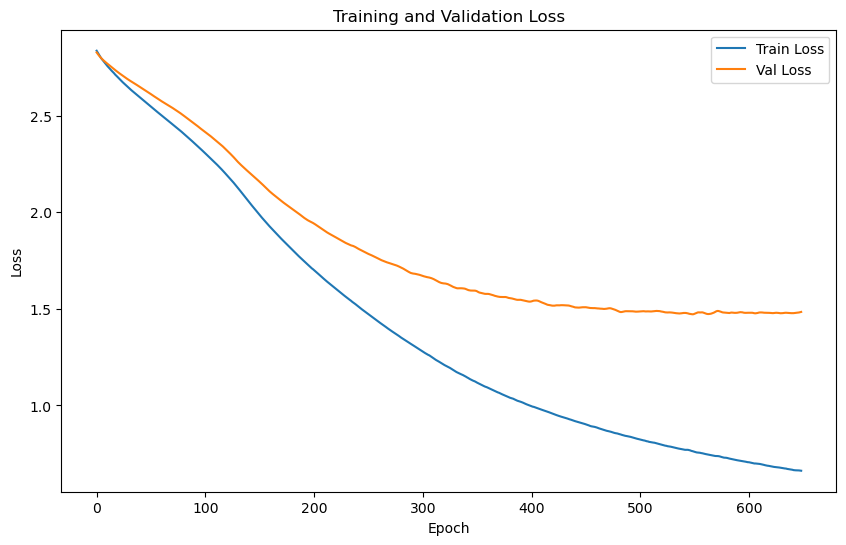

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.2293 | Test Accuracy: 38.29%


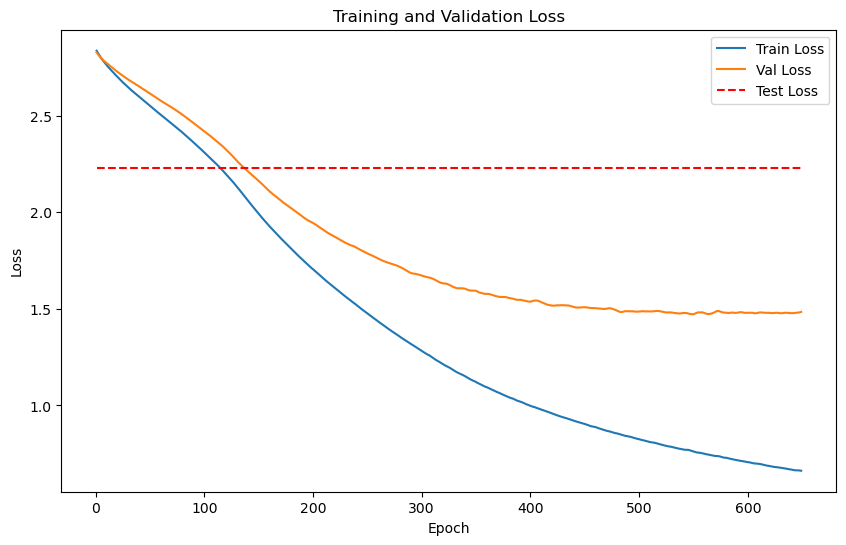

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 80 samples with 64 features each
LOG: Labels shape: (80,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 10089 samples with 64 features each
LOG: Labels shape: (10089,)


Train embeddings shape: (80, 64), 
Train labels shape: (80,)


Val embeddings shape: (80, 64), 
Val labels shape: (80,)


Test embeddings shape: (10089, 64), 
Test labels shape: (10089,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5, 14: 5, 15: 5}
Training batch size: 80


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5064
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.5266
    Batch [2/2], Val Loss: 0.3710
Epoch [1/2000], Avg Train Loss: 0.5064, Avg Val Loss: 0.4488

Validation loss improved from inf to 0.4488. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5092
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.3695
Epoch [2/2000], Avg Train Loss: 0.5092, Avg Val Loss: 0.4474

Validation loss improved from 0.4488 to 0.4474. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.5242
    Batch [2/2], Val Loss: 0.3691
Epoch [3/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.4466

Validation loss improved from 0.4474 to 0.4466. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.5058
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.3688
Epoch [4/2000], Avg Train Loss: 0.5058, Avg Val Loss: 0.4459

Validation loss improved from 0.4466 to 0.4459. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.3677
Epoch [5/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.4447

Validation loss improved from 0.4459 to 0.4447. Saving model...
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4991
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.3665
Epoch [6/2000], Avg Train Loss: 0.4991, Avg Val Loss: 0.4434

Validation loss improved from 0.4447 to 0.4434. Saving model...
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.5035
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.3654
Epoch [7/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.4418

Validation loss improved from 0.4434 to 0.4418. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5047
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5158
    Batch [2/2], Val Loss: 0.3646
Epoch [8/2000], Avg Train Loss: 0.5047, Avg Val Loss: 0.4402

Validation loss improved from 0.4418 to 0.4402. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5136
    Batch [2/2], Val Loss: 0.3635
Epoch [9/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.4386

Validation loss improved from 0.4402 to 0.4386. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.3623
Epoch [10/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.4368

Validation loss improved from 0.4386 to 0.4368. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.3607
Epoch [11/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.4348

Validation loss improved from 0.4368 to 0.4348. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.3589
Epoch [12/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.4329

Validation loss improved from 0.4348 to 0.4329. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.5001
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.3572
Epoch [13/2000], Avg Train Loss: 0.5001, Avg Val Loss: 0.4313

Validation loss improved from 0.4329 to 0.4313. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.3558
Epoch [14/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.4299

Validation loss improved from 0.4313 to 0.4299. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4976
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5028
    Batch [2/2], Val Loss: 0.3547
Epoch [15/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.4287

Validation loss improved from 0.4299 to 0.4287. Saving model...
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.3537
Epoch [16/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4276

Validation loss improved from 0.4287 to 0.4276. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4971
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.3530
Epoch [17/2000], Avg Train Loss: 0.4971, Avg Val Loss: 0.4267

Validation loss improved from 0.4276 to 0.4267. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4974
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.3523
Epoch [18/2000], Avg Train Loss: 0.4974, Avg Val Loss: 0.4257

Validation loss improved from 0.4267 to 0.4257. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.3517
Epoch [19/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.4247

Validation loss improved from 0.4257 to 0.4247. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4965
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.3512
Epoch [20/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.4239

Validation loss improved from 0.4247 to 0.4239. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.3507
Epoch [21/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4232

Validation loss improved from 0.4239 to 0.4232. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4970
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4951
    Batch [2/2], Val Loss: 0.3503
Epoch [22/2000], Avg Train Loss: 0.4970, Avg Val Loss: 0.4227

Validation loss improved from 0.4232 to 0.4227. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4989
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.3499
Epoch [23/2000], Avg Train Loss: 0.4989, Avg Val Loss: 0.4222

Validation loss improved from 0.4227 to 0.4222. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4979
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.3496
Epoch [24/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.4219

Validation loss improved from 0.4222 to 0.4219. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4918
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.3493
Epoch [25/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.4215

Validation loss improved from 0.4219 to 0.4215. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4910
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.3490
Epoch [26/2000], Avg Train Loss: 0.4910, Avg Val Loss: 0.4212

Validation loss improved from 0.4215 to 0.4212. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.3486
Epoch [27/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4208

Validation loss improved from 0.4212 to 0.4208. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4920
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.3484
Epoch [28/2000], Avg Train Loss: 0.4920, Avg Val Loss: 0.4206

Validation loss improved from 0.4208 to 0.4206. Saving model...
LOG: Epoch [29/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.3480
Epoch [29/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4203

Validation loss improved from 0.4206 to 0.4203. Saving model...
LOG: Epoch [30/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.3477
Epoch [30/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.4200

Validation loss improved from 0.4203 to 0.4200. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/1], Train Loss: 0.4858
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.3474
Epoch [31/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4197

Validation loss improved from 0.4200 to 0.4197. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.3470
Epoch [32/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.4195

Validation loss improved from 0.4197 to 0.4195. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.3466
Epoch [33/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4191

Validation loss improved from 0.4195 to 0.4191. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4914
    Batch [2/2], Val Loss: 0.3461
Epoch [34/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.4188

Validation loss improved from 0.4191 to 0.4188. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.3456
Epoch [35/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.4184

Validation loss improved from 0.4188 to 0.4184. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4913
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4910
    Batch [2/2], Val Loss: 0.3450
Epoch [36/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4180

Validation loss improved from 0.4184 to 0.4180. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.3444
Epoch [37/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.4176

Validation loss improved from 0.4180 to 0.4176. Saving model...
LOG: Epoch [38/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.3438
Epoch [38/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4172

Validation loss improved from 0.4176 to 0.4172. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/1], Train Loss: 0.4841
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.3432
Epoch [39/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4167

Validation loss improved from 0.4172 to 0.4167. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/1], Train Loss: 0.4893
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.4900
    Batch [2/2], Val Loss: 0.3426
Epoch [40/2000], Avg Train Loss: 0.4893, Avg Val Loss: 0.4163

Validation loss improved from 0.4167 to 0.4163. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.3420
Epoch [41/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4159

Validation loss improved from 0.4163 to 0.4159. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.4896
    Batch [2/2], Val Loss: 0.3414
Epoch [42/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4155

Validation loss improved from 0.4159 to 0.4155. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.3408
Epoch [43/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4151

Validation loss improved from 0.4155 to 0.4151. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.4822
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.3402
Epoch [44/2000], Avg Train Loss: 0.4822, Avg Val Loss: 0.4146

Validation loss improved from 0.4151 to 0.4146. Saving model...
LOG: Epoch [45/2000] - Training


    Batch [1/1], Train Loss: 0.4765
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.4889
    Batch [2/2], Val Loss: 0.3395
Epoch [45/2000], Avg Train Loss: 0.4765, Avg Val Loss: 0.4142

Validation loss improved from 0.4146 to 0.4142. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.3389
Epoch [46/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4138

Validation loss improved from 0.4142 to 0.4138. Saving model...
LOG: Epoch [47/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.3383
Epoch [47/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4134

Validation loss improved from 0.4138 to 0.4134. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4870
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4884
    Batch [2/2], Val Loss: 0.3378
Epoch [48/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4131

Validation loss improved from 0.4134 to 0.4131. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4837
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.3372
Epoch [49/2000], Avg Train Loss: 0.4837, Avg Val Loss: 0.4127

Validation loss improved from 0.4131 to 0.4127. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.3366
Epoch [50/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4123

Validation loss improved from 0.4127 to 0.4123. Saving model...
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.3360
Epoch [51/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.4119

Validation loss improved from 0.4123 to 0.4119. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4813
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.3354
Epoch [52/2000], Avg Train Loss: 0.4813, Avg Val Loss: 0.4115

Validation loss improved from 0.4119 to 0.4115. Saving model...
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4817
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.3348
Epoch [53/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4111

Validation loss improved from 0.4115 to 0.4111. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/1], Train Loss: 0.4820
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.3342
Epoch [54/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4107

Validation loss improved from 0.4111 to 0.4107. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.3336
Epoch [55/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4104

Validation loss improved from 0.4107 to 0.4104. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4825
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.3331
Epoch [56/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4100

Validation loss improved from 0.4104 to 0.4100. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4873
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.3326
Epoch [57/2000], Avg Train Loss: 0.4873, Avg Val Loss: 0.4097

Validation loss improved from 0.4100 to 0.4097. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.3321
Epoch [58/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4094

Validation loss improved from 0.4097 to 0.4094. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.3316
Epoch [59/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4091

Validation loss improved from 0.4094 to 0.4091. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4772
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.3312
Epoch [60/2000], Avg Train Loss: 0.4772, Avg Val Loss: 0.4088

Validation loss improved from 0.4091 to 0.4088. Saving model...
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4764
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.3308
Epoch [61/2000], Avg Train Loss: 0.4764, Avg Val Loss: 0.4085

Validation loss improved from 0.4088 to 0.4085. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4718
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.3304
Epoch [62/2000], Avg Train Loss: 0.4718, Avg Val Loss: 0.4082

Validation loss improved from 0.4085 to 0.4082. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.3300
Epoch [63/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4080

Validation loss improved from 0.4082 to 0.4080. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.3296
Epoch [64/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4077

Validation loss improved from 0.4080 to 0.4077. Saving model...
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4796
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.3292
Epoch [65/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4074

Validation loss improved from 0.4077 to 0.4074. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4753
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4854
    Batch [2/2], Val Loss: 0.3287
Epoch [66/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4071

Validation loss improved from 0.4074 to 0.4071. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.3283
Epoch [67/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4068

Validation loss improved from 0.4071 to 0.4068. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4804
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.3280
Epoch [68/2000], Avg Train Loss: 0.4804, Avg Val Loss: 0.4065

Validation loss improved from 0.4068 to 0.4065. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.3276
Epoch [69/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4062

Validation loss improved from 0.4065 to 0.4062. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4755
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.3272
Epoch [70/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.4060

Validation loss improved from 0.4062 to 0.4060. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4760
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.3268
Epoch [71/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4057

Validation loss improved from 0.4060 to 0.4057. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.3264
Epoch [72/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4055

Validation loss improved from 0.4057 to 0.4055. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4792
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.3261
Epoch [73/2000], Avg Train Loss: 0.4792, Avg Val Loss: 0.4053

Validation loss improved from 0.4055 to 0.4053. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.3258
Epoch [74/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4051

Validation loss improved from 0.4053 to 0.4051. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4746
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.3254
Epoch [75/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4049

Validation loss improved from 0.4051 to 0.4049. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.3250
Epoch [76/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4046

Validation loss improved from 0.4049 to 0.4046. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.3246
Epoch [77/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4044

Validation loss improved from 0.4046 to 0.4044. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4783
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.3242
Epoch [78/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4041

Validation loss improved from 0.4044 to 0.4041. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4666
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.3237
Epoch [79/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4038

Validation loss improved from 0.4041 to 0.4038. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.3231
Epoch [80/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4035

Validation loss improved from 0.4038 to 0.4035. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.3225
Epoch [81/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.4032

Validation loss improved from 0.4035 to 0.4032. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4715
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.3219
Epoch [82/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4028

Validation loss improved from 0.4032 to 0.4028. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4696
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.3213
Epoch [83/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4025

Validation loss improved from 0.4028 to 0.4025. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4759
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3208
Epoch [84/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4022

Validation loss improved from 0.4025 to 0.4022. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.3203
Epoch [85/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.4019

Validation loss improved from 0.4022 to 0.4019. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4657
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.3198
Epoch [86/2000], Avg Train Loss: 0.4657, Avg Val Loss: 0.4016

Validation loss improved from 0.4019 to 0.4016. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4763
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.3194
Epoch [87/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4013

Validation loss improved from 0.4016 to 0.4013. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.3189
Epoch [88/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4011

Validation loss improved from 0.4013 to 0.4011. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.3185
Epoch [89/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4008

Validation loss improved from 0.4011 to 0.4008. Saving model...
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.3181
Epoch [90/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4005

Validation loss improved from 0.4008 to 0.4005. Saving model...
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.3177
Epoch [91/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4002

Validation loss improved from 0.4005 to 0.4002. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.3172
Epoch [92/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4000

Validation loss improved from 0.4002 to 0.4000. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4695
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.3168
Epoch [93/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.3997

Validation loss improved from 0.4000 to 0.3997. Saving model...
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4687
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.3164
Epoch [94/2000], Avg Train Loss: 0.4687, Avg Val Loss: 0.3995

Validation loss improved from 0.3997 to 0.3995. Saving model...
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4825
    Batch [2/2], Val Loss: 0.3160
Epoch [95/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.3992

Validation loss improved from 0.3995 to 0.3992. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.3156
Epoch [96/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.3990

Validation loss improved from 0.3992 to 0.3990. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4823
    Batch [2/2], Val Loss: 0.3152
Epoch [97/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.3988

Validation loss improved from 0.3990 to 0.3988. Saving model...
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4822
    Batch [2/2], Val Loss: 0.3147
Epoch [98/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.3985

Validation loss improved from 0.3988 to 0.3985. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.3143
Epoch [99/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.3982

Validation loss improved from 0.3985 to 0.3982. Saving model...
LOG: Epoch [100/2000] - Training


    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.3138
Epoch [100/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.3980

Validation loss improved from 0.3982 to 0.3980. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/1], Train Loss: 0.4637
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.3134
Epoch [101/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.3977

Validation loss improved from 0.3980 to 0.3977. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4684
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4820
    Batch [2/2], Val Loss: 0.3130
Epoch [102/2000], Avg Train Loss: 0.4684, Avg Val Loss: 0.3975

Validation loss improved from 0.3977 to 0.3975. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4734
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4819
    Batch [2/2], Val Loss: 0.3126
Epoch [103/2000], Avg Train Loss: 0.4734, Avg Val Loss: 0.3972

Validation loss improved from 0.3975 to 0.3972. Saving model...
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4712
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4818
    Batch [2/2], Val Loss: 0.3121
Epoch [104/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.3970

Validation loss improved from 0.3972 to 0.3970. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4623
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.3117
Epoch [105/2000], Avg Train Loss: 0.4623, Avg Val Loss: 0.3967

Validation loss improved from 0.3970 to 0.3967. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.3113
Epoch [106/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.3965

Validation loss improved from 0.3967 to 0.3965. Saving model...
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.3108
Epoch [107/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3962

Validation loss improved from 0.3965 to 0.3962. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.3103
Epoch [108/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.3959

Validation loss improved from 0.3962 to 0.3959. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4644
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.3098
Epoch [109/2000], Avg Train Loss: 0.4644, Avg Val Loss: 0.3956

Validation loss improved from 0.3959 to 0.3956. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4813
    Batch [2/2], Val Loss: 0.3094
Epoch [110/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.3953

Validation loss improved from 0.3956 to 0.3953. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.3090
Epoch [111/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.3951

Validation loss improved from 0.3953 to 0.3951. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4723
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.3087
Epoch [112/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.3949

Validation loss improved from 0.3951 to 0.3949. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4604
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.3084
Epoch [113/2000], Avg Train Loss: 0.4604, Avg Val Loss: 0.3946

Validation loss improved from 0.3949 to 0.3946. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.3080
Epoch [114/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.3944

Validation loss improved from 0.3946 to 0.3944. Saving model...
LOG: Epoch [115/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3076
Epoch [115/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.3942

Validation loss improved from 0.3944 to 0.3942. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.3072
Epoch [116/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.3940

Validation loss improved from 0.3942 to 0.3940. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.3069
Epoch [117/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.3937

Validation loss improved from 0.3940 to 0.3937. Saving model...
LOG: Epoch [118/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.3066
Epoch [118/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3935

Validation loss improved from 0.3937 to 0.3935. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.3063
Epoch [119/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3934

Validation loss improved from 0.3935 to 0.3934. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4634
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.3060
Epoch [120/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.3932

Validation loss improved from 0.3934 to 0.3932. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3057
Epoch [121/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.3930

Validation loss improved from 0.3932 to 0.3930. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3054
Epoch [122/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.3929

Validation loss improved from 0.3930 to 0.3929. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.3051
Epoch [123/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.3927

Validation loss improved from 0.3929 to 0.3927. Saving model...
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4590
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.3049
Epoch [124/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.3926

Validation loss improved from 0.3927 to 0.3926. Saving model...
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.3047
Epoch [125/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.3924

Validation loss improved from 0.3926 to 0.3924. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.3046
Epoch [126/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.3923

Validation loss improved from 0.3924 to 0.3923. Saving model...
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.3045
Epoch [127/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3922

Validation loss improved from 0.3923 to 0.3922. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.3044
Epoch [128/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3921

Validation loss improved from 0.3922 to 0.3921. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4626
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.3043
Epoch [129/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.3920

Validation loss improved from 0.3921 to 0.3920. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.3042
Epoch [130/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.3919

Validation loss improved from 0.3920 to 0.3919. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.3040
Epoch [131/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.3917

Validation loss improved from 0.3919 to 0.3917. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4615
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.3038
Epoch [132/2000], Avg Train Loss: 0.4615, Avg Val Loss: 0.3915

Validation loss improved from 0.3917 to 0.3915. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.3036
Epoch [133/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.3913

Validation loss improved from 0.3915 to 0.3913. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4493
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.3034
Epoch [134/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.3912

Validation loss improved from 0.3913 to 0.3912. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.3031
Epoch [135/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.3909

Validation loss improved from 0.3912 to 0.3909. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4630
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.3029
Epoch [136/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.3908

Validation loss improved from 0.3909 to 0.3908. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4569
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.3028
Epoch [137/2000], Avg Train Loss: 0.4569, Avg Val Loss: 0.3906

Validation loss improved from 0.3908 to 0.3906. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4542
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.3025
Epoch [138/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.3904

Validation loss improved from 0.3906 to 0.3904. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4538
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.3021
Epoch [139/2000], Avg Train Loss: 0.4538, Avg Val Loss: 0.3902

Validation loss improved from 0.3904 to 0.3902. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3018
Epoch [140/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.3901

Validation loss improved from 0.3902 to 0.3901. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3014
Epoch [141/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3899

Validation loss improved from 0.3901 to 0.3899. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4552
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.3012
Epoch [142/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.3897

Validation loss improved from 0.3899 to 0.3897. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4464
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.3009
Epoch [143/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.3896

Validation loss improved from 0.3897 to 0.3896. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/1], Train Loss: 0.4565
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.3007
Epoch [144/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.3894

Validation loss improved from 0.3896 to 0.3894. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4583
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3004
Epoch [145/2000], Avg Train Loss: 0.4583, Avg Val Loss: 0.3893

Validation loss improved from 0.3894 to 0.3893. Saving model...
LOG: Epoch [146/2000] - Training


    Batch [1/1], Train Loss: 0.4597
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.3001
Epoch [146/2000], Avg Train Loss: 0.4597, Avg Val Loss: 0.3891

Validation loss improved from 0.3893 to 0.3891. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/1], Train Loss: 0.4485
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.2998
Epoch [147/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.3890

Validation loss improved from 0.3891 to 0.3890. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.2995
Epoch [148/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.3888

Validation loss improved from 0.3890 to 0.3888. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.2992
Epoch [149/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.3887

Validation loss improved from 0.3888 to 0.3887. Saving model...
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.2989
Epoch [150/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.3885

Validation loss improved from 0.3887 to 0.3885. Saving model...
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4498
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.2985
Epoch [151/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.3884

Validation loss improved from 0.3885 to 0.3884. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.2981
Epoch [152/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.3883

Validation loss improved from 0.3884 to 0.3883. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.2978
Epoch [153/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3882

Validation loss improved from 0.3883 to 0.3882. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4492
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.2974
Epoch [154/2000], Avg Train Loss: 0.4492, Avg Val Loss: 0.3880

Validation loss improved from 0.3882 to 0.3880. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4489
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.2970
Epoch [155/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3879

Validation loss improved from 0.3880 to 0.3879. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.2966
Epoch [156/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3877

Validation loss improved from 0.3879 to 0.3877. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/1], Train Loss: 0.4473
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2963
Epoch [157/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.3876

Validation loss improved from 0.3877 to 0.3876. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4554
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2960
Epoch [158/2000], Avg Train Loss: 0.4554, Avg Val Loss: 0.3875

Validation loss improved from 0.3876 to 0.3875. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.2957
Epoch [159/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.3874

Validation loss improved from 0.3875 to 0.3874. Saving model...
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2954
Epoch [160/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3873

Validation loss improved from 0.3874 to 0.3873. Saving model...
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4792
    Batch [2/2], Val Loss: 0.2951
Epoch [161/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.3872

Validation loss improved from 0.3873 to 0.3872. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2948
Epoch [162/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.3871

Validation loss improved from 0.3872 to 0.3871. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4458
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2945
Epoch [163/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.3870

Validation loss improved from 0.3871 to 0.3870. Saving model...
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2942
Epoch [164/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.3869

Validation loss improved from 0.3870 to 0.3869. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4484
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2940
Epoch [165/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.3868

Validation loss improved from 0.3869 to 0.3868. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4560
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2938
Epoch [166/2000], Avg Train Loss: 0.4560, Avg Val Loss: 0.3868

Validation loss improved from 0.3868 to 0.3868. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4520
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2937
Epoch [167/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.3867

Validation loss improved from 0.3868 to 0.3867. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4472
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2936
Epoch [168/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.3867

Validation loss improved from 0.3867 to 0.3867. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2934
Epoch [169/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3866

Validation loss improved from 0.3867 to 0.3866. Saving model...
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2931
Epoch [170/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.3864

Validation loss improved from 0.3866 to 0.3864. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2930
Epoch [171/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.3863

Validation loss improved from 0.3864 to 0.3863. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2930
Epoch [172/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.3863

Validation loss improved from 0.3863 to 0.3863. Saving model...
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4468
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2929
Epoch [173/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.3862

Validation loss improved from 0.3863 to 0.3862. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2928
Epoch [174/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.3862

Validation loss improved from 0.3862 to 0.3862. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2927
Epoch [175/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.3861

Validation loss improved from 0.3862 to 0.3861. Saving model...
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2926
Epoch [176/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.3860

Validation loss improved from 0.3861 to 0.3860. Saving model...
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2923
Epoch [177/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3859

Validation loss improved from 0.3860 to 0.3859. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2921
Epoch [178/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.3858

Validation loss improved from 0.3859 to 0.3858. Saving model...
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4478
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2919
Epoch [179/2000], Avg Train Loss: 0.4478, Avg Val Loss: 0.3857

Validation loss improved from 0.3858 to 0.3857. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2917
Epoch [180/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.3855

Validation loss improved from 0.3857 to 0.3855. Saving model...
LOG: Epoch [181/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2915
Epoch [181/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.3854

Validation loss improved from 0.3855 to 0.3854. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2914
Epoch [182/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.3853

Validation loss improved from 0.3854 to 0.3853. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/1], Train Loss: 0.4423
LOG: Epoch [183/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.2913
Epoch [183/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.3852

Validation loss improved from 0.3853 to 0.3852. Saving model...
LOG: Epoch [184/2000] - Training


    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2911
Epoch [184/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.3850

Validation loss improved from 0.3852 to 0.3850. Saving model...
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.2911
Epoch [185/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.3849

Validation loss improved from 0.3850 to 0.3849. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.2910
Epoch [186/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3848

Validation loss improved from 0.3849 to 0.3848. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.2909
Epoch [187/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3847

Validation loss improved from 0.3848 to 0.3847. Saving model...
LOG: Epoch [188/2000] - Training


    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.2908
Epoch [188/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.3846

Validation loss improved from 0.3847 to 0.3846. Saving model...
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.2906
Epoch [189/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.3845

Validation loss improved from 0.3846 to 0.3845. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.2904
Epoch [190/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.3845

Validation loss improved from 0.3845 to 0.3845. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.2902
Epoch [191/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.3844

Validation loss improved from 0.3845 to 0.3844. Saving model...
LOG: Epoch [192/2000] - Training


    Batch [1/1], Train Loss: 0.4311
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.2899
Epoch [192/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3843

Validation loss improved from 0.3844 to 0.3843. Saving model...
LOG: Epoch [193/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2897
Epoch [193/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.3843

Validation loss improved from 0.3843 to 0.3843. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.2894
Epoch [194/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.3842

Validation loss improved from 0.3843 to 0.3842. Saving model...
LOG: Epoch [195/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2891
Epoch [195/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3841

Validation loss improved from 0.3842 to 0.3841. Saving model...
LOG: Epoch [196/2000] - Training


    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2889
Epoch [196/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.3841

Validation loss improved from 0.3841 to 0.3841. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2886
Epoch [197/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.3840

Validation loss improved from 0.3841 to 0.3840. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2884
Epoch [198/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.3839

Validation loss improved from 0.3840 to 0.3839. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2882
Epoch [199/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.3838

Validation loss improved from 0.3839 to 0.3838. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4360
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2879
Epoch [200/2000], Avg Train Loss: 0.4360, Avg Val Loss: 0.3837

Validation loss improved from 0.3838 to 0.3837. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2876
Epoch [201/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.3836

Validation loss improved from 0.3837 to 0.3836. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [202/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2873
Epoch [202/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.3835

Validation loss improved from 0.3836 to 0.3835. Saving model...
LOG: Epoch [203/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2870
Epoch [203/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.3835

Validation loss improved from 0.3835 to 0.3835. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2869
Epoch [204/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.3834

Validation loss improved from 0.3835 to 0.3834. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [205/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2866
Epoch [205/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.3833

Validation loss improved from 0.3834 to 0.3833. Saving model...
LOG: Epoch [206/2000] - Training


    Batch [1/1], Train Loss: 0.4302
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2865
Epoch [206/2000], Avg Train Loss: 0.4302, Avg Val Loss: 0.3832

Validation loss improved from 0.3833 to 0.3832. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4322
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2863
Epoch [207/2000], Avg Train Loss: 0.4322, Avg Val Loss: 0.3831

Validation loss improved from 0.3832 to 0.3831. Saving model...
LOG: Epoch [208/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2861
Epoch [208/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3830

Validation loss improved from 0.3831 to 0.3830. Saving model...
LOG: Epoch [209/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2859
Epoch [209/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3829

Validation loss improved from 0.3830 to 0.3829. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2856
Epoch [210/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.3827

Validation loss improved from 0.3829 to 0.3827. Saving model...
LOG: Epoch [211/2000] - Training


    Batch [1/1], Train Loss: 0.4324
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2854
Epoch [211/2000], Avg Train Loss: 0.4324, Avg Val Loss: 0.3826

Validation loss improved from 0.3827 to 0.3826. Saving model...
LOG: Epoch [212/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2852
Epoch [212/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.3825

Validation loss improved from 0.3826 to 0.3825. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2851
Epoch [213/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3824

Validation loss improved from 0.3825 to 0.3824. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2850
Epoch [214/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3823

Validation loss improved from 0.3824 to 0.3823. Saving model...
LOG: Epoch [215/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2848
Epoch [215/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.3822

Validation loss improved from 0.3823 to 0.3822. Saving model...
LOG: Epoch [216/2000] - Training


    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2845
Epoch [216/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.3820

Validation loss improved from 0.3822 to 0.3820. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/1], Train Loss: 0.4310
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2843
Epoch [217/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.3819

Validation loss improved from 0.3820 to 0.3819. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2840
Epoch [218/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.3817

Validation loss improved from 0.3819 to 0.3817. Saving model...
LOG: Epoch [219/2000] - Training


    Batch [1/1], Train Loss: 0.4304
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2838
Epoch [219/2000], Avg Train Loss: 0.4304, Avg Val Loss: 0.3815

Validation loss improved from 0.3817 to 0.3815. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/1], Train Loss: 0.4327
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2836
Epoch [220/2000], Avg Train Loss: 0.4327, Avg Val Loss: 0.3814

Validation loss improved from 0.3815 to 0.3814. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4402
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2834
Epoch [221/2000], Avg Train Loss: 0.4402, Avg Val Loss: 0.3813

Validation loss improved from 0.3814 to 0.3813. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/1], Train Loss: 0.4330
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2832
Epoch [222/2000], Avg Train Loss: 0.4330, Avg Val Loss: 0.3813

Validation loss improved from 0.3813 to 0.3813. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/1], Train Loss: 0.4312
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2831
Epoch [223/2000], Avg Train Loss: 0.4312, Avg Val Loss: 0.3812

Validation loss improved from 0.3813 to 0.3812. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2829
Epoch [224/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3812

Validation loss improved from 0.3812 to 0.3812. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2828
Epoch [225/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3811

Validation loss improved from 0.3812 to 0.3811. Saving model...
LOG: Epoch [226/2000] - Training


    Batch [1/1], Train Loss: 0.4260
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2827
Epoch [226/2000], Avg Train Loss: 0.4260, Avg Val Loss: 0.3810

Validation loss improved from 0.3811 to 0.3810. Saving model...
LOG: Epoch [227/2000] - Training


    Batch [1/1], Train Loss: 0.4295
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.2826
Epoch [227/2000], Avg Train Loss: 0.4295, Avg Val Loss: 0.3810

Validation loss improved from 0.3810 to 0.3810. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4344
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2824
Epoch [228/2000], Avg Train Loss: 0.4344, Avg Val Loss: 0.3809

Validation loss improved from 0.3810 to 0.3809. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4268
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2823
Epoch [229/2000], Avg Train Loss: 0.4268, Avg Val Loss: 0.3809

Validation loss improved from 0.3809 to 0.3809. Saving model...
LOG: Epoch [230/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4795
    Batch [2/2], Val Loss: 0.2821
Epoch [230/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3808

Validation loss improved from 0.3809 to 0.3808. Saving model...
LOG: Epoch [231/2000] - Training


    Batch [1/1], Train Loss: 0.4291
LOG: Epoch [231/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2819
Epoch [231/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3807

Validation loss improved from 0.3808 to 0.3807. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/1], Train Loss: 0.4294
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2816
Epoch [232/2000], Avg Train Loss: 0.4294, Avg Val Loss: 0.3806

Validation loss improved from 0.3807 to 0.3806. Saving model...
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4305
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.2814
Epoch [233/2000], Avg Train Loss: 0.4305, Avg Val Loss: 0.3806

Validation loss improved from 0.3806 to 0.3806. Saving model...
LOG: Epoch [234/2000] - Training


    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2812
Epoch [234/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.3805

Validation loss improved from 0.3806 to 0.3805. Saving model...
LOG: Epoch [235/2000] - Training


    Batch [1/1], Train Loss: 0.4296
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2811
Epoch [235/2000], Avg Train Loss: 0.4296, Avg Val Loss: 0.3805

Validation loss improved from 0.3805 to 0.3805. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2809
Epoch [236/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.3804

Validation loss improved from 0.3805 to 0.3804. Saving model...
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4293
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2807
Epoch [237/2000], Avg Train Loss: 0.4293, Avg Val Loss: 0.3804

Validation loss improved from 0.3804 to 0.3804. Saving model...
LOG: Epoch [238/2000] - Training


    Batch [1/1], Train Loss: 0.4285
LOG: Epoch [238/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.2806
Epoch [238/2000], Avg Train Loss: 0.4285, Avg Val Loss: 0.3803

Validation loss improved from 0.3804 to 0.3803. Saving model...
LOG: Epoch [239/2000] - Training


    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2804
Epoch [239/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4271
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2804
Epoch [240/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/1], Train Loss: 0.4265
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2804
Epoch [241/2000], Avg Train Loss: 0.4265, Avg Val Loss: 0.3803

Validation loss improved from 0.3803 to 0.3803. Saving model...
LOG: Epoch [242/2000] - Training


    Batch [1/1], Train Loss: 0.4264
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.2803
Epoch [242/2000], Avg Train Loss: 0.4264, Avg Val Loss: 0.3802

Validation loss improved from 0.3803 to 0.3802. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2803
Epoch [243/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.3801

Validation loss improved from 0.3802 to 0.3801. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2801
Epoch [244/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3800

Validation loss improved from 0.3801 to 0.3800. Saving model...
LOG: Epoch [245/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [245/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2800
Epoch [245/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3799

Validation loss improved from 0.3800 to 0.3799. Saving model...
LOG: Epoch [246/2000] - Training


    Batch [1/1], Train Loss: 0.4220
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2800
Epoch [246/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4250
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2800
Epoch [247/2000], Avg Train Loss: 0.4250, Avg Val Loss: 0.3799

Validation loss improved from 0.3799 to 0.3799. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4239
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2799
Epoch [248/2000], Avg Train Loss: 0.4239, Avg Val Loss: 0.3798

Validation loss improved from 0.3799 to 0.3798. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4195
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2798
Epoch [249/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.3798

Validation loss improved from 0.3798 to 0.3798. Saving model...
LOG: Epoch [250/2000] - Training


    Batch [1/1], Train Loss: 0.4314
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2796
Epoch [250/2000], Avg Train Loss: 0.4314, Avg Val Loss: 0.3797

Validation loss improved from 0.3798 to 0.3797. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/1], Train Loss: 0.4241
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2795
Epoch [251/2000], Avg Train Loss: 0.4241, Avg Val Loss: 0.3797

Validation loss improved from 0.3797 to 0.3797. Saving model...
LOG: Epoch [252/2000] - Training


    Batch [1/1], Train Loss: 0.4242
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2793
Epoch [252/2000], Avg Train Loss: 0.4242, Avg Val Loss: 0.3796

Validation loss improved from 0.3797 to 0.3796. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4243
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.2791
Epoch [253/2000], Avg Train Loss: 0.4243, Avg Val Loss: 0.3795

Validation loss improved from 0.3796 to 0.3795. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [254/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2789
Epoch [254/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3794

Validation loss improved from 0.3795 to 0.3794. Saving model...
LOG: Epoch [255/2000] - Training


    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.2787
Epoch [255/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.3794

Validation loss improved from 0.3794 to 0.3794. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/1], Train Loss: 0.4316
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2786
Epoch [256/2000], Avg Train Loss: 0.4316, Avg Val Loss: 0.3794

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training


    Batch [1/1], Train Loss: 0.4190
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.2785
Epoch [257/2000], Avg Train Loss: 0.4190, Avg Val Loss: 0.3794

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [258/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2785
Epoch [258/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3795

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [259/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2784
Epoch [259/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.3795

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4186
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2786
Epoch [260/2000], Avg Train Loss: 0.4186, Avg Val Loss: 0.3796

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4233
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2786
Epoch [261/2000], Avg Train Loss: 0.4233, Avg Val Loss: 0.3796

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2785
Epoch [262/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3796

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4277
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2783
Epoch [263/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.3795

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4300
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2781
Epoch [264/2000], Avg Train Loss: 0.4300, Avg Val Loss: 0.3794

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [265/2000] - Training


    Batch [1/1], Train Loss: 0.4193
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2779
Epoch [265/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3793

Validation loss improved from 0.3794 to 0.3793. Saving model...
LOG: Epoch [266/2000] - Training


    Batch [1/1], Train Loss: 0.4254
LOG: Epoch [266/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2777
Epoch [266/2000], Avg Train Loss: 0.4254, Avg Val Loss: 0.3792

Validation loss improved from 0.3793 to 0.3792. Saving model...
LOG: Epoch [267/2000] - Training


    Batch [1/1], Train Loss: 0.4259
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2775
Epoch [267/2000], Avg Train Loss: 0.4259, Avg Val Loss: 0.3791

Validation loss improved from 0.3792 to 0.3791. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/1], Train Loss: 0.4172
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2774
Epoch [268/2000], Avg Train Loss: 0.4172, Avg Val Loss: 0.3791

Validation loss improved from 0.3791 to 0.3791. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4203
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2773
Epoch [269/2000], Avg Train Loss: 0.4203, Avg Val Loss: 0.3790

Validation loss improved from 0.3791 to 0.3790. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4149
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2771
Epoch [270/2000], Avg Train Loss: 0.4149, Avg Val Loss: 0.3789

Validation loss improved from 0.3790 to 0.3789. Saving model...
LOG: Epoch [271/2000] - Training


    Batch [1/1], Train Loss: 0.4263
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2770
Epoch [271/2000], Avg Train Loss: 0.4263, Avg Val Loss: 0.3788

Validation loss improved from 0.3789 to 0.3788. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/1], Train Loss: 0.4204
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2769
Epoch [272/2000], Avg Train Loss: 0.4204, Avg Val Loss: 0.3788

Validation loss improved from 0.3788 to 0.3788. Saving model...
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4145
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2768
Epoch [273/2000], Avg Train Loss: 0.4145, Avg Val Loss: 0.3787

Validation loss improved from 0.3788 to 0.3787. Saving model...
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2765
Epoch [274/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3786

Validation loss improved from 0.3787 to 0.3786. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/1], Train Loss: 0.4188
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2764
Epoch [275/2000], Avg Train Loss: 0.4188, Avg Val Loss: 0.3785

Validation loss improved from 0.3786 to 0.3785. Saving model...
LOG: Epoch [276/2000] - Training


    Batch [1/1], Train Loss: 0.4216
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2762
Epoch [276/2000], Avg Train Loss: 0.4216, Avg Val Loss: 0.3784

Validation loss improved from 0.3785 to 0.3784. Saving model...
LOG: Epoch [277/2000] - Training


    Batch [1/1], Train Loss: 0.4244
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2761
Epoch [277/2000], Avg Train Loss: 0.4244, Avg Val Loss: 0.3783

Validation loss improved from 0.3784 to 0.3783. Saving model...
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2759
Epoch [278/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.3782

Validation loss improved from 0.3783 to 0.3782. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/1], Train Loss: 0.4167
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2759
Epoch [279/2000], Avg Train Loss: 0.4167, Avg Val Loss: 0.3782

Validation loss improved from 0.3782 to 0.3782. Saving model...
LOG: Epoch [280/2000] - Training


    Batch [1/1], Train Loss: 0.4179
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.2758
Epoch [280/2000], Avg Train Loss: 0.4179, Avg Val Loss: 0.3781

Validation loss improved from 0.3782 to 0.3781. Saving model...
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.2756
Epoch [281/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.3780

Validation loss improved from 0.3781 to 0.3780. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/1], Train Loss: 0.4232
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.2754
Epoch [282/2000], Avg Train Loss: 0.4232, Avg Val Loss: 0.3779

Validation loss improved from 0.3780 to 0.3779. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/1], Train Loss: 0.4240
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.2752
Epoch [283/2000], Avg Train Loss: 0.4240, Avg Val Loss: 0.3778

Validation loss improved from 0.3779 to 0.3778. Saving model...
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2751
Epoch [284/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.3777

Validation loss improved from 0.3778 to 0.3777. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4177
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2750
Epoch [285/2000], Avg Train Loss: 0.4177, Avg Val Loss: 0.3776

Validation loss improved from 0.3777 to 0.3776. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4176
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.2749
Epoch [286/2000], Avg Train Loss: 0.4176, Avg Val Loss: 0.3775

Validation loss improved from 0.3776 to 0.3775. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4161
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2748
Epoch [287/2000], Avg Train Loss: 0.4161, Avg Val Loss: 0.3774

Validation loss improved from 0.3775 to 0.3774. Saving model...
LOG: Epoch [288/2000] - Training


    Batch [1/1], Train Loss: 0.4157
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2747
Epoch [288/2000], Avg Train Loss: 0.4157, Avg Val Loss: 0.3774

Validation loss improved from 0.3774 to 0.3774. Saving model...
LOG: Epoch [289/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.2746
Epoch [289/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3773

Validation loss improved from 0.3774 to 0.3773. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2745
Epoch [290/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.3773

Validation loss improved from 0.3773 to 0.3773. Saving model...
LOG: Epoch [291/2000] - Training


    Batch [1/1], Train Loss: 0.4144
LOG: Epoch [291/2000] - Validation
    Batch [1/2], Val Loss: 0.4803
    Batch [2/2], Val Loss: 0.2743
Epoch [291/2000], Avg Train Loss: 0.4144, Avg Val Loss: 0.3773

Validation loss improved from 0.3773 to 0.3773. Saving model...
LOG: Epoch [292/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.2741
Epoch [292/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3772

Validation loss improved from 0.3773 to 0.3772. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4160
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4804
    Batch [2/2], Val Loss: 0.2739
Epoch [293/2000], Avg Train Loss: 0.4160, Avg Val Loss: 0.3772

Validation loss improved from 0.3772 to 0.3772. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2738
Epoch [294/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3772

Validation loss improved from 0.3772 to 0.3772. Saving model...
LOG: Epoch [295/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [295/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2736
Epoch [295/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3771

Validation loss improved from 0.3772 to 0.3771. Saving model...
LOG: Epoch [296/2000] - Training


    Batch [1/1], Train Loss: 0.4146
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.2733
Epoch [296/2000], Avg Train Loss: 0.4146, Avg Val Loss: 0.3770

Validation loss improved from 0.3771 to 0.3770. Saving model...
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4136
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.2729
Epoch [297/2000], Avg Train Loss: 0.4136, Avg Val Loss: 0.3769

Validation loss improved from 0.3770 to 0.3769. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4168
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2724
Epoch [298/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.3767

Validation loss improved from 0.3769 to 0.3767. Saving model...
LOG: Epoch [299/2000] - Training


    Batch [1/1], Train Loss: 0.4171
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2721
Epoch [299/2000], Avg Train Loss: 0.4171, Avg Val Loss: 0.3765

Validation loss improved from 0.3767 to 0.3765. Saving model...
LOG: Epoch [300/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.2717
Epoch [300/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3764

Validation loss improved from 0.3765 to 0.3764. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4102
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2714
Epoch [301/2000], Avg Train Loss: 0.4102, Avg Val Loss: 0.3762

Validation loss improved from 0.3764 to 0.3762. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4140
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2711
Epoch [302/2000], Avg Train Loss: 0.4140, Avg Val Loss: 0.3761

Validation loss improved from 0.3762 to 0.3761. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4192
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4811
    Batch [2/2], Val Loss: 0.2708
Epoch [303/2000], Avg Train Loss: 0.4192, Avg Val Loss: 0.3759

Validation loss improved from 0.3761 to 0.3759. Saving model...
LOG: Epoch [304/2000] - Training


    Batch [1/1], Train Loss: 0.4066
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.2705
Epoch [304/2000], Avg Train Loss: 0.4066, Avg Val Loss: 0.3759

Validation loss improved from 0.3759 to 0.3759. Saving model...
LOG: Epoch [305/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.2704
Epoch [305/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3758

Validation loss improved from 0.3759 to 0.3758. Saving model...
LOG: Epoch [306/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.2704
Epoch [306/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3758

Validation loss improved from 0.3758 to 0.3758. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4078
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.2702
Epoch [307/2000], Avg Train Loss: 0.4078, Avg Val Loss: 0.3757

Validation loss improved from 0.3758 to 0.3757. Saving model...
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4810
    Batch [2/2], Val Loss: 0.2702
Epoch [308/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.3756

Validation loss improved from 0.3757 to 0.3756. Saving model...
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4107
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.2701
Epoch [309/2000], Avg Train Loss: 0.4107, Avg Val Loss: 0.3755

Validation loss improved from 0.3756 to 0.3755. Saving model...
LOG: Epoch [310/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4806
    Batch [2/2], Val Loss: 0.2700
Epoch [310/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3753

Validation loss improved from 0.3755 to 0.3753. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/1], Train Loss: 0.4121
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4805
    Batch [2/2], Val Loss: 0.2698
Epoch [311/2000], Avg Train Loss: 0.4121, Avg Val Loss: 0.3752

Validation loss improved from 0.3753 to 0.3752. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.2698
Epoch [312/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3750

Validation loss improved from 0.3752 to 0.3750. Saving model...
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4108
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4800
    Batch [2/2], Val Loss: 0.2699
Epoch [313/2000], Avg Train Loss: 0.4108, Avg Val Loss: 0.3749

Validation loss improved from 0.3750 to 0.3749. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4120
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4798
    Batch [2/2], Val Loss: 0.2699
Epoch [314/2000], Avg Train Loss: 0.4120, Avg Val Loss: 0.3748

Validation loss improved from 0.3749 to 0.3748. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/1], Train Loss: 0.4111
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4796
    Batch [2/2], Val Loss: 0.2698
Epoch [315/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.3747

Validation loss improved from 0.3748 to 0.3747. Saving model...
LOG: Epoch [316/2000] - Training


    Batch [1/1], Train Loss: 0.4150
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4794
    Batch [2/2], Val Loss: 0.2698
Epoch [316/2000], Avg Train Loss: 0.4150, Avg Val Loss: 0.3746

Validation loss improved from 0.3747 to 0.3746. Saving model...
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4133
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2698
Epoch [317/2000], Avg Train Loss: 0.4133, Avg Val Loss: 0.3745

Validation loss improved from 0.3746 to 0.3745. Saving model...
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2700
Epoch [318/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3744

Validation loss improved from 0.3745 to 0.3744. Saving model...
LOG: Epoch [319/2000] - Training


    Batch [1/1], Train Loss: 0.4139
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.2701
Epoch [319/2000], Avg Train Loss: 0.4139, Avg Val Loss: 0.3743

Validation loss improved from 0.3744 to 0.3743. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/1], Train Loss: 0.4175
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.2701
Epoch [320/2000], Avg Train Loss: 0.4175, Avg Val Loss: 0.3743

Validation loss improved from 0.3743 to 0.3743. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4165
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.2701
Epoch [321/2000], Avg Train Loss: 0.4165, Avg Val Loss: 0.3742

Validation loss improved from 0.3743 to 0.3742. Saving model...
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4087
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.2701
Epoch [322/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.3742

Validation loss improved from 0.3742 to 0.3742. Saving model...
LOG: Epoch [323/2000] - Training


    Batch [1/1], Train Loss: 0.4058
LOG: Epoch [323/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.2699
Epoch [323/2000], Avg Train Loss: 0.4058, Avg Val Loss: 0.3741

Validation loss improved from 0.3742 to 0.3741. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/1], Train Loss: 0.4181
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4782
    Batch [2/2], Val Loss: 0.2699
Epoch [324/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.3740

Validation loss improved from 0.3741 to 0.3740. Saving model...
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4043
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.2697
Epoch [325/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3739

Validation loss improved from 0.3740 to 0.3739. Saving model...
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4077
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.2696
Epoch [326/2000], Avg Train Loss: 0.4077, Avg Val Loss: 0.3738

Validation loss improved from 0.3739 to 0.3738. Saving model...
LOG: Epoch [327/2000] - Training


    Batch [1/1], Train Loss: 0.4034
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.2693
Epoch [327/2000], Avg Train Loss: 0.4034, Avg Val Loss: 0.3736

Validation loss improved from 0.3738 to 0.3736. Saving model...
LOG: Epoch [328/2000] - Training


    Batch [1/1], Train Loss: 0.4099
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.2689
Epoch [328/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3734

Validation loss improved from 0.3736 to 0.3734. Saving model...
LOG: Epoch [329/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.2686
Epoch [329/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3733

Validation loss improved from 0.3734 to 0.3733. Saving model...
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4084
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4778
    Batch [2/2], Val Loss: 0.2685
Epoch [330/2000], Avg Train Loss: 0.4084, Avg Val Loss: 0.3732

Validation loss improved from 0.3733 to 0.3732. Saving model...
LOG: Epoch [331/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.2686
Epoch [331/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3731

Validation loss improved from 0.3732 to 0.3731. Saving model...
LOG: Epoch [332/2000] - Training


    Batch [1/1], Train Loss: 0.4088
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.2686
Epoch [332/2000], Avg Train Loss: 0.4088, Avg Val Loss: 0.3730

Validation loss improved from 0.3731 to 0.3730. Saving model...
LOG: Epoch [333/2000] - Training


    Batch [1/1], Train Loss: 0.4112
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.2685
Epoch [333/2000], Avg Train Loss: 0.4112, Avg Val Loss: 0.3730

Validation loss improved from 0.3730 to 0.3730. Saving model...
LOG: Epoch [334/2000] - Training


    Batch [1/1], Train Loss: 0.4098
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2685
Epoch [334/2000], Avg Train Loss: 0.4098, Avg Val Loss: 0.3729

Validation loss improved from 0.3730 to 0.3729. Saving model...
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4057
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2684
Epoch [335/2000], Avg Train Loss: 0.4057, Avg Val Loss: 0.3729

Validation loss improved from 0.3729 to 0.3729. Saving model...
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4076
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2684
Epoch [336/2000], Avg Train Loss: 0.4076, Avg Val Loss: 0.3729

Validation loss improved from 0.3729 to 0.3729. Saving model...
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2682
Epoch [337/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.3729

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [338/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.2681
Epoch [338/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3729

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [339/2000] - Training


    Batch [1/1], Train Loss: 0.4038
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4779
    Batch [2/2], Val Loss: 0.2678
Epoch [339/2000], Avg Train Loss: 0.4038, Avg Val Loss: 0.3728

Validation loss improved from 0.3729 to 0.3728. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4044
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4781
    Batch [2/2], Val Loss: 0.2674
Epoch [340/2000], Avg Train Loss: 0.4044, Avg Val Loss: 0.3727

Validation loss improved from 0.3728 to 0.3727. Saving model...
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4126
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4784
    Batch [2/2], Val Loss: 0.2671
Epoch [341/2000], Avg Train Loss: 0.4126, Avg Val Loss: 0.3727

Validation loss improved from 0.3727 to 0.3727. Saving model...
LOG: Epoch [342/2000] - Training


    Batch [1/1], Train Loss: 0.4064
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4785
    Batch [2/2], Val Loss: 0.2669
Epoch [342/2000], Avg Train Loss: 0.4064, Avg Val Loss: 0.3727

Validation loss improved from 0.3727 to 0.3727. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/1], Train Loss: 0.4011
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4787
    Batch [2/2], Val Loss: 0.2666
Epoch [343/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3726

Validation loss improved from 0.3727 to 0.3726. Saving model...
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4124
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4789
    Batch [2/2], Val Loss: 0.2662
Epoch [344/2000], Avg Train Loss: 0.4124, Avg Val Loss: 0.3726

Validation loss improved from 0.3726 to 0.3726. Saving model...
LOG: Epoch [345/2000] - Training


    Batch [1/1], Train Loss: 0.3960
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2660
Epoch [345/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3725

Validation loss improved from 0.3726 to 0.3725. Saving model...
LOG: Epoch [346/2000] - Training


    Batch [1/1], Train Loss: 0.4019
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4791
    Batch [2/2], Val Loss: 0.2658
Epoch [346/2000], Avg Train Loss: 0.4019, Avg Val Loss: 0.3724

Validation loss improved from 0.3725 to 0.3724. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/1], Train Loss: 0.4013
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4790
    Batch [2/2], Val Loss: 0.2655
Epoch [347/2000], Avg Train Loss: 0.4013, Avg Val Loss: 0.3723

Validation loss improved from 0.3724 to 0.3723. Saving model...
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.3981
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4788
    Batch [2/2], Val Loss: 0.2653
Epoch [348/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3721

Validation loss improved from 0.3723 to 0.3721. Saving model...
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4786
    Batch [2/2], Val Loss: 0.2652
Epoch [349/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3719

Validation loss improved from 0.3721 to 0.3719. Saving model...
LOG: Epoch [350/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.2654
Epoch [350/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3718

Validation loss improved from 0.3719 to 0.3718. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/1], Train Loss: 0.4073
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4780
    Batch [2/2], Val Loss: 0.2656
Epoch [351/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3718

Validation loss improved from 0.3718 to 0.3718. Saving model...
LOG: Epoch [352/2000] - Training


    Batch [1/1], Train Loss: 0.3956
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.2658
Epoch [352/2000], Avg Train Loss: 0.3956, Avg Val Loss: 0.3718

Validation loss improved from 0.3718 to 0.3718. Saving model...
LOG: Epoch [353/2000] - Training


    Batch [1/1], Train Loss: 0.4027
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2659
Epoch [353/2000], Avg Train Loss: 0.4027, Avg Val Loss: 0.3717

Validation loss improved from 0.3718 to 0.3717. Saving model...
LOG: Epoch [354/2000] - Training


    Batch [1/1], Train Loss: 0.4138
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.2660
Epoch [354/2000], Avg Train Loss: 0.4138, Avg Val Loss: 0.3716

Validation loss improved from 0.3717 to 0.3716. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4018
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.2660
Epoch [355/2000], Avg Train Loss: 0.4018, Avg Val Loss: 0.3715

Validation loss improved from 0.3716 to 0.3715. Saving model...
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4046
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.2660
Epoch [356/2000], Avg Train Loss: 0.4046, Avg Val Loss: 0.3714

Validation loss improved from 0.3715 to 0.3714. Saving model...
LOG: Epoch [357/2000] - Training


    Batch [1/1], Train Loss: 0.3969
LOG: Epoch [357/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.2660
Epoch [357/2000], Avg Train Loss: 0.3969, Avg Val Loss: 0.3714

Validation loss improved from 0.3714 to 0.3714. Saving model...
LOG: Epoch [358/2000] - Training


    Batch [1/1], Train Loss: 0.4092
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.2660
Epoch [358/2000], Avg Train Loss: 0.4092, Avg Val Loss: 0.3713

Validation loss improved from 0.3714 to 0.3713. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.3935
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.2659
Epoch [359/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3712

Validation loss improved from 0.3713 to 0.3712. Saving model...
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.3983
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.2656
Epoch [360/2000], Avg Train Loss: 0.3983, Avg Val Loss: 0.3711

Validation loss improved from 0.3712 to 0.3711. Saving model...
LOG: Epoch [361/2000] - Training


    Batch [1/1], Train Loss: 0.3973
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.2653
Epoch [361/2000], Avg Train Loss: 0.3973, Avg Val Loss: 0.3710

Validation loss improved from 0.3711 to 0.3710. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/1], Train Loss: 0.4037
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.2650
Epoch [362/2000], Avg Train Loss: 0.4037, Avg Val Loss: 0.3709

Validation loss improved from 0.3710 to 0.3709. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/1], Train Loss: 0.4020
LOG: Epoch [363/2000] - Validation
    Batch [1/2], Val Loss: 0.4768
    Batch [2/2], Val Loss: 0.2648
Epoch [363/2000], Avg Train Loss: 0.4020, Avg Val Loss: 0.3708

Validation loss improved from 0.3709 to 0.3708. Saving model...
LOG: Epoch [364/2000] - Training


    Batch [1/1], Train Loss: 0.4024
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.2643
Epoch [364/2000], Avg Train Loss: 0.4024, Avg Val Loss: 0.3707

Validation loss improved from 0.3708 to 0.3707. Saving model...
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4772
    Batch [2/2], Val Loss: 0.2639
Epoch [365/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3705

Validation loss improved from 0.3707 to 0.3705. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2635
Epoch [366/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3705

Validation loss improved from 0.3705 to 0.3705. Saving model...
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.3984
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2632
Epoch [367/2000], Avg Train Loss: 0.3984, Avg Val Loss: 0.3704

Validation loss improved from 0.3705 to 0.3704. Saving model...
LOG: Epoch [368/2000] - Training


    Batch [1/1], Train Loss: 0.3965
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2631
Epoch [368/2000], Avg Train Loss: 0.3965, Avg Val Loss: 0.3704

Validation loss improved from 0.3704 to 0.3704. Saving model...
LOG: Epoch [369/2000] - Training


    Batch [1/1], Train Loss: 0.4004
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2630
Epoch [369/2000], Avg Train Loss: 0.4004, Avg Val Loss: 0.3703

Validation loss improved from 0.3704 to 0.3703. Saving model...
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2629
Epoch [370/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3702

Validation loss improved from 0.3703 to 0.3702. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4776
    Batch [2/2], Val Loss: 0.2627
Epoch [371/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3702

Validation loss improved from 0.3702 to 0.3702. Saving model...
LOG: Epoch [372/2000] - Training


    Batch [1/1], Train Loss: 0.3997
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4775
    Batch [2/2], Val Loss: 0.2627
Epoch [372/2000], Avg Train Loss: 0.3997, Avg Val Loss: 0.3701

Validation loss improved from 0.3702 to 0.3701. Saving model...
LOG: Epoch [373/2000] - Training


    Batch [1/1], Train Loss: 0.3995
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.2628
Epoch [373/2000], Avg Train Loss: 0.3995, Avg Val Loss: 0.3701

Validation loss improved from 0.3701 to 0.3701. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/1], Train Loss: 0.3967
LOG: Epoch [374/2000] - Validation
    Batch [1/2], Val Loss: 0.4770
    Batch [2/2], Val Loss: 0.2631
Epoch [374/2000], Avg Train Loss: 0.3967, Avg Val Loss: 0.3701

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [375/2000] - Training


    Batch [1/1], Train Loss: 0.4016
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4767
    Batch [2/2], Val Loss: 0.2635
Epoch [375/2000], Avg Train Loss: 0.4016, Avg Val Loss: 0.3701

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2639
Epoch [376/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3702

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [377/2000] - Training


    Batch [1/1], Train Loss: 0.3936
LOG: Epoch [377/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.2643
Epoch [377/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3703

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [378/2000] - Training


    Batch [1/1], Train Loss: 0.4009
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2645
Epoch [378/2000], Avg Train Loss: 0.4009, Avg Val Loss: 0.3703

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [379/2000] - Training


    Batch [1/1], Train Loss: 0.3929
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2646
Epoch [379/2000], Avg Train Loss: 0.3929, Avg Val Loss: 0.3703

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.3998
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2646
Epoch [380/2000], Avg Train Loss: 0.3998, Avg Val Loss: 0.3703

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2644
Epoch [381/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3702

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4053
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2642
Epoch [382/2000], Avg Train Loss: 0.4053, Avg Val Loss: 0.3700

Validation loss improved from 0.3701 to 0.3700. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/1], Train Loss: 0.3939
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2641
Epoch [383/2000], Avg Train Loss: 0.3939, Avg Val Loss: 0.3700

Validation loss improved from 0.3700 to 0.3700. Saving model...
LOG: Epoch [384/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2640
Epoch [384/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3699

Validation loss improved from 0.3700 to 0.3699. Saving model...
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.3927
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2638
Epoch [385/2000], Avg Train Loss: 0.3927, Avg Val Loss: 0.3698

Validation loss improved from 0.3699 to 0.3698. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.3937
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2635
Epoch [386/2000], Avg Train Loss: 0.3937, Avg Val Loss: 0.3697

Validation loss improved from 0.3698 to 0.3697. Saving model...
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.3977
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2632
Epoch [387/2000], Avg Train Loss: 0.3977, Avg Val Loss: 0.3695

Validation loss improved from 0.3697 to 0.3695. Saving model...
LOG: Epoch [388/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2628
Epoch [388/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3694

Validation loss improved from 0.3695 to 0.3694. Saving model...
LOG: Epoch [389/2000] - Training


    Batch [1/1], Train Loss: 0.3955
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2625
Epoch [389/2000], Avg Train Loss: 0.3955, Avg Val Loss: 0.3692

Validation loss improved from 0.3694 to 0.3692. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/1], Train Loss: 0.3959
LOG: Epoch [390/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2620
Epoch [390/2000], Avg Train Loss: 0.3959, Avg Val Loss: 0.3690

Validation loss improved from 0.3692 to 0.3690. Saving model...
LOG: Epoch [391/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2618
Epoch [391/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3689

Validation loss improved from 0.3690 to 0.3689. Saving model...
LOG: Epoch [392/2000] - Training


    Batch [1/1], Train Loss: 0.3886
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2617
Epoch [392/2000], Avg Train Loss: 0.3886, Avg Val Loss: 0.3688

Validation loss improved from 0.3689 to 0.3688. Saving model...
LOG: Epoch [393/2000] - Training


    Batch [1/1], Train Loss: 0.3933
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.2616
Epoch [393/2000], Avg Train Loss: 0.3933, Avg Val Loss: 0.3686

Validation loss improved from 0.3688 to 0.3686. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/1], Train Loss: 0.3842
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.2616
Epoch [394/2000], Avg Train Loss: 0.3842, Avg Val Loss: 0.3685

Validation loss improved from 0.3686 to 0.3685. Saving model...
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.3899
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.2615
Epoch [395/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3684

Validation loss improved from 0.3685 to 0.3684. Saving model...
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.3980
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.2614
Epoch [396/2000], Avg Train Loss: 0.3980, Avg Val Loss: 0.3683

Validation loss improved from 0.3684 to 0.3683. Saving model...
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.3857
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.2613
Epoch [397/2000], Avg Train Loss: 0.3857, Avg Val Loss: 0.3683

Validation loss improved from 0.3683 to 0.3683. Saving model...
LOG: Epoch [398/2000] - Training


    Batch [1/1], Train Loss: 0.3957
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.2612
Epoch [398/2000], Avg Train Loss: 0.3957, Avg Val Loss: 0.3683

Validation loss improved from 0.3683 to 0.3683. Saving model...
LOG: Epoch [399/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [399/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.2610
Epoch [399/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3682

Validation loss improved from 0.3683 to 0.3682. Saving model...
LOG: Epoch [400/2000] - Training


    Batch [1/1], Train Loss: 0.3856
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4755
    Batch [2/2], Val Loss: 0.2608
Epoch [400/2000], Avg Train Loss: 0.3856, Avg Val Loss: 0.3682

Validation loss improved from 0.3682 to 0.3682. Saving model...
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.3922
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.2608
Epoch [401/2000], Avg Train Loss: 0.3922, Avg Val Loss: 0.3682

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.3924
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.2609
Epoch [402/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [403/2000] - Training


    Batch [1/1], Train Loss: 0.3906
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2608
Epoch [403/2000], Avg Train Loss: 0.3906, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [404/2000] - Training


    Batch [1/1], Train Loss: 0.3948
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2607
Epoch [404/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.3859
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2607
Epoch [405/2000], Avg Train Loss: 0.3859, Avg Val Loss: 0.3682

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [406/2000] - Training


    Batch [1/1], Train Loss: 0.3862
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2608
Epoch [406/2000], Avg Train Loss: 0.3862, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [407/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2608
Epoch [407/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [408/2000] - Training


    Batch [1/1], Train Loss: 0.3952
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2608
Epoch [408/2000], Avg Train Loss: 0.3952, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [409/2000] - Training


    Batch [1/1], Train Loss: 0.3850
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.2609
Epoch [409/2000], Avg Train Loss: 0.3850, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [410/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2610
Epoch [410/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3684

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [411/2000] - Training


    Batch [1/1], Train Loss: 0.3830
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2608
Epoch [411/2000], Avg Train Loss: 0.3830, Avg Val Loss: 0.3683

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [412/2000] - Training


    Batch [1/1], Train Loss: 0.3928
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2606
Epoch [412/2000], Avg Train Loss: 0.3928, Avg Val Loss: 0.3682

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [413/2000] - Training


    Batch [1/1], Train Loss: 0.3878
LOG: Epoch [413/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2603
Epoch [413/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3681

Validation loss improved from 0.3682 to 0.3681. Saving model...
LOG: Epoch [414/2000] - Training


    Batch [1/1], Train Loss: 0.3868
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2600
Epoch [414/2000], Avg Train Loss: 0.3868, Avg Val Loss: 0.3680

Validation loss improved from 0.3681 to 0.3680. Saving model...
LOG: Epoch [415/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2597
Epoch [415/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3679

Validation loss improved from 0.3680 to 0.3679. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/1], Train Loss: 0.3832
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2595
Epoch [416/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3678

Validation loss improved from 0.3679 to 0.3678. Saving model...
LOG: Epoch [417/2000] - Training


    Batch [1/1], Train Loss: 0.3897
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2594
Epoch [417/2000], Avg Train Loss: 0.3897, Avg Val Loss: 0.3678

Validation loss improved from 0.3678 to 0.3678. Saving model...
LOG: Epoch [418/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2593
Epoch [418/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3677

Validation loss improved from 0.3678 to 0.3677. Saving model...
LOG: Epoch [419/2000] - Training


    Batch [1/1], Train Loss: 0.3912
LOG: Epoch [419/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2592
Epoch [419/2000], Avg Train Loss: 0.3912, Avg Val Loss: 0.3676

Validation loss improved from 0.3677 to 0.3676. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/1], Train Loss: 0.3809
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2592
Epoch [420/2000], Avg Train Loss: 0.3809, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [421/2000] - Training


    Batch [1/1], Train Loss: 0.3920
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2594
Epoch [421/2000], Avg Train Loss: 0.3920, Avg Val Loss: 0.3677

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [422/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2596
Epoch [422/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [423/2000] - Training


    Batch [1/1], Train Loss: 0.3827
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2596
Epoch [423/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [424/2000] - Training


    Batch [1/1], Train Loss: 0.3794
LOG: Epoch [424/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2595
Epoch [424/2000], Avg Train Loss: 0.3794, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [425/2000] - Training


    Batch [1/1], Train Loss: 0.3875
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.2594
Epoch [425/2000], Avg Train Loss: 0.3875, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [426/2000] - Training


    Batch [1/1], Train Loss: 0.3817
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.2594
Epoch [426/2000], Avg Train Loss: 0.3817, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [427/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2593
Epoch [427/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [428/2000] - Training


    Batch [1/1], Train Loss: 0.3870
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.2592
Epoch [428/2000], Avg Train Loss: 0.3870, Avg Val Loss: 0.3679

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [429/2000] - Training


    Batch [1/1], Train Loss: 0.3858
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.2592
Epoch [429/2000], Avg Train Loss: 0.3858, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [430/2000] - Training


    Batch [1/1], Train Loss: 0.3841
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2592
Epoch [430/2000], Avg Train Loss: 0.3841, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [431/2000] - Training


    Batch [1/1], Train Loss: 0.3793
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2591
Epoch [431/2000], Avg Train Loss: 0.3793, Avg Val Loss: 0.3678

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [432/2000] - Training


    Batch [1/1], Train Loss: 0.3855
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2589
Epoch [432/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3676

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [433/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [433/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2587
Epoch [433/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3676

Validation loss improved from 0.3676 to 0.3676. Saving model...
LOG: Epoch [434/2000] - Training


    Batch [1/1], Train Loss: 0.3838
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.2585
Epoch [434/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3675

Validation loss improved from 0.3676 to 0.3675. Saving model...
LOG: Epoch [435/2000] - Training


    Batch [1/1], Train Loss: 0.3777
LOG: Epoch [435/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.2582
Epoch [435/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.3673

Validation loss improved from 0.3675 to 0.3673. Saving model...
LOG: Epoch [436/2000] - Training


    Batch [1/1], Train Loss: 0.3845
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.2579
Epoch [436/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3671

Validation loss improved from 0.3673 to 0.3671. Saving model...
LOG: Epoch [437/2000] - Training


    Batch [1/1], Train Loss: 0.3719
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2576
Epoch [437/2000], Avg Train Loss: 0.3719, Avg Val Loss: 0.3669

Validation loss improved from 0.3671 to 0.3669. Saving model...
LOG: Epoch [438/2000] - Training


    Batch [1/1], Train Loss: 0.3921
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2571
Epoch [438/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3667

Validation loss improved from 0.3669 to 0.3667. Saving model...
LOG: Epoch [439/2000] - Training


    Batch [1/1], Train Loss: 0.3748
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2565
Epoch [439/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3664

Validation loss improved from 0.3667 to 0.3664. Saving model...
LOG: Epoch [440/2000] - Training


    Batch [1/1], Train Loss: 0.3890
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2562
Epoch [440/2000], Avg Train Loss: 0.3890, Avg Val Loss: 0.3662

Validation loss improved from 0.3664 to 0.3662. Saving model...
LOG: Epoch [441/2000] - Training


    Batch [1/1], Train Loss: 0.3735
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2560
Epoch [441/2000], Avg Train Loss: 0.3735, Avg Val Loss: 0.3661

Validation loss improved from 0.3662 to 0.3661. Saving model...
LOG: Epoch [442/2000] - Training


    Batch [1/1], Train Loss: 0.3825
LOG: Epoch [442/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2560
Epoch [442/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3661

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [443/2000] - Training


    Batch [1/1], Train Loss: 0.3755
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.2558
Epoch [443/2000], Avg Train Loss: 0.3755, Avg Val Loss: 0.3660

Validation loss improved from 0.3661 to 0.3660. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/1], Train Loss: 0.3726
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2557
Epoch [444/2000], Avg Train Loss: 0.3726, Avg Val Loss: 0.3659

Validation loss improved from 0.3660 to 0.3659. Saving model...
LOG: Epoch [445/2000] - Training


    Batch [1/1], Train Loss: 0.3805
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2556
Epoch [445/2000], Avg Train Loss: 0.3805, Avg Val Loss: 0.3658

Validation loss improved from 0.3659 to 0.3658. Saving model...
LOG: Epoch [446/2000] - Training


    Batch [1/1], Train Loss: 0.3727
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2556
Epoch [446/2000], Avg Train Loss: 0.3727, Avg Val Loss: 0.3657

Validation loss improved from 0.3658 to 0.3657. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/1], Train Loss: 0.3798
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2555
Epoch [447/2000], Avg Train Loss: 0.3798, Avg Val Loss: 0.3657

Validation loss improved from 0.3657 to 0.3657. Saving model...
LOG: Epoch [448/2000] - Training


    Batch [1/1], Train Loss: 0.3885
LOG: Epoch [448/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2555
Epoch [448/2000], Avg Train Loss: 0.3885, Avg Val Loss: 0.3657

Validation loss improved from 0.3657 to 0.3657. Saving model...
LOG: Epoch [449/2000] - Training


    Batch [1/1], Train Loss: 0.3873
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2555
Epoch [449/2000], Avg Train Loss: 0.3873, Avg Val Loss: 0.3657

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [450/2000] - Training


    Batch [1/1], Train Loss: 0.3760
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2555
Epoch [450/2000], Avg Train Loss: 0.3760, Avg Val Loss: 0.3657

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [451/2000] - Training


    Batch [1/1], Train Loss: 0.3863
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2555
Epoch [451/2000], Avg Train Loss: 0.3863, Avg Val Loss: 0.3657

Validation loss improved from 0.3657 to 0.3657. Saving model...
LOG: Epoch [452/2000] - Training


    Batch [1/1], Train Loss: 0.3764
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2552
Epoch [452/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3656

Validation loss improved from 0.3657 to 0.3656. Saving model...
LOG: Epoch [453/2000] - Training


    Batch [1/1], Train Loss: 0.3844
LOG: Epoch [453/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2548
Epoch [453/2000], Avg Train Loss: 0.3844, Avg Val Loss: 0.3654

Validation loss improved from 0.3656 to 0.3654. Saving model...
LOG: Epoch [454/2000] - Training


    Batch [1/1], Train Loss: 0.3765
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2543
Epoch [454/2000], Avg Train Loss: 0.3765, Avg Val Loss: 0.3652

Validation loss improved from 0.3654 to 0.3652. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2538
Epoch [455/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3649

Validation loss improved from 0.3652 to 0.3649. Saving model...
LOG: Epoch [456/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2532
Epoch [456/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3647

Validation loss improved from 0.3649 to 0.3647. Saving model...
LOG: Epoch [457/2000] - Training


    Batch [1/1], Train Loss: 0.3772
LOG: Epoch [457/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2528
Epoch [457/2000], Avg Train Loss: 0.3772, Avg Val Loss: 0.3645

Validation loss improved from 0.3647 to 0.3645. Saving model...
LOG: Epoch [458/2000] - Training


    Batch [1/1], Train Loss: 0.3831
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.2526
Epoch [458/2000], Avg Train Loss: 0.3831, Avg Val Loss: 0.3644

Validation loss improved from 0.3645 to 0.3644. Saving model...
LOG: Epoch [459/2000] - Training


    Batch [1/1], Train Loss: 0.3807
LOG: Epoch [459/2000] - Validation
    Batch [1/2], Val Loss: 0.4760
    Batch [2/2], Val Loss: 0.2527
Epoch [459/2000], Avg Train Loss: 0.3807, Avg Val Loss: 0.3644

Validation loss improved from 0.3644 to 0.3644. Saving model...
LOG: Epoch [460/2000] - Training


    Batch [1/1], Train Loss: 0.3779
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.2528
Epoch [460/2000], Avg Train Loss: 0.3779, Avg Val Loss: 0.3644

Validation loss improved from 0.3644 to 0.3644. Saving model...
LOG: Epoch [461/2000] - Training


    Batch [1/1], Train Loss: 0.3773
LOG: Epoch [461/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.2527
Epoch [461/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.3643

Validation loss improved from 0.3644 to 0.3643. Saving model...
LOG: Epoch [462/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.2527
Epoch [462/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3642

Validation loss improved from 0.3643 to 0.3642. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/1], Train Loss: 0.3767
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.2526
Epoch [463/2000], Avg Train Loss: 0.3767, Avg Val Loss: 0.3641

Validation loss improved from 0.3642 to 0.3641. Saving model...
LOG: Epoch [464/2000] - Training


    Batch [1/1], Train Loss: 0.3737
LOG: Epoch [464/2000] - Validation
    Batch [1/2], Val Loss: 0.4756
    Batch [2/2], Val Loss: 0.2525
Epoch [464/2000], Avg Train Loss: 0.3737, Avg Val Loss: 0.3640

Validation loss improved from 0.3641 to 0.3640. Saving model...
LOG: Epoch [465/2000] - Training


    Batch [1/1], Train Loss: 0.3754
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.2526
Epoch [465/2000], Avg Train Loss: 0.3754, Avg Val Loss: 0.3640

Validation loss improved from 0.3640 to 0.3640. Saving model...
LOG: Epoch [466/2000] - Training


    Batch [1/1], Train Loss: 0.3771
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4753
    Batch [2/2], Val Loss: 0.2527
Epoch [466/2000], Avg Train Loss: 0.3771, Avg Val Loss: 0.3640

Validation loss improved from 0.3640 to 0.3640. Saving model...
LOG: Epoch [467/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.2525
Epoch [467/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.3639

Validation loss improved from 0.3640 to 0.3639. Saving model...
LOG: Epoch [468/2000] - Training


    Batch [1/1], Train Loss: 0.3668
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.2524
Epoch [468/2000], Avg Train Loss: 0.3668, Avg Val Loss: 0.3638

Validation loss improved from 0.3639 to 0.3638. Saving model...
LOG: Epoch [469/2000] - Training


    Batch [1/1], Train Loss: 0.3877
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.2520
Epoch [469/2000], Avg Train Loss: 0.3877, Avg Val Loss: 0.3636

Validation loss improved from 0.3638 to 0.3636. Saving model...
LOG: Epoch [470/2000] - Training


    Batch [1/1], Train Loss: 0.3722
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.2518
Epoch [470/2000], Avg Train Loss: 0.3722, Avg Val Loss: 0.3634

Validation loss improved from 0.3636 to 0.3634. Saving model...
LOG: Epoch [471/2000] - Training


    Batch [1/1], Train Loss: 0.3718
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.2517
Epoch [471/2000], Avg Train Loss: 0.3718, Avg Val Loss: 0.3634

Validation loss improved from 0.3634 to 0.3634. Saving model...
LOG: Epoch [472/2000] - Training


    Batch [1/1], Train Loss: 0.3818
LOG: Epoch [472/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.2517
Epoch [472/2000], Avg Train Loss: 0.3818, Avg Val Loss: 0.3634

Validation loss improved from 0.3634 to 0.3634. Saving model...
LOG: Epoch [473/2000] - Training


    Batch [1/1], Train Loss: 0.3776
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4751
    Batch [2/2], Val Loss: 0.2516
Epoch [473/2000], Avg Train Loss: 0.3776, Avg Val Loss: 0.3633

Validation loss improved from 0.3634 to 0.3633. Saving model...
LOG: Epoch [474/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.2515
Epoch [474/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3632

Validation loss improved from 0.3633 to 0.3632. Saving model...
LOG: Epoch [475/2000] - Training


    Batch [1/1], Train Loss: 0.3792
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.2512
Epoch [475/2000], Avg Train Loss: 0.3792, Avg Val Loss: 0.3630

Validation loss improved from 0.3632 to 0.3630. Saving model...
LOG: Epoch [476/2000] - Training


    Batch [1/1], Train Loss: 0.3648
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.2510
Epoch [476/2000], Avg Train Loss: 0.3648, Avg Val Loss: 0.3628

Validation loss improved from 0.3630 to 0.3628. Saving model...
LOG: Epoch [477/2000] - Training


    Batch [1/1], Train Loss: 0.3666
LOG: Epoch [477/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.2508
Epoch [477/2000], Avg Train Loss: 0.3666, Avg Val Loss: 0.3626

Validation loss improved from 0.3628 to 0.3626. Saving model...
LOG: Epoch [478/2000] - Training


    Batch [1/1], Train Loss: 0.3731
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4741
    Batch [2/2], Val Loss: 0.2507
Epoch [478/2000], Avg Train Loss: 0.3731, Avg Val Loss: 0.3624

Validation loss improved from 0.3626 to 0.3624. Saving model...
LOG: Epoch [479/2000] - Training


    Batch [1/1], Train Loss: 0.3711
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.2508
Epoch [479/2000], Avg Train Loss: 0.3711, Avg Val Loss: 0.3623

Validation loss improved from 0.3624 to 0.3623. Saving model...
LOG: Epoch [480/2000] - Training


    Batch [1/1], Train Loss: 0.3684
LOG: Epoch [480/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.2507
Epoch [480/2000], Avg Train Loss: 0.3684, Avg Val Loss: 0.3621

Validation loss improved from 0.3623 to 0.3621. Saving model...
LOG: Epoch [481/2000] - Training


    Batch [1/1], Train Loss: 0.3742
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4732
    Batch [2/2], Val Loss: 0.2506
Epoch [481/2000], Avg Train Loss: 0.3742, Avg Val Loss: 0.3619

Validation loss improved from 0.3621 to 0.3619. Saving model...
LOG: Epoch [482/2000] - Training


    Batch [1/1], Train Loss: 0.3744
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2507
Epoch [482/2000], Avg Train Loss: 0.3744, Avg Val Loss: 0.3618

Validation loss improved from 0.3619 to 0.3618. Saving model...
LOG: Epoch [483/2000] - Training


    Batch [1/1], Train Loss: 0.3756
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2507
Epoch [483/2000], Avg Train Loss: 0.3756, Avg Val Loss: 0.3618

Validation loss improved from 0.3618 to 0.3618. Saving model...
LOG: Epoch [484/2000] - Training


    Batch [1/1], Train Loss: 0.3657
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2508
Epoch [484/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3618

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [485/2000] - Training


    Batch [1/1], Train Loss: 0.3717
LOG: Epoch [485/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2511
Epoch [485/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3619

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [486/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2512
Epoch [486/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3619

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [487/2000] - Training


    Batch [1/1], Train Loss: 0.3782
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2513
Epoch [487/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3619

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [488/2000] - Training


    Batch [1/1], Train Loss: 0.3753
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2513
Epoch [488/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3620

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [489/2000] - Training


    Batch [1/1], Train Loss: 0.3714
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2510
Epoch [489/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3619

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [490/2000] - Training


    Batch [1/1], Train Loss: 0.3687
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2508
Epoch [490/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3618

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [491/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [491/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2503
Epoch [491/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3616

Validation loss improved from 0.3618 to 0.3616. Saving model...
LOG: Epoch [492/2000] - Training


    Batch [1/1], Train Loss: 0.3741
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2501
Epoch [492/2000], Avg Train Loss: 0.3741, Avg Val Loss: 0.3615

Validation loss improved from 0.3616 to 0.3615. Saving model...
LOG: Epoch [493/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2499
Epoch [493/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3614

Validation loss improved from 0.3615 to 0.3614. Saving model...
LOG: Epoch [494/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2498
Epoch [494/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3614

Validation loss improved from 0.3614 to 0.3614. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/1], Train Loss: 0.3678
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2497
Epoch [495/2000], Avg Train Loss: 0.3678, Avg Val Loss: 0.3614

Validation loss improved from 0.3614 to 0.3614. Saving model...
LOG: Epoch [496/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2496
Epoch [496/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3613

Validation loss improved from 0.3614 to 0.3613. Saving model...
LOG: Epoch [497/2000] - Training


    Batch [1/1], Train Loss: 0.3716
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2494
Epoch [497/2000], Avg Train Loss: 0.3716, Avg Val Loss: 0.3612

Validation loss improved from 0.3613 to 0.3612. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/1], Train Loss: 0.3659
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2491
Epoch [498/2000], Avg Train Loss: 0.3659, Avg Val Loss: 0.3611

Validation loss improved from 0.3612 to 0.3611. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/1], Train Loss: 0.3622
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2489
Epoch [499/2000], Avg Train Loss: 0.3622, Avg Val Loss: 0.3609

Validation loss improved from 0.3611 to 0.3609. Saving model...
LOG: Epoch [500/2000] - Training


    Batch [1/1], Train Loss: 0.3715
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2488
Epoch [500/2000], Avg Train Loss: 0.3715, Avg Val Loss: 0.3608

Validation loss improved from 0.3609 to 0.3608. Saving model...
LOG: Epoch [501/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [501/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2484
Epoch [501/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3606

Validation loss improved from 0.3608 to 0.3606. Saving model...
LOG: Epoch [502/2000] - Training


    Batch [1/1], Train Loss: 0.3651
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2481
Epoch [502/2000], Avg Train Loss: 0.3651, Avg Val Loss: 0.3604

Validation loss improved from 0.3606 to 0.3604. Saving model...
LOG: Epoch [503/2000] - Training


    Batch [1/1], Train Loss: 0.3623
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2477
Epoch [503/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3602

Validation loss improved from 0.3604 to 0.3602. Saving model...
LOG: Epoch [504/2000] - Training


    Batch [1/1], Train Loss: 0.3630
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2475
Epoch [504/2000], Avg Train Loss: 0.3630, Avg Val Loss: 0.3600

Validation loss improved from 0.3602 to 0.3600. Saving model...
LOG: Epoch [505/2000] - Training


    Batch [1/1], Train Loss: 0.3700
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2472
Epoch [505/2000], Avg Train Loss: 0.3700, Avg Val Loss: 0.3598

Validation loss improved from 0.3600 to 0.3598. Saving model...
LOG: Epoch [506/2000] - Training


    Batch [1/1], Train Loss: 0.3637
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.2469
Epoch [506/2000], Avg Train Loss: 0.3637, Avg Val Loss: 0.3596

Validation loss improved from 0.3598 to 0.3596. Saving model...
LOG: Epoch [507/2000] - Training


    Batch [1/1], Train Loss: 0.3614
LOG: Epoch [507/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2467
Epoch [507/2000], Avg Train Loss: 0.3614, Avg Val Loss: 0.3596

Validation loss improved from 0.3596 to 0.3596. Saving model...
LOG: Epoch [508/2000] - Training


    Batch [1/1], Train Loss: 0.3685
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2468
Epoch [508/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3596

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [509/2000] - Training


    Batch [1/1], Train Loss: 0.3667
LOG: Epoch [509/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.2470
Epoch [509/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [510/2000] - Training


    Batch [1/1], Train Loss: 0.3677
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2472
Epoch [510/2000], Avg Train Loss: 0.3677, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [511/2000] - Training


    Batch [1/1], Train Loss: 0.3673
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2473
Epoch [511/2000], Avg Train Loss: 0.3673, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [512/2000] - Training


    Batch [1/1], Train Loss: 0.3639
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2476
Epoch [512/2000], Avg Train Loss: 0.3639, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [513/2000] - Training


    Batch [1/1], Train Loss: 0.3646
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2475
Epoch [513/2000], Avg Train Loss: 0.3646, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [514/2000] - Training


    Batch [1/1], Train Loss: 0.3542
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2473
Epoch [514/2000], Avg Train Loss: 0.3542, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [515/2000] - Training


    Batch [1/1], Train Loss: 0.3680
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2472
Epoch [515/2000], Avg Train Loss: 0.3680, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [516/2000] - Training


    Batch [1/1], Train Loss: 0.3579
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2472
Epoch [516/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [517/2000] - Training


    Batch [1/1], Train Loss: 0.3569
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2470
Epoch [517/2000], Avg Train Loss: 0.3569, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [518/2000] - Training


    Batch [1/1], Train Loss: 0.3689
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2471
Epoch [518/2000], Avg Train Loss: 0.3689, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [519/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2472
Epoch [519/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [520/2000] - Training


    Batch [1/1], Train Loss: 0.3561
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2475
Epoch [520/2000], Avg Train Loss: 0.3561, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [521/2000] - Training


    Batch [1/1], Train Loss: 0.3598
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2474
Epoch [521/2000], Avg Train Loss: 0.3598, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [522/2000] - Training


    Batch [1/1], Train Loss: 0.3558
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2474
Epoch [522/2000], Avg Train Loss: 0.3558, Avg Val Loss: 0.3602

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [523/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.2472
Epoch [523/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [524/2000] - Training


    Batch [1/1], Train Loss: 0.3647
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4730
    Batch [2/2], Val Loss: 0.2472
Epoch [524/2000], Avg Train Loss: 0.3647, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [525/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [525/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2472
Epoch [525/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3601

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [526/2000] - Training


    Batch [1/1], Train Loss: 0.3703
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4729
    Batch [2/2], Val Loss: 0.2471
Epoch [526/2000], Avg Train Loss: 0.3703, Avg Val Loss: 0.3600

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [527/2000] - Training


    Batch [1/1], Train Loss: 0.3662
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2469
Epoch [527/2000], Avg Train Loss: 0.3662, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [528/2000] - Training


    Batch [1/1], Train Loss: 0.3621
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4728
    Batch [2/2], Val Loss: 0.2469
Epoch [528/2000], Avg Train Loss: 0.3621, Avg Val Loss: 0.3599

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [529/2000] - Training


    Batch [1/1], Train Loss: 0.3574
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.2468
Epoch [529/2000], Avg Train Loss: 0.3574, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [530/2000] - Training


    Batch [1/1], Train Loss: 0.3800
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.2471
Epoch [530/2000], Avg Train Loss: 0.3800, Avg Val Loss: 0.3598

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [531/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [531/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.2468
Epoch [531/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3597

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [532/2000] - Training


    Batch [1/1], Train Loss: 0.3652
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4723
    Batch [2/2], Val Loss: 0.2467
Epoch [532/2000], Avg Train Loss: 0.3652, Avg Val Loss: 0.3595

Validation loss improved from 0.3596 to 0.3595. Saving model...
LOG: Epoch [533/2000] - Training


    Batch [1/1], Train Loss: 0.3575
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4721
    Batch [2/2], Val Loss: 0.2469
Epoch [533/2000], Avg Train Loss: 0.3575, Avg Val Loss: 0.3595

Validation loss improved from 0.3595 to 0.3595. Saving model...
LOG: Epoch [534/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.2469
Epoch [534/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3594

Validation loss improved from 0.3595 to 0.3594. Saving model...
LOG: Epoch [535/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [535/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.2470
Epoch [535/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3592

Validation loss improved from 0.3594 to 0.3592. Saving model...
LOG: Epoch [536/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4713
    Batch [2/2], Val Loss: 0.2467
Epoch [536/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3590

Validation loss improved from 0.3592 to 0.3590. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/1], Train Loss: 0.3588
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4711
    Batch [2/2], Val Loss: 0.2462
Epoch [537/2000], Avg Train Loss: 0.3588, Avg Val Loss: 0.3586

Validation loss improved from 0.3590 to 0.3586. Saving model...
LOG: Epoch [538/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [538/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.2458
Epoch [538/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3583

Validation loss improved from 0.3586 to 0.3583. Saving model...
LOG: Epoch [539/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.2454
Epoch [539/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3580

Validation loss improved from 0.3583 to 0.3580. Saving model...
LOG: Epoch [540/2000] - Training


    Batch [1/1], Train Loss: 0.3632
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.2450
Epoch [540/2000], Avg Train Loss: 0.3632, Avg Val Loss: 0.3577

Validation loss improved from 0.3580 to 0.3577. Saving model...
LOG: Epoch [541/2000] - Training


    Batch [1/1], Train Loss: 0.3531
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.2448
Epoch [541/2000], Avg Train Loss: 0.3531, Avg Val Loss: 0.3576

Validation loss improved from 0.3577 to 0.3576. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/1], Train Loss: 0.3704
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.2449
Epoch [542/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3576

Validation loss improved from 0.3576 to 0.3576. Saving model...
LOG: Epoch [543/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.2451
Epoch [543/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3576

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [544/2000] - Training


    Batch [1/1], Train Loss: 0.3604
LOG: Epoch [544/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2453
Epoch [544/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3577

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [545/2000] - Training


    Batch [1/1], Train Loss: 0.3587
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2455
Epoch [545/2000], Avg Train Loss: 0.3587, Avg Val Loss: 0.3577

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [546/2000] - Training


    Batch [1/1], Train Loss: 0.3641
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4700
    Batch [2/2], Val Loss: 0.2456
Epoch [546/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [547/2000] - Training


    Batch [1/1], Train Loss: 0.3583
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.2457
Epoch [547/2000], Avg Train Loss: 0.3583, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [548/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.2457
Epoch [548/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [549/2000] - Training


    Batch [1/1], Train Loss: 0.3564
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.2456
Epoch [549/2000], Avg Train Loss: 0.3564, Avg Val Loss: 0.3579

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [550/2000] - Training


    Batch [1/1], Train Loss: 0.3612
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.2453
Epoch [550/2000], Avg Train Loss: 0.3612, Avg Val Loss: 0.3578

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [551/2000] - Training


    Batch [1/1], Train Loss: 0.3539
LOG: Epoch [551/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.2450
Epoch [551/2000], Avg Train Loss: 0.3539, Avg Val Loss: 0.3577

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [552/2000] - Training


    Batch [1/1], Train Loss: 0.3581
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.2446
Epoch [552/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3575

Validation loss improved from 0.3576 to 0.3575. Saving model...
LOG: Epoch [553/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.2442
Epoch [553/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3573

Validation loss improved from 0.3575 to 0.3573. Saving model...
LOG: Epoch [554/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.2437
Epoch [554/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3571

Validation loss improved from 0.3573 to 0.3571. Saving model...
LOG: Epoch [555/2000] - Training


    Batch [1/1], Train Loss: 0.3645
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.2431
Epoch [555/2000], Avg Train Loss: 0.3645, Avg Val Loss: 0.3568

Validation loss improved from 0.3571 to 0.3568. Saving model...
LOG: Epoch [556/2000] - Training


    Batch [1/1], Train Loss: 0.3613
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4703
    Batch [2/2], Val Loss: 0.2426
Epoch [556/2000], Avg Train Loss: 0.3613, Avg Val Loss: 0.3565

Validation loss improved from 0.3568 to 0.3565. Saving model...
LOG: Epoch [557/2000] - Training


    Batch [1/1], Train Loss: 0.3577
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.2423
Epoch [557/2000], Avg Train Loss: 0.3577, Avg Val Loss: 0.3562

Validation loss improved from 0.3565 to 0.3562. Saving model...
LOG: Epoch [558/2000] - Training


    Batch [1/1], Train Loss: 0.3472
LOG: Epoch [558/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.2421
Epoch [558/2000], Avg Train Loss: 0.3472, Avg Val Loss: 0.3560

Validation loss improved from 0.3562 to 0.3560. Saving model...
LOG: Epoch [559/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.2418
Epoch [559/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3557

Validation loss improved from 0.3560 to 0.3557. Saving model...
LOG: Epoch [560/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [560/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.2417
Epoch [560/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3556

Validation loss improved from 0.3557 to 0.3556. Saving model...
LOG: Epoch [561/2000] - Training


    Batch [1/1], Train Loss: 0.3699
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.2417
Epoch [561/2000], Avg Train Loss: 0.3699, Avg Val Loss: 0.3555

Validation loss improved from 0.3556 to 0.3555. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/1], Train Loss: 0.3524
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2415
Epoch [562/2000], Avg Train Loss: 0.3524, Avg Val Loss: 0.3554

Validation loss improved from 0.3555 to 0.3554. Saving model...
LOG: Epoch [563/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2416
Epoch [563/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [564/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [564/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2418
Epoch [564/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [565/2000] - Training


    Batch [1/1], Train Loss: 0.3560
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2422
Epoch [565/2000], Avg Train Loss: 0.3560, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [566/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2426
Epoch [566/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [567/2000] - Training


    Batch [1/1], Train Loss: 0.3509
LOG: Epoch [567/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2426
Epoch [567/2000], Avg Train Loss: 0.3509, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [568/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [568/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2427
Epoch [568/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [569/2000] - Training


    Batch [1/1], Train Loss: 0.3665
LOG: Epoch [569/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2427
Epoch [569/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [570/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [570/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2426
Epoch [570/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [571/2000] - Training


    Batch [1/1], Train Loss: 0.3483
LOG: Epoch [571/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.2428
Epoch [571/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [572/2000] - Training


    Batch [1/1], Train Loss: 0.3578
LOG: Epoch [572/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2428
Epoch [572/2000], Avg Train Loss: 0.3578, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [573/2000] - Training


    Batch [1/1], Train Loss: 0.3514
LOG: Epoch [573/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2428
Epoch [573/2000], Avg Train Loss: 0.3514, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [574/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [574/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2430
Epoch [574/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3559

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [575/2000] - Training


    Batch [1/1], Train Loss: 0.3549
LOG: Epoch [575/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2432
Epoch [575/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3560

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [576/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [576/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2431
Epoch [576/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3560

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [577/2000] - Training


    Batch [1/1], Train Loss: 0.3491
LOG: Epoch [577/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2433
Epoch [577/2000], Avg Train Loss: 0.3491, Avg Val Loss: 0.3561

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [578/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [578/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2434
Epoch [578/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3562

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [579/2000] - Training


    Batch [1/1], Train Loss: 0.3455
LOG: Epoch [579/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2437
Epoch [579/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.3563

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [580/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [580/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.2438
Epoch [580/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3564

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [581/2000] - Training


    Batch [1/1], Train Loss: 0.3506
LOG: Epoch [581/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2439
Epoch [581/2000], Avg Train Loss: 0.3506, Avg Val Loss: 0.3565

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [582/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [582/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2440
Epoch [582/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3566

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [583/2000] - Training


    Batch [1/1], Train Loss: 0.3462
LOG: Epoch [583/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.2440
Epoch [583/2000], Avg Train Loss: 0.3462, Avg Val Loss: 0.3566

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [584/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [584/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.2437
Epoch [584/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.3565

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [585/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [585/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.2433
Epoch [585/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3564

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [586/2000] - Training


    Batch [1/1], Train Loss: 0.3532
LOG: Epoch [586/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.2431
Epoch [586/2000], Avg Train Loss: 0.3532, Avg Val Loss: 0.3563

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [587/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [587/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.2424
Epoch [587/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3560

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [588/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [588/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.2419
Epoch [588/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [589/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [589/2000] - Validation
    Batch [1/2], Val Loss: 0.4696
    Batch [2/2], Val Loss: 0.2419
Epoch [589/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3558

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [590/2000] - Training


    Batch [1/1], Train Loss: 0.3461
LOG: Epoch [590/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.2418
Epoch [590/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.3557

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [591/2000] - Training


    Batch [1/1], Train Loss: 0.3519
LOG: Epoch [591/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.2417
Epoch [591/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.3556

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [592/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [592/2000] - Validation
    Batch [1/2], Val Loss: 0.4694
    Batch [2/2], Val Loss: 0.2417
Epoch [592/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3555

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [593/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [593/2000] - Validation
    Batch [1/2], Val Loss: 0.4693
    Batch [2/2], Val Loss: 0.2416
Epoch [593/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [594/2000] - Training


    Batch [1/1], Train Loss: 0.3390
LOG: Epoch [594/2000] - Validation
    Batch [1/2], Val Loss: 0.4692
    Batch [2/2], Val Loss: 0.2415
Epoch [594/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.3554

Validation loss improved from 0.3554 to 0.3554. Saving model...
LOG: Epoch [595/2000] - Training


    Batch [1/1], Train Loss: 0.3359
LOG: Epoch [595/2000] - Validation
    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.2415
Epoch [595/2000], Avg Train Loss: 0.3359, Avg Val Loss: 0.3553

Validation loss improved from 0.3554 to 0.3553. Saving model...
LOG: Epoch [596/2000] - Training


    Batch [1/1], Train Loss: 0.3495
LOG: Epoch [596/2000] - Validation
    Batch [1/2], Val Loss: 0.4690
    Batch [2/2], Val Loss: 0.2414
Epoch [596/2000], Avg Train Loss: 0.3495, Avg Val Loss: 0.3552

Validation loss improved from 0.3553 to 0.3552. Saving model...
LOG: Epoch [597/2000] - Training


    Batch [1/1], Train Loss: 0.3416
LOG: Epoch [597/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2413
Epoch [597/2000], Avg Train Loss: 0.3416, Avg Val Loss: 0.3551

Validation loss improved from 0.3552 to 0.3551. Saving model...
LOG: Epoch [598/2000] - Training


    Batch [1/1], Train Loss: 0.3485
LOG: Epoch [598/2000] - Validation
    Batch [1/2], Val Loss: 0.4689
    Batch [2/2], Val Loss: 0.2412
Epoch [598/2000], Avg Train Loss: 0.3485, Avg Val Loss: 0.3551

Validation loss improved from 0.3551 to 0.3551. Saving model...
LOG: Epoch [599/2000] - Training


    Batch [1/1], Train Loss: 0.3538
LOG: Epoch [599/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2412
Epoch [599/2000], Avg Train Loss: 0.3538, Avg Val Loss: 0.3550

Validation loss improved from 0.3551 to 0.3550. Saving model...
LOG: Epoch [600/2000] - Training


    Batch [1/1], Train Loss: 0.3508
LOG: Epoch [600/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.2411
Epoch [600/2000], Avg Train Loss: 0.3508, Avg Val Loss: 0.3549

Validation loss improved from 0.3550 to 0.3549. Saving model...
LOG: Epoch [601/2000] - Training


    Batch [1/1], Train Loss: 0.3527
LOG: Epoch [601/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2410
Epoch [601/2000], Avg Train Loss: 0.3527, Avg Val Loss: 0.3549

Validation loss improved from 0.3549 to 0.3549. Saving model...
LOG: Epoch [602/2000] - Training


    Batch [1/1], Train Loss: 0.3466
LOG: Epoch [602/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.2410
Epoch [602/2000], Avg Train Loss: 0.3466, Avg Val Loss: 0.3548

Validation loss improved from 0.3549 to 0.3548. Saving model...
LOG: Epoch [603/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [603/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2409
Epoch [603/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3548

Validation loss improved from 0.3548 to 0.3548. Saving model...
LOG: Epoch [604/2000] - Training


    Batch [1/1], Train Loss: 0.3501
LOG: Epoch [604/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2409
Epoch [604/2000], Avg Train Loss: 0.3501, Avg Val Loss: 0.3547

Validation loss improved from 0.3548 to 0.3547. Saving model...
LOG: Epoch [605/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [605/2000] - Validation
    Batch [1/2], Val Loss: 0.4686
    Batch [2/2], Val Loss: 0.2408
Epoch [605/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [606/2000] - Training


    Batch [1/1], Train Loss: 0.3379
LOG: Epoch [606/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2408
Epoch [606/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [607/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [607/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2408
Epoch [607/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [608/2000] - Training


    Batch [1/1], Train Loss: 0.3441
LOG: Epoch [608/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2409
Epoch [608/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [609/2000] - Training


    Batch [1/1], Train Loss: 0.3557
LOG: Epoch [609/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2409
Epoch [609/2000], Avg Train Loss: 0.3557, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [610/2000] - Training


    Batch [1/1], Train Loss: 0.3433
LOG: Epoch [610/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2409
Epoch [610/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [611/2000] - Training


    Batch [1/1], Train Loss: 0.3347
LOG: Epoch [611/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2410
Epoch [611/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [612/2000] - Training


    Batch [1/1], Train Loss: 0.3589
LOG: Epoch [612/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2410
Epoch [612/2000], Avg Train Loss: 0.3589, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [613/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [613/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2410
Epoch [613/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [614/2000] - Training


    Batch [1/1], Train Loss: 0.3437
LOG: Epoch [614/2000] - Validation
    Batch [1/2], Val Loss: 0.4685
    Batch [2/2], Val Loss: 0.2411
Epoch [614/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [615/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [615/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2411
Epoch [615/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [616/2000] - Training


    Batch [1/1], Train Loss: 0.3397
LOG: Epoch [616/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2411
Epoch [616/2000], Avg Train Loss: 0.3397, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [617/2000] - Training


    Batch [1/1], Train Loss: 0.3544
LOG: Epoch [617/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2412
Epoch [617/2000], Avg Train Loss: 0.3544, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [618/2000] - Training


    Batch [1/1], Train Loss: 0.3496
LOG: Epoch [618/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2412
Epoch [618/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [619/2000] - Training


    Batch [1/1], Train Loss: 0.3510
LOG: Epoch [619/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [619/2000], Avg Train Loss: 0.3510, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [620/2000] - Training


    Batch [1/1], Train Loss: 0.3492
LOG: Epoch [620/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [620/2000], Avg Train Loss: 0.3492, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [621/2000] - Training


    Batch [1/1], Train Loss: 0.3372
LOG: Epoch [621/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [621/2000], Avg Train Loss: 0.3372, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [622/2000] - Training


    Batch [1/1], Train Loss: 0.3405
LOG: Epoch [622/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [622/2000], Avg Train Loss: 0.3405, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [623/2000] - Training


    Batch [1/1], Train Loss: 0.3346
LOG: Epoch [623/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [623/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [624/2000] - Training


    Batch [1/1], Train Loss: 0.3535
LOG: Epoch [624/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [624/2000], Avg Train Loss: 0.3535, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [625/2000] - Training


    Batch [1/1], Train Loss: 0.3567
LOG: Epoch [625/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [625/2000], Avg Train Loss: 0.3567, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [626/2000] - Training


    Batch [1/1], Train Loss: 0.3436
LOG: Epoch [626/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2411
Epoch [626/2000], Avg Train Loss: 0.3436, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [627/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [627/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2411
Epoch [627/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [628/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [628/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2410
Epoch [628/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [629/2000] - Training


    Batch [1/1], Train Loss: 0.3452
LOG: Epoch [629/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2410
Epoch [629/2000], Avg Train Loss: 0.3452, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [630/2000] - Training


    Batch [1/1], Train Loss: 0.3418
LOG: Epoch [630/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2410
Epoch [630/2000], Avg Train Loss: 0.3418, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [631/2000] - Training


    Batch [1/1], Train Loss: 0.3357
LOG: Epoch [631/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2409
Epoch [631/2000], Avg Train Loss: 0.3357, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [632/2000] - Training


    Batch [1/1], Train Loss: 0.3424
LOG: Epoch [632/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2409
Epoch [632/2000], Avg Train Loss: 0.3424, Avg Val Loss: 0.3546

Validation loss improved from 0.3547 to 0.3546. Saving model...
LOG: Epoch [633/2000] - Training


    Batch [1/1], Train Loss: 0.3444
LOG: Epoch [633/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2408
Epoch [633/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3546

Validation loss improved from 0.3546 to 0.3546. Saving model...
LOG: Epoch [634/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [634/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2408
Epoch [634/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [635/2000] - Training


    Batch [1/1], Train Loss: 0.3537
LOG: Epoch [635/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2408
Epoch [635/2000], Avg Train Loss: 0.3537, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [636/2000] - Training


    Batch [1/1], Train Loss: 0.3445
LOG: Epoch [636/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2408
Epoch [636/2000], Avg Train Loss: 0.3445, Avg Val Loss: 0.3546

Validation loss improved from 0.3546 to 0.3546. Saving model...
LOG: Epoch [637/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [637/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2408
Epoch [637/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [638/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [638/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2408
Epoch [638/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [639/2000] - Training


    Batch [1/1], Train Loss: 0.3464
LOG: Epoch [639/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2409
Epoch [639/2000], Avg Train Loss: 0.3464, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [640/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [640/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2409
Epoch [640/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [641/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [641/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2410
Epoch [641/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [642/2000] - Training


    Batch [1/1], Train Loss: 0.3419
LOG: Epoch [642/2000] - Validation
    Batch [1/2], Val Loss: 0.4684
    Batch [2/2], Val Loss: 0.2410
Epoch [642/2000], Avg Train Loss: 0.3419, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [643/2000] - Training


    Batch [1/1], Train Loss: 0.3369
LOG: Epoch [643/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2411
Epoch [643/2000], Avg Train Loss: 0.3369, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [644/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [644/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2411
Epoch [644/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [645/2000] - Training


    Batch [1/1], Train Loss: 0.3463
LOG: Epoch [645/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [645/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [646/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [646/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2412
Epoch [646/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [647/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [647/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2413
Epoch [647/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [648/2000] - Training


    Batch [1/1], Train Loss: 0.3384
LOG: Epoch [648/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2413
Epoch [648/2000], Avg Train Loss: 0.3384, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [649/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [649/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2413
Epoch [649/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [650/2000] - Training


    Batch [1/1], Train Loss: 0.3515
LOG: Epoch [650/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2413
Epoch [650/2000], Avg Train Loss: 0.3515, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [651/2000] - Training


    Batch [1/1], Train Loss: 0.3517
LOG: Epoch [651/2000] - Validation
    Batch [1/2], Val Loss: 0.4683
    Batch [2/2], Val Loss: 0.2413
Epoch [651/2000], Avg Train Loss: 0.3517, Avg Val Loss: 0.3548

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [652/2000] - Training


    Batch [1/1], Train Loss: 0.3482
LOG: Epoch [652/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [652/2000], Avg Train Loss: 0.3482, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [653/2000] - Training


    Batch [1/1], Train Loss: 0.3536
LOG: Epoch [653/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [653/2000], Avg Train Loss: 0.3536, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [654/2000] - Training


    Batch [1/1], Train Loss: 0.3469
LOG: Epoch [654/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [654/2000], Avg Train Loss: 0.3469, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [655/2000] - Training


    Batch [1/1], Train Loss: 0.3454
LOG: Epoch [655/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [655/2000], Avg Train Loss: 0.3454, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [656/2000] - Training


    Batch [1/1], Train Loss: 0.3370
LOG: Epoch [656/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [656/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [657/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [657/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [657/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [658/2000] - Training


    Batch [1/1], Train Loss: 0.3404
LOG: Epoch [658/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2411
Epoch [658/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [659/2000] - Training


    Batch [1/1], Train Loss: 0.3427
LOG: Epoch [659/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2411
Epoch [659/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [660/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [660/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2411
Epoch [660/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [661/2000] - Training


    Batch [1/1], Train Loss: 0.3507
LOG: Epoch [661/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2411
Epoch [661/2000], Avg Train Loss: 0.3507, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [662/2000] - Training


    Batch [1/1], Train Loss: 0.3411
LOG: Epoch [662/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [662/2000], Avg Train Loss: 0.3411, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [663/2000] - Training


    Batch [1/1], Train Loss: 0.3362
LOG: Epoch [663/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [663/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [664/2000] - Training


    Batch [1/1], Train Loss: 0.3422
LOG: Epoch [664/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.2412
Epoch [664/2000], Avg Train Loss: 0.3422, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [665/2000] - Training


    Batch [1/1], Train Loss: 0.3457
LOG: Epoch [665/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [665/2000], Avg Train Loss: 0.3457, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [666/2000] - Training


    Batch [1/1], Train Loss: 0.3434
LOG: Epoch [666/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [666/2000], Avg Train Loss: 0.3434, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [667/2000] - Training


    Batch [1/1], Train Loss: 0.3403
LOG: Epoch [667/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [667/2000], Avg Train Loss: 0.3403, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [668/2000] - Training


    Batch [1/1], Train Loss: 0.3525
LOG: Epoch [668/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [668/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [669/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [669/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [669/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [670/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [670/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [670/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [671/2000] - Training


    Batch [1/1], Train Loss: 0.3286
LOG: Epoch [671/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [671/2000], Avg Train Loss: 0.3286, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [672/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [672/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [672/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [673/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [673/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [673/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [674/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [674/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [674/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [675/2000] - Training


    Batch [1/1], Train Loss: 0.3425
LOG: Epoch [675/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [675/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [676/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [676/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [676/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [677/2000] - Training


    Batch [1/1], Train Loss: 0.3470
LOG: Epoch [677/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [677/2000], Avg Train Loss: 0.3470, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [678/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [678/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [678/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [679/2000] - Training


    Batch [1/1], Train Loss: 0.3386
LOG: Epoch [679/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [679/2000], Avg Train Loss: 0.3386, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [680/2000] - Training


    Batch [1/1], Train Loss: 0.3503
LOG: Epoch [680/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [680/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [681/2000] - Training


    Batch [1/1], Train Loss: 0.3550
LOG: Epoch [681/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [681/2000], Avg Train Loss: 0.3550, Avg Val Loss: 0.3546

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [682/2000] - Training


    Batch [1/1], Train Loss: 0.3526
LOG: Epoch [682/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [682/2000], Avg Train Loss: 0.3526, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [683/2000] - Training


    Batch [1/1], Train Loss: 0.3521
LOG: Epoch [683/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [683/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [684/2000] - Training


    Batch [1/1], Train Loss: 0.3484
LOG: Epoch [684/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [684/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [685/2000] - Training


    Batch [1/1], Train Loss: 0.3410
LOG: Epoch [685/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [685/2000], Avg Train Loss: 0.3410, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [686/2000] - Training


    Batch [1/1], Train Loss: 0.3516
LOG: Epoch [686/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [686/2000], Avg Train Loss: 0.3516, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [687/2000] - Training


    Batch [1/1], Train Loss: 0.3380
LOG: Epoch [687/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [687/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [688/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [688/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [688/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [689/2000] - Training


    Batch [1/1], Train Loss: 0.3385
LOG: Epoch [689/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [689/2000], Avg Train Loss: 0.3385, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [690/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [690/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [690/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [691/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [691/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [691/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [692/2000] - Training


    Batch [1/1], Train Loss: 0.3435
LOG: Epoch [692/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [692/2000], Avg Train Loss: 0.3435, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [693/2000] - Training


    Batch [1/1], Train Loss: 0.3381
LOG: Epoch [693/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [693/2000], Avg Train Loss: 0.3381, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [694/2000] - Training


    Batch [1/1], Train Loss: 0.3476
LOG: Epoch [694/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [694/2000], Avg Train Loss: 0.3476, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [695/2000] - Training


    Batch [1/1], Train Loss: 0.3493
LOG: Epoch [695/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [695/2000], Avg Train Loss: 0.3493, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [696/2000] - Training


    Batch [1/1], Train Loss: 0.3430
LOG: Epoch [696/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [696/2000], Avg Train Loss: 0.3430, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [697/2000] - Training


    Batch [1/1], Train Loss: 0.3428
LOG: Epoch [697/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [697/2000], Avg Train Loss: 0.3428, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [698/2000] - Training


    Batch [1/1], Train Loss: 0.3447
LOG: Epoch [698/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [698/2000], Avg Train Loss: 0.3447, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [699/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [699/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [699/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [700/2000] - Training


    Batch [1/1], Train Loss: 0.3389
LOG: Epoch [700/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [700/2000], Avg Train Loss: 0.3389, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [701/2000] - Training


    Batch [1/1], Train Loss: 0.3439
LOG: Epoch [701/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [701/2000], Avg Train Loss: 0.3439, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [702/2000] - Training


    Batch [1/1], Train Loss: 0.3486
LOG: Epoch [702/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [702/2000], Avg Train Loss: 0.3486, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [703/2000] - Training


    Batch [1/1], Train Loss: 0.3368
LOG: Epoch [703/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [703/2000], Avg Train Loss: 0.3368, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [704/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [704/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [704/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [705/2000] - Training


    Batch [1/1], Train Loss: 0.3443
LOG: Epoch [705/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [705/2000], Avg Train Loss: 0.3443, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [706/2000] - Training


    Batch [1/1], Train Loss: 0.3477
LOG: Epoch [706/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [706/2000], Avg Train Loss: 0.3477, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [707/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [707/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [707/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [708/2000] - Training


    Batch [1/1], Train Loss: 0.3490
LOG: Epoch [708/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [708/2000], Avg Train Loss: 0.3490, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [709/2000] - Training


    Batch [1/1], Train Loss: 0.3364
LOG: Epoch [709/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [709/2000], Avg Train Loss: 0.3364, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [710/2000] - Training


    Batch [1/1], Train Loss: 0.3465
LOG: Epoch [710/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [710/2000], Avg Train Loss: 0.3465, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [711/2000] - Training


    Batch [1/1], Train Loss: 0.3383
LOG: Epoch [711/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [711/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [712/2000] - Training


    Batch [1/1], Train Loss: 0.3330
LOG: Epoch [712/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [712/2000], Avg Train Loss: 0.3330, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [713/2000] - Training


    Batch [1/1], Train Loss: 0.3471
LOG: Epoch [713/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [713/2000], Avg Train Loss: 0.3471, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [714/2000] - Training


    Batch [1/1], Train Loss: 0.3417
LOG: Epoch [714/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [714/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [715/2000] - Training


    Batch [1/1], Train Loss: 0.3540
LOG: Epoch [715/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [715/2000], Avg Train Loss: 0.3540, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [716/2000] - Training


    Batch [1/1], Train Loss: 0.3523
LOG: Epoch [716/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [716/2000], Avg Train Loss: 0.3523, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [717/2000] - Training


    Batch [1/1], Train Loss: 0.3590
LOG: Epoch [717/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [717/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [718/2000] - Training


    Batch [1/1], Train Loss: 0.3547
LOG: Epoch [718/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [718/2000], Avg Train Loss: 0.3547, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [719/2000] - Training


    Batch [1/1], Train Loss: 0.3420
LOG: Epoch [719/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [719/2000], Avg Train Loss: 0.3420, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [720/2000] - Training


    Batch [1/1], Train Loss: 0.3468
LOG: Epoch [720/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [720/2000], Avg Train Loss: 0.3468, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [721/2000] - Training


    Batch [1/1], Train Loss: 0.3399
LOG: Epoch [721/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [721/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [722/2000] - Training


    Batch [1/1], Train Loss: 0.3449
LOG: Epoch [722/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [722/2000], Avg Train Loss: 0.3449, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [723/2000] - Training


    Batch [1/1], Train Loss: 0.3329
LOG: Epoch [723/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [723/2000], Avg Train Loss: 0.3329, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [724/2000] - Training


    Batch [1/1], Train Loss: 0.3459
LOG: Epoch [724/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [724/2000], Avg Train Loss: 0.3459, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [725/2000] - Training


    Batch [1/1], Train Loss: 0.3453
LOG: Epoch [725/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [725/2000], Avg Train Loss: 0.3453, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [726/2000] - Training


    Batch [1/1], Train Loss: 0.3497
LOG: Epoch [726/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [726/2000], Avg Train Loss: 0.3497, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [727/2000] - Training


    Batch [1/1], Train Loss: 0.3446
LOG: Epoch [727/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [727/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [728/2000] - Training


    Batch [1/1], Train Loss: 0.3475
LOG: Epoch [728/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [728/2000], Avg Train Loss: 0.3475, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [729/2000] - Training


    Batch [1/1], Train Loss: 0.3413
LOG: Epoch [729/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [729/2000], Avg Train Loss: 0.3413, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [730/2000] - Training


    Batch [1/1], Train Loss: 0.3478
LOG: Epoch [730/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [730/2000], Avg Train Loss: 0.3478, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [731/2000] - Training


    Batch [1/1], Train Loss: 0.3339
LOG: Epoch [731/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [731/2000], Avg Train Loss: 0.3339, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [732/2000] - Training


    Batch [1/1], Train Loss: 0.3528
LOG: Epoch [732/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [732/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [733/2000] - Training


    Batch [1/1], Train Loss: 0.3423
LOG: Epoch [733/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [733/2000], Avg Train Loss: 0.3423, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [734/2000] - Training


    Batch [1/1], Train Loss: 0.3355
LOG: Epoch [734/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [734/2000], Avg Train Loss: 0.3355, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [735/2000] - Training


    Batch [1/1], Train Loss: 0.3285
LOG: Epoch [735/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [735/2000], Avg Train Loss: 0.3285, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [736/2000] - Training


    Batch [1/1], Train Loss: 0.3400
LOG: Epoch [736/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.2412
Epoch [736/2000], Avg Train Loss: 0.3400, Avg Val Loss: 0.3547

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 736!!
No improvement for 100 epochs


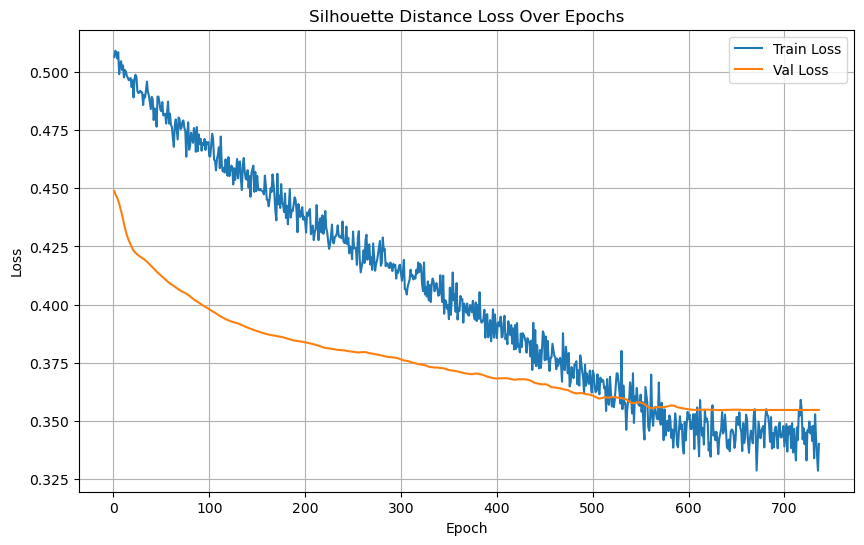

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/158], Loss: 0.3964


Test Batch [20/158], Loss: 0.3621
Test Batch [30/158], Loss: 0.4032


Test Batch [40/158], Loss: 0.3272


Test Batch [50/158], Loss: 0.4502
Test Batch [60/158], Loss: 0.4236


Test Batch [70/158], Loss: 0.1678
Test Batch [80/158], Loss: 0.2416
Test Batch [90/158], Loss: 0.2705
Test Batch [100/158], Loss: 0.2398
Test Batch [110/158], Loss: 0.2321


Test Batch [120/158], Loss: 0.2224
Test Batch [130/158], Loss: 0.5000
Test Batch [140/158], Loss: 0.4116
Test Batch [150/158], Loss: 0.3472



Test Loss: 0.3196


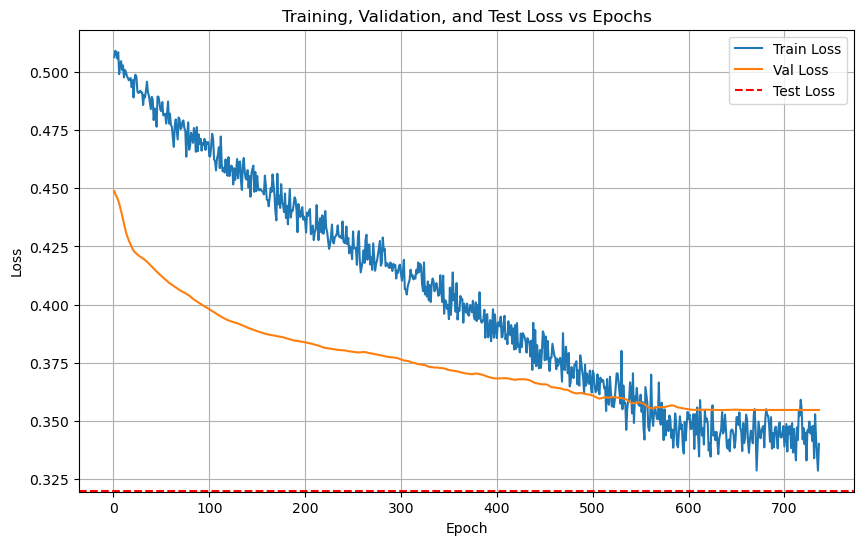

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/158 for test dataset.
  Processed batch 20/158 for test dataset.


  Processed batch 30/158 for test dataset.


  Processed batch 40/158 for test dataset.
  Processed batch 50/158 for test dataset.


  Processed batch 60/158 for test dataset.
  Processed batch 70/158 for test dataset.


  Processed batch 80/158 for test dataset.
  Processed batch 90/158 for test dataset.


  Processed batch 100/158 for test dataset.
  Processed batch 110/158 for test dataset.


  Processed batch 120/158 for test dataset.


  Processed batch 130/158 for test dataset.


  Processed batch 140/158 for test dataset.


  Processed batch 150/158 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 53.75%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.20      0.22         5
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.43      0.60      0.50         5
           4       0.40      0.40      0.40         5
           5       0.25      0.20      0.22         5
           6       0.83      1.00      0.91         5
           7       0.44      0.80      0.57         5
           8       0.71      1.00      0.83         5
           9       0.33      0.40      0.36         5
          10       1.00      0.40      0.57         5
          11       0.25      0.20      0.22         5
          12       0.71      1.00      0.83         5
          13       0.6

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (80, 128)
Train labels shape: (80,)
Val reps shape: (80, 128)
Val labels shape: (80,)
Test reps shape: (10089, 128)
Test labels shape: (10089,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.8200  |  Val Loss: 2.8322
Validation loss improved from inf to 2.8322.
[Epoch 2/1000] Train Loss: 2.8068  |  Val Loss: 2.8241
Validation loss improved from 2.8322 to 2.8241.
[Epoch 3/1000] Train Loss: 2.7939  |  Val Loss: 2.8164
Validation loss improved from 2.8241 to 2.8164.
[Epoch 4/1000] Train Loss: 2.7832  |  Val Loss: 2.8089
Validation loss improved from 2.8164 to 2.8089.
[Epoch 5/1000] Train Loss: 2.7718  |  Val Loss: 2.8018
Validation loss improved from 2.8089 to 2.8018.
[Epoch 6/1000] Train Loss: 2.7605  |  Val Loss: 2.7948
Validation loss improved from 2.8018 to 2.7948.
[Epoch 7/1000] Train Loss: 2.7502  |  Val Loss: 2.7878
Validation loss improved from 2.7948 to 2.7878.
[Epoch 8/1000] Train Loss: 2.7405  |  Val Loss: 2.7811
Validation loss improved from 2.7878 to 2.7811.
[Epoch 9/1000] Train Loss: 2.7303  |  Val Loss: 2.7749
Validation loss improved from 2.7811 to 2.7749.
[Epoch 10/1000] Train Loss: 2.7210  |  Val Loss: 2.7691
Validation loss impr

[Epoch 21/1000] Train Loss: 2.6320  |  Val Loss: 2.7109
Validation loss improved from 2.7162 to 2.7109.
[Epoch 22/1000] Train Loss: 2.6243  |  Val Loss: 2.7059
Validation loss improved from 2.7109 to 2.7059.
[Epoch 23/1000] Train Loss: 2.6171  |  Val Loss: 2.7010
Validation loss improved from 2.7059 to 2.7010.
[Epoch 24/1000] Train Loss: 2.6098  |  Val Loss: 2.6960
Validation loss improved from 2.7010 to 2.6960.
[Epoch 25/1000] Train Loss: 2.6028  |  Val Loss: 2.6912
Validation loss improved from 2.6960 to 2.6912.
[Epoch 26/1000] Train Loss: 2.5956  |  Val Loss: 2.6865
Validation loss improved from 2.6912 to 2.6865.
[Epoch 27/1000] Train Loss: 2.5882  |  Val Loss: 2.6819
Validation loss improved from 2.6865 to 2.6819.
[Epoch 28/1000] Train Loss: 2.5815  |  Val Loss: 2.6772
Validation loss improved from 2.6819 to 2.6772.
[Epoch 29/1000] Train Loss: 2.5741  |  Val Loss: 2.6723
Validation loss improved from 2.6772 to 2.6723.
[Epoch 30/1000] Train Loss: 2.5674  |  Val Loss: 2.6674
Validati

[Epoch 36/1000] Train Loss: 2.5263  |  Val Loss: 2.6398
Validation loss improved from 2.6440 to 2.6398.
[Epoch 37/1000] Train Loss: 2.5196  |  Val Loss: 2.6356
Validation loss improved from 2.6398 to 2.6356.
[Epoch 38/1000] Train Loss: 2.5134  |  Val Loss: 2.6313
Validation loss improved from 2.6356 to 2.6313.
[Epoch 39/1000] Train Loss: 2.5072  |  Val Loss: 2.6271
Validation loss improved from 2.6313 to 2.6271.
[Epoch 40/1000] Train Loss: 2.5007  |  Val Loss: 2.6229
Validation loss improved from 2.6271 to 2.6229.
[Epoch 41/1000] Train Loss: 2.4946  |  Val Loss: 2.6187
Validation loss improved from 2.6229 to 2.6187.
[Epoch 42/1000] Train Loss: 2.4884  |  Val Loss: 2.6146
Validation loss improved from 2.6187 to 2.6146.
[Epoch 43/1000] Train Loss: 2.4821  |  Val Loss: 2.6106
Validation loss improved from 2.6146 to 2.6106.
[Epoch 44/1000] Train Loss: 2.4759  |  Val Loss: 2.6065
Validation loss improved from 2.6106 to 2.6065.
[Epoch 45/1000] Train Loss: 2.4699  |  Val Loss: 2.6025
Validati

[Epoch 66/1000] Train Loss: 2.3449  |  Val Loss: 2.5234
Validation loss improved from 2.5271 to 2.5234.
[Epoch 67/1000] Train Loss: 2.3387  |  Val Loss: 2.5197
Validation loss improved from 2.5234 to 2.5197.
[Epoch 68/1000] Train Loss: 2.3324  |  Val Loss: 2.5160
Validation loss improved from 2.5197 to 2.5160.
[Epoch 69/1000] Train Loss: 2.3264  |  Val Loss: 2.5123
Validation loss improved from 2.5160 to 2.5123.
[Epoch 70/1000] Train Loss: 2.3204  |  Val Loss: 2.5087
Validation loss improved from 2.5123 to 2.5087.
[Epoch 71/1000] Train Loss: 2.3139  |  Val Loss: 2.5050
Validation loss improved from 2.5087 to 2.5050.
[Epoch 72/1000] Train Loss: 2.3077  |  Val Loss: 2.5013
Validation loss improved from 2.5050 to 2.5013.
[Epoch 73/1000] Train Loss: 2.3017  |  Val Loss: 2.4975
Validation loss improved from 2.5013 to 2.4975.
[Epoch 74/1000] Train Loss: 2.2954  |  Val Loss: 2.4936
Validation loss improved from 2.4975 to 2.4936.
[Epoch 75/1000] Train Loss: 2.2893  |  Val Loss: 2.4898
Validati

[Epoch 81/1000] Train Loss: 2.2511  |  Val Loss: 2.4663
Validation loss improved from 2.4702 to 2.4663.
[Epoch 82/1000] Train Loss: 2.2446  |  Val Loss: 2.4622
Validation loss improved from 2.4663 to 2.4622.
[Epoch 83/1000] Train Loss: 2.2386  |  Val Loss: 2.4580
Validation loss improved from 2.4622 to 2.4580.
[Epoch 84/1000] Train Loss: 2.2320  |  Val Loss: 2.4540
Validation loss improved from 2.4580 to 2.4540.
[Epoch 85/1000] Train Loss: 2.2257  |  Val Loss: 2.4500
Validation loss improved from 2.4540 to 2.4500.
[Epoch 86/1000] Train Loss: 2.2195  |  Val Loss: 2.4463
Validation loss improved from 2.4500 to 2.4463.
[Epoch 87/1000] Train Loss: 2.2130  |  Val Loss: 2.4424
Validation loss improved from 2.4463 to 2.4424.
[Epoch 88/1000] Train Loss: 2.2067  |  Val Loss: 2.4385
Validation loss improved from 2.4424 to 2.4385.
[Epoch 89/1000] Train Loss: 2.2003  |  Val Loss: 2.4347
Validation loss improved from 2.4385 to 2.4347.
[Epoch 90/1000] Train Loss: 2.1940  |  Val Loss: 2.4307
Validati

[Epoch 107/1000] Train Loss: 2.0815  |  Val Loss: 2.3627
Validation loss improved from 2.3667 to 2.3627.
[Epoch 108/1000] Train Loss: 2.0749  |  Val Loss: 2.3586
Validation loss improved from 2.3627 to 2.3586.
[Epoch 109/1000] Train Loss: 2.0684  |  Val Loss: 2.3545
Validation loss improved from 2.3586 to 2.3545.
[Epoch 110/1000] Train Loss: 2.0616  |  Val Loss: 2.3502
Validation loss improved from 2.3545 to 2.3502.
[Epoch 111/1000] Train Loss: 2.0550  |  Val Loss: 2.3461
Validation loss improved from 2.3502 to 2.3461.
[Epoch 112/1000] Train Loss: 2.0481  |  Val Loss: 2.3421
Validation loss improved from 2.3461 to 2.3421.
[Epoch 113/1000] Train Loss: 2.0413  |  Val Loss: 2.3380
Validation loss improved from 2.3421 to 2.3380.
[Epoch 114/1000] Train Loss: 2.0346  |  Val Loss: 2.3337
Validation loss improved from 2.3380 to 2.3337.
[Epoch 115/1000] Train Loss: 2.0277  |  Val Loss: 2.3292
Validation loss improved from 2.3337 to 2.3292.
[Epoch 116/1000] Train Loss: 2.0211  |  Val Loss: 2.324

[Epoch 119/1000] Train Loss: 2.0007  |  Val Loss: 2.3117
Validation loss improved from 2.3159 to 2.3117.
[Epoch 120/1000] Train Loss: 1.9939  |  Val Loss: 2.3071
Validation loss improved from 2.3117 to 2.3071.
[Epoch 121/1000] Train Loss: 1.9871  |  Val Loss: 2.3027
Validation loss improved from 2.3071 to 2.3027.
[Epoch 122/1000] Train Loss: 1.9802  |  Val Loss: 2.2983
Validation loss improved from 2.3027 to 2.2983.
[Epoch 123/1000] Train Loss: 1.9734  |  Val Loss: 2.2940
Validation loss improved from 2.2983 to 2.2940.
[Epoch 124/1000] Train Loss: 1.9663  |  Val Loss: 2.2897
Validation loss improved from 2.2940 to 2.2897.
[Epoch 125/1000] Train Loss: 1.9594  |  Val Loss: 2.2853
Validation loss improved from 2.2897 to 2.2853.
[Epoch 126/1000] Train Loss: 1.9523  |  Val Loss: 2.2808
Validation loss improved from 2.2853 to 2.2808.
[Epoch 127/1000] Train Loss: 1.9454  |  Val Loss: 2.2764
Validation loss improved from 2.2808 to 2.2764.
[Epoch 128/1000] Train Loss: 1.9382  |  Val Loss: 2.272

[Epoch 144/1000] Train Loss: 1.8189  |  Val Loss: 2.1935
Validation loss improved from 2.1993 to 2.1935.
[Epoch 145/1000] Train Loss: 1.8111  |  Val Loss: 2.1880
Validation loss improved from 2.1935 to 2.1880.
[Epoch 146/1000] Train Loss: 1.8033  |  Val Loss: 2.1826
Validation loss improved from 2.1880 to 2.1826.
[Epoch 147/1000] Train Loss: 1.7957  |  Val Loss: 2.1769
Validation loss improved from 2.1826 to 2.1769.
[Epoch 148/1000] Train Loss: 1.7881  |  Val Loss: 2.1712
Validation loss improved from 2.1769 to 2.1712.
[Epoch 149/1000] Train Loss: 1.7807  |  Val Loss: 2.1656
Validation loss improved from 2.1712 to 2.1656.
[Epoch 150/1000] Train Loss: 1.7731  |  Val Loss: 2.1603
Validation loss improved from 2.1656 to 2.1603.
[Epoch 151/1000] Train Loss: 1.7653  |  Val Loss: 2.1550
Validation loss improved from 2.1603 to 2.1550.
[Epoch 152/1000] Train Loss: 1.7580  |  Val Loss: 2.1499
Validation loss improved from 2.1550 to 2.1499.
[Epoch 153/1000] Train Loss: 1.7504  |  Val Loss: 2.145

[Epoch 163/1000] Train Loss: 1.6744  |  Val Loss: 2.1000
Validation loss improved from 2.1046 to 2.1000.
[Epoch 164/1000] Train Loss: 1.6665  |  Val Loss: 2.0956
Validation loss improved from 2.1000 to 2.0956.
[Epoch 165/1000] Train Loss: 1.6587  |  Val Loss: 2.0909
Validation loss improved from 2.0956 to 2.0909.
[Epoch 166/1000] Train Loss: 1.6507  |  Val Loss: 2.0859
Validation loss improved from 2.0909 to 2.0859.
[Epoch 167/1000] Train Loss: 1.6428  |  Val Loss: 2.0810
Validation loss improved from 2.0859 to 2.0810.
[Epoch 168/1000] Train Loss: 1.6348  |  Val Loss: 2.0764
Validation loss improved from 2.0810 to 2.0764.
[Epoch 169/1000] Train Loss: 1.6270  |  Val Loss: 2.0719
Validation loss improved from 2.0764 to 2.0719.
[Epoch 170/1000] Train Loss: 1.6190  |  Val Loss: 2.0673
Validation loss improved from 2.0719 to 2.0673.
[Epoch 171/1000] Train Loss: 1.6113  |  Val Loss: 2.0628
Validation loss improved from 2.0673 to 2.0628.
[Epoch 172/1000] Train Loss: 1.6034  |  Val Loss: 2.058

[Epoch 185/1000] Train Loss: 1.5029  |  Val Loss: 1.9990
Validation loss improved from 2.0029 to 1.9990.
[Epoch 186/1000] Train Loss: 1.4950  |  Val Loss: 1.9950
Validation loss improved from 1.9990 to 1.9950.
[Epoch 187/1000] Train Loss: 1.4873  |  Val Loss: 1.9904
Validation loss improved from 1.9950 to 1.9904.
[Epoch 188/1000] Train Loss: 1.4795  |  Val Loss: 1.9856
Validation loss improved from 1.9904 to 1.9856.
[Epoch 189/1000] Train Loss: 1.4723  |  Val Loss: 1.9809
Validation loss improved from 1.9856 to 1.9809.
[Epoch 190/1000] Train Loss: 1.4646  |  Val Loss: 1.9764
Validation loss improved from 1.9809 to 1.9764.
[Epoch 191/1000] Train Loss: 1.4573  |  Val Loss: 1.9720
Validation loss improved from 1.9764 to 1.9720.
[Epoch 192/1000] Train Loss: 1.4499  |  Val Loss: 1.9678
Validation loss improved from 1.9720 to 1.9678.
[Epoch 193/1000] Train Loss: 1.4426  |  Val Loss: 1.9638
Validation loss improved from 1.9678 to 1.9638.
[Epoch 194/1000] Train Loss: 1.4352  |  Val Loss: 1.960

[Epoch 205/1000] Train Loss: 1.3525  |  Val Loss: 1.9182
Validation loss improved from 1.9229 to 1.9182.
[Epoch 206/1000] Train Loss: 1.3450  |  Val Loss: 1.9138
Validation loss improved from 1.9182 to 1.9138.
[Epoch 207/1000] Train Loss: 1.3373  |  Val Loss: 1.9098
Validation loss improved from 1.9138 to 1.9098.
[Epoch 208/1000] Train Loss: 1.3296  |  Val Loss: 1.9064
Validation loss improved from 1.9098 to 1.9064.
[Epoch 209/1000] Train Loss: 1.3220  |  Val Loss: 1.9035
Validation loss improved from 1.9064 to 1.9035.
[Epoch 210/1000] Train Loss: 1.3148  |  Val Loss: 1.9008
Validation loss improved from 1.9035 to 1.9008.
[Epoch 211/1000] Train Loss: 1.3070  |  Val Loss: 1.8980
Validation loss improved from 1.9008 to 1.8980.
[Epoch 212/1000] Train Loss: 1.2995  |  Val Loss: 1.8955
Validation loss improved from 1.8980 to 1.8955.
[Epoch 213/1000] Train Loss: 1.2921  |  Val Loss: 1.8931
Validation loss improved from 1.8955 to 1.8931.
[Epoch 214/1000] Train Loss: 1.2847  |  Val Loss: 1.890

[Epoch 227/1000] Train Loss: 1.1903  |  Val Loss: 1.8498
Validation loss improved from 1.8525 to 1.8498.
[Epoch 228/1000] Train Loss: 1.1832  |  Val Loss: 1.8473
Validation loss improved from 1.8498 to 1.8473.
[Epoch 229/1000] Train Loss: 1.1762  |  Val Loss: 1.8449
Validation loss improved from 1.8473 to 1.8449.
[Epoch 230/1000] Train Loss: 1.1691  |  Val Loss: 1.8426
Validation loss improved from 1.8449 to 1.8426.
[Epoch 231/1000] Train Loss: 1.1624  |  Val Loss: 1.8403
Validation loss improved from 1.8426 to 1.8403.
[Epoch 232/1000] Train Loss: 1.1553  |  Val Loss: 1.8381
Validation loss improved from 1.8403 to 1.8381.
[Epoch 233/1000] Train Loss: 1.1486  |  Val Loss: 1.8357
Validation loss improved from 1.8381 to 1.8357.
[Epoch 234/1000] Train Loss: 1.1418  |  Val Loss: 1.8332
Validation loss improved from 1.8357 to 1.8332.
[Epoch 235/1000] Train Loss: 1.1349  |  Val Loss: 1.8311
Validation loss improved from 1.8332 to 1.8311.
[Epoch 236/1000] Train Loss: 1.1281  |  Val Loss: 1.829

[Epoch 247/1000] Train Loss: 1.0533  |  Val Loss: 1.7943
Validation loss improved from 1.7980 to 1.7943.
[Epoch 248/1000] Train Loss: 1.0465  |  Val Loss: 1.7905
Validation loss improved from 1.7943 to 1.7905.
[Epoch 249/1000] Train Loss: 1.0400  |  Val Loss: 1.7868
Validation loss improved from 1.7905 to 1.7868.
[Epoch 250/1000] Train Loss: 1.0331  |  Val Loss: 1.7834
Validation loss improved from 1.7868 to 1.7834.
[Epoch 251/1000] Train Loss: 1.0265  |  Val Loss: 1.7801
Validation loss improved from 1.7834 to 1.7801.
[Epoch 252/1000] Train Loss: 1.0194  |  Val Loss: 1.7761
Validation loss improved from 1.7801 to 1.7761.
[Epoch 253/1000] Train Loss: 1.0133  |  Val Loss: 1.7716
Validation loss improved from 1.7761 to 1.7716.
[Epoch 254/1000] Train Loss: 1.0061  |  Val Loss: 1.7675
Validation loss improved from 1.7716 to 1.7675.
[Epoch 255/1000] Train Loss: 0.9994  |  Val Loss: 1.7630
Validation loss improved from 1.7675 to 1.7630.
[Epoch 256/1000] Train Loss: 0.9926  |  Val Loss: 1.758

[Epoch 267/1000] Train Loss: 0.9206  |  Val Loss: 1.7273
Validation loss improved from 1.7294 to 1.7273.
[Epoch 268/1000] Train Loss: 0.9141  |  Val Loss: 1.7253
Validation loss improved from 1.7273 to 1.7253.
[Epoch 269/1000] Train Loss: 0.9075  |  Val Loss: 1.7228
Validation loss improved from 1.7253 to 1.7228.
[Epoch 270/1000] Train Loss: 0.9008  |  Val Loss: 1.7202
Validation loss improved from 1.7228 to 1.7202.
[Epoch 271/1000] Train Loss: 0.8946  |  Val Loss: 1.7179
Validation loss improved from 1.7202 to 1.7179.
[Epoch 272/1000] Train Loss: 0.8883  |  Val Loss: 1.7158
Validation loss improved from 1.7179 to 1.7158.
[Epoch 273/1000] Train Loss: 0.8820  |  Val Loss: 1.7140
Validation loss improved from 1.7158 to 1.7140.
[Epoch 274/1000] Train Loss: 0.8757  |  Val Loss: 1.7123
Validation loss improved from 1.7140 to 1.7123.
[Epoch 275/1000] Train Loss: 0.8695  |  Val Loss: 1.7104
Validation loss improved from 1.7123 to 1.7104.
[Epoch 276/1000] Train Loss: 0.8632  |  Val Loss: 1.708

[Epoch 289/1000] Train Loss: 0.7867  |  Val Loss: 1.6792
Validation loss improved from 1.6817 to 1.6792.
[Epoch 290/1000] Train Loss: 0.7817  |  Val Loss: 1.6767
Validation loss improved from 1.6792 to 1.6767.
[Epoch 291/1000] Train Loss: 0.7760  |  Val Loss: 1.6746
Validation loss improved from 1.6767 to 1.6746.
[Epoch 292/1000] Train Loss: 0.7706  |  Val Loss: 1.6727
Validation loss improved from 1.6746 to 1.6727.
[Epoch 293/1000] Train Loss: 0.7650  |  Val Loss: 1.6712
Validation loss improved from 1.6727 to 1.6712.
[Epoch 294/1000] Train Loss: 0.7595  |  Val Loss: 1.6698
Validation loss improved from 1.6712 to 1.6698.
[Epoch 295/1000] Train Loss: 0.7541  |  Val Loss: 1.6685
Validation loss improved from 1.6698 to 1.6685.
[Epoch 296/1000] Train Loss: 0.7486  |  Val Loss: 1.6676
Validation loss improved from 1.6685 to 1.6676.
[Epoch 297/1000] Train Loss: 0.7433  |  Val Loss: 1.6670
Validation loss improved from 1.6676 to 1.6670.
[Epoch 298/1000] Train Loss: 0.7379  |  Val Loss: 1.666

[Epoch 310/1000] Train Loss: 0.6788  |  Val Loss: 1.6662
Validation loss improved from 1.6662 to 1.6662.
[Epoch 311/1000] Train Loss: 0.6740  |  Val Loss: 1.6663
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 312/1000] Train Loss: 0.6695  |  Val Loss: 1.6665
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 313/1000] Train Loss: 0.6648  |  Val Loss: 1.6664
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 314/1000] Train Loss: 0.6604  |  Val Loss: 1.6660
Validation loss improved from 1.6662 to 1.6660.
[Epoch 315/1000] Train Loss: 0.6557  |  Val Loss: 1.6655
Validation loss improved from 1.6660 to 1.6655.
[Epoch 316/1000] Train Loss: 0.6512  |  Val Loss: 1.6644
Validation loss improved from 1.6655 to 1.6644.
[Epoch 317/1000] Train Loss: 0.6465  |  Val Loss: 1.6622
Validation loss improved from 1.6644 to 1.6622.
[Epoch 318/1000] Train Loss: 0.6418  |  Val Loss: 1.6602
Validation loss improved from 1.6622 to 1.6602.
[Epoch 319/1000] Train Loss: 0.6372  

[Epoch 330/1000] Train Loss: 0.5895  |  Val Loss: 1.6385
Validation loss improved from 1.6403 to 1.6385.
[Epoch 331/1000] Train Loss: 0.5854  |  Val Loss: 1.6369
Validation loss improved from 1.6385 to 1.6369.
[Epoch 332/1000] Train Loss: 0.5815  |  Val Loss: 1.6352
Validation loss improved from 1.6369 to 1.6352.
[Epoch 333/1000] Train Loss: 0.5773  |  Val Loss: 1.6343
Validation loss improved from 1.6352 to 1.6343.
[Epoch 334/1000] Train Loss: 0.5733  |  Val Loss: 1.6339
Validation loss improved from 1.6343 to 1.6339.
[Epoch 335/1000] Train Loss: 0.5695  |  Val Loss: 1.6336
Validation loss improved from 1.6339 to 1.6336.
[Epoch 336/1000] Train Loss: 0.5658  |  Val Loss: 1.6331
Validation loss improved from 1.6336 to 1.6331.
[Epoch 337/1000] Train Loss: 0.5619  |  Val Loss: 1.6326
Validation loss improved from 1.6331 to 1.6326.
[Epoch 338/1000] Train Loss: 0.5581  |  Val Loss: 1.6320
Validation loss improved from 1.6326 to 1.6320.
[Epoch 339/1000] Train Loss: 0.5545  |  Val Loss: 1.631

[Epoch 354/1000] Train Loss: 0.5018  |  Val Loss: 1.6239
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 355/1000] Train Loss: 0.4985  |  Val Loss: 1.6238
Validation loss improved from 1.6238 to 1.6238.
[Epoch 356/1000] Train Loss: 0.4952  |  Val Loss: 1.6234
Validation loss improved from 1.6238 to 1.6234.
[Epoch 357/1000] Train Loss: 0.4920  |  Val Loss: 1.6233
Validation loss improved from 1.6234 to 1.6233.
[Epoch 358/1000] Train Loss: 0.4887  |  Val Loss: 1.6236
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 359/1000] Train Loss: 0.4857  |  Val Loss: 1.6241
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 360/1000] Train Loss: 0.4826  |  Val Loss: 1.6250
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 361/1000] Train Loss: 0.4795  |  Val Loss: 1.6260
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 362/1000] Train Loss: 0.4762  |  Val Loss: 1.6270
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 363/1000] Tr

[Epoch 372/1000] Train Loss: 0.4470  |  Val Loss: 1.6371
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 373/1000] Train Loss: 0.4441  |  Val Loss: 1.6371
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 374/1000] Train Loss: 0.4414  |  Val Loss: 1.6369
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 375/1000] Train Loss: 0.4386  |  Val Loss: 1.6368
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 376/1000] Train Loss: 0.4360  |  Val Loss: 1.6369
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 377/1000] Train Loss: 0.4332  |  Val Loss: 1.6364
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 378/1000] Train Loss: 0.4305  |  Val Loss: 1.6352
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 379/1000] Train Loss: 0.4278  |  Val Loss: 1.6343
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 380/1000] Train Loss: 0.4251  |  Val Loss: 1.6335
!! Validation loss did NOT improve !! Patience:

[Epoch 394/1000] Train Loss: 0.3909  |  Val Loss: 1.6317
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 395/1000] Train Loss: 0.3885  |  Val Loss: 1.6327
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 396/1000] Train Loss: 0.3864  |  Val Loss: 1.6333
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 397/1000] Train Loss: 0.3839  |  Val Loss: 1.6334
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 398/1000] Train Loss: 0.3816  |  Val Loss: 1.6336
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 399/1000] Train Loss: 0.3793  |  Val Loss: 1.6338
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 400/1000] Train Loss: 0.3772  |  Val Loss: 1.6340
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 401/1000] Train Loss: 0.3751  |  Val Loss: 1.6347
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 402/1000] Train Loss: 0.3728  |  Val Loss: 1.6354
!! Validation loss did NOT improve !! Patience:

[Epoch 411/1000] Train Loss: 0.3545  |  Val Loss: 1.6478
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 412/1000] Train Loss: 0.3527  |  Val Loss: 1.6498
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 413/1000] Train Loss: 0.3508  |  Val Loss: 1.6521
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 414/1000] Train Loss: 0.3490  |  Val Loss: 1.6540
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 415/1000] Train Loss: 0.3471  |  Val Loss: 1.6558
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 416/1000] Train Loss: 0.3453  |  Val Loss: 1.6576
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 417/1000] Train Loss: 0.3434  |  Val Loss: 1.6592
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 418/1000] Train Loss: 0.3417  |  Val Loss: 1.6609
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 419/1000] Train Loss: 0.3400  |  Val Loss: 1.6625
!! Validation loss did NOT improve !! Patience:

[Epoch 432/1000] Train Loss: 0.3177  |  Val Loss: 1.6692
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 433/1000] Train Loss: 0.3161  |  Val Loss: 1.6697
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 434/1000] Train Loss: 0.3144  |  Val Loss: 1.6689
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 435/1000] Train Loss: 0.3128  |  Val Loss: 1.6682
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 436/1000] Train Loss: 0.3111  |  Val Loss: 1.6680
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 437/1000] Train Loss: 0.3095  |  Val Loss: 1.6681
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 438/1000] Train Loss: 0.3078  |  Val Loss: 1.6684
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 439/1000] Train Loss: 0.3063  |  Val Loss: 1.6691
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 440/1000] Train Loss: 0.3047  |  Val Loss: 1.6698
!! Validation loss did NOT improve !! Patience:

[Epoch 453/1000] Train Loss: 0.2859  |  Val Loss: 1.6758
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 454/1000] Train Loss: 0.2845  |  Val Loss: 1.6775
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 455/1000] Train Loss: 0.2830  |  Val Loss: 1.6795
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 456/1000] Train Loss: 0.2816  |  Val Loss: 1.6819
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 457/1000] Train Loss: 0.2803  |  Val Loss: 1.6841
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 457 !!
No improvement for 100 epochs.


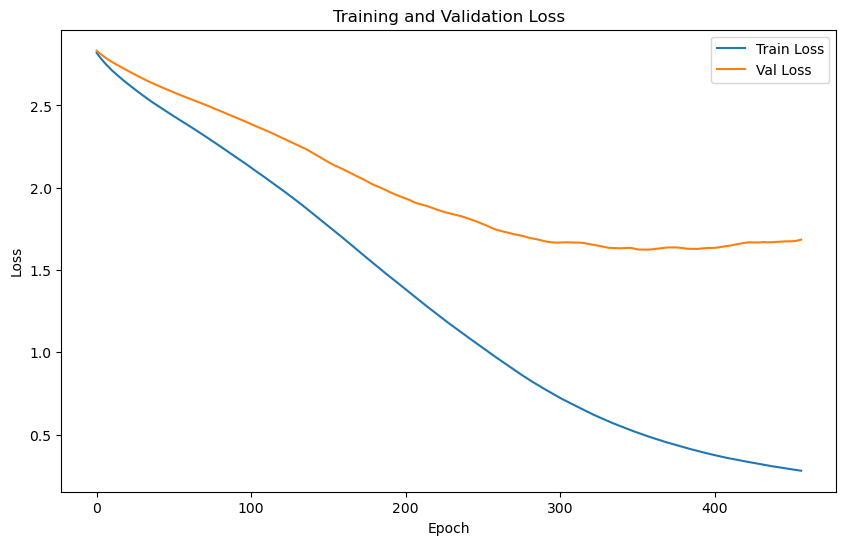

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.6026 | Test Accuracy: 43.88%


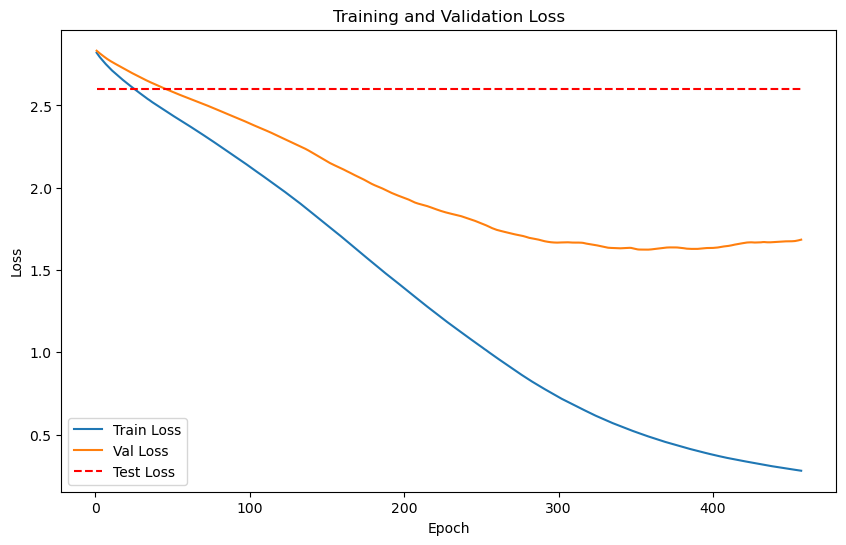

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


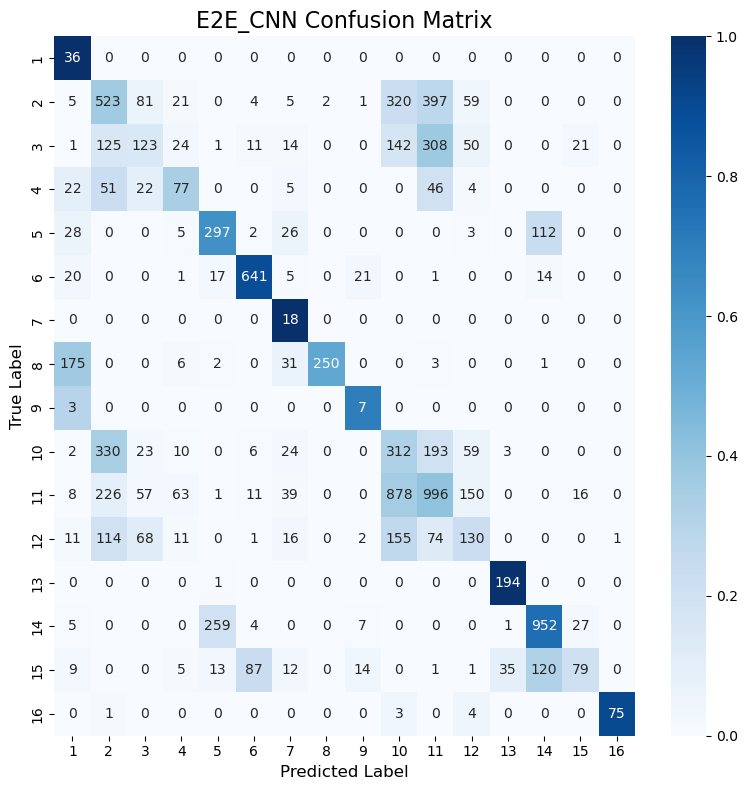

Classification Accuracy: 46.68%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


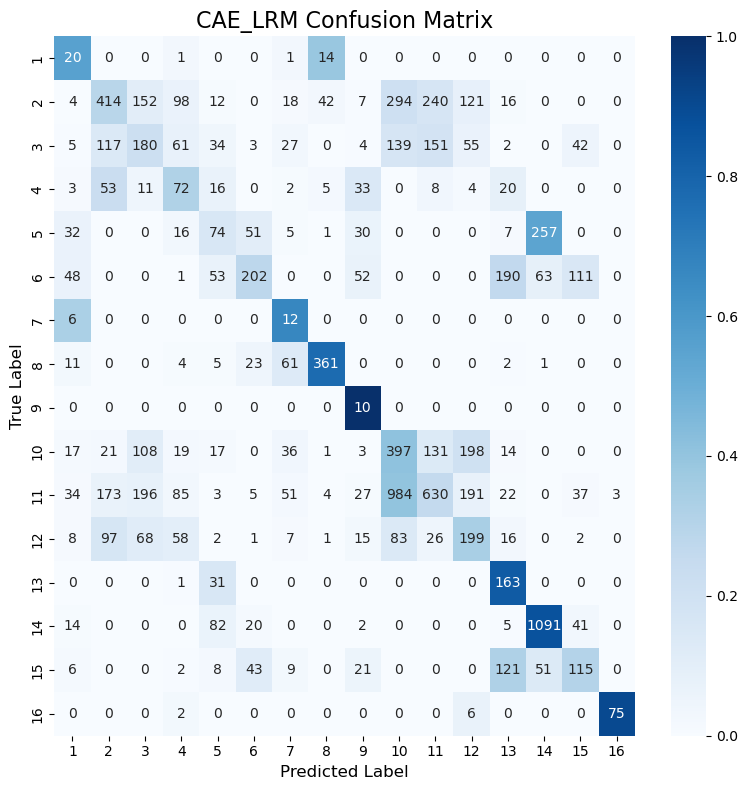

Classification Accuracy: 39.80%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


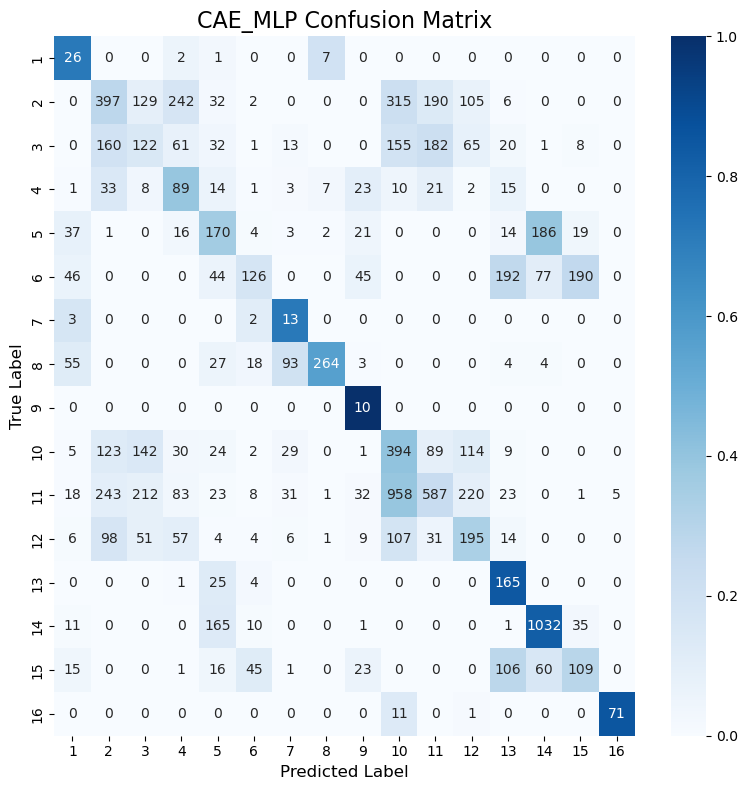

Classification Accuracy: 37.37%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


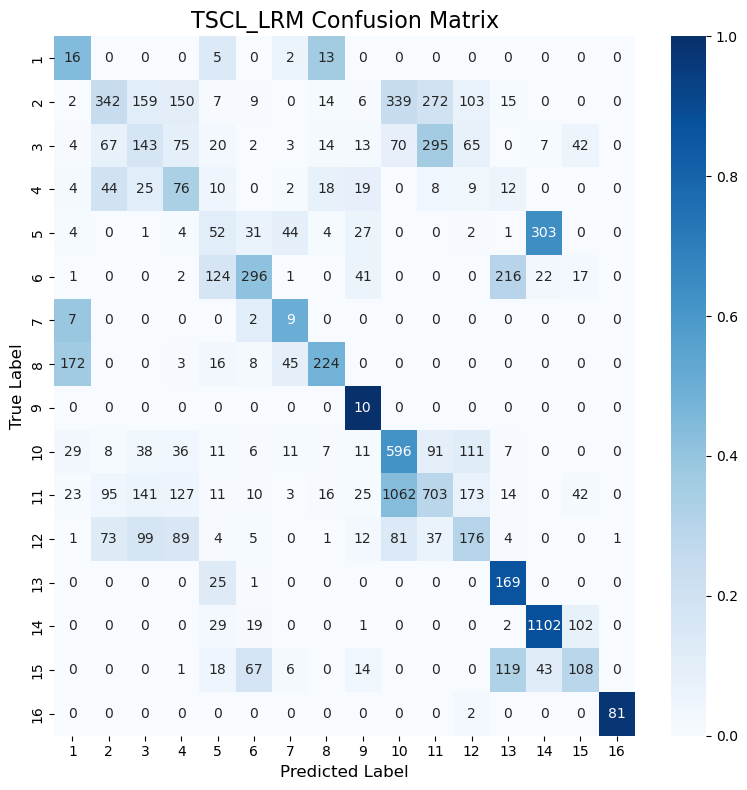

Classification Accuracy: 40.67%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


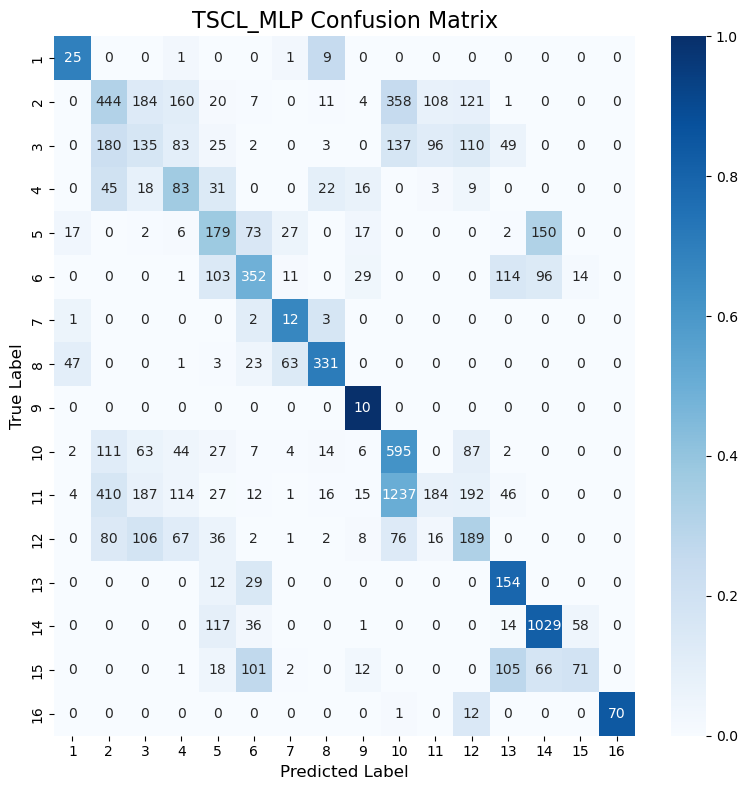

Classification Accuracy: 38.29%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


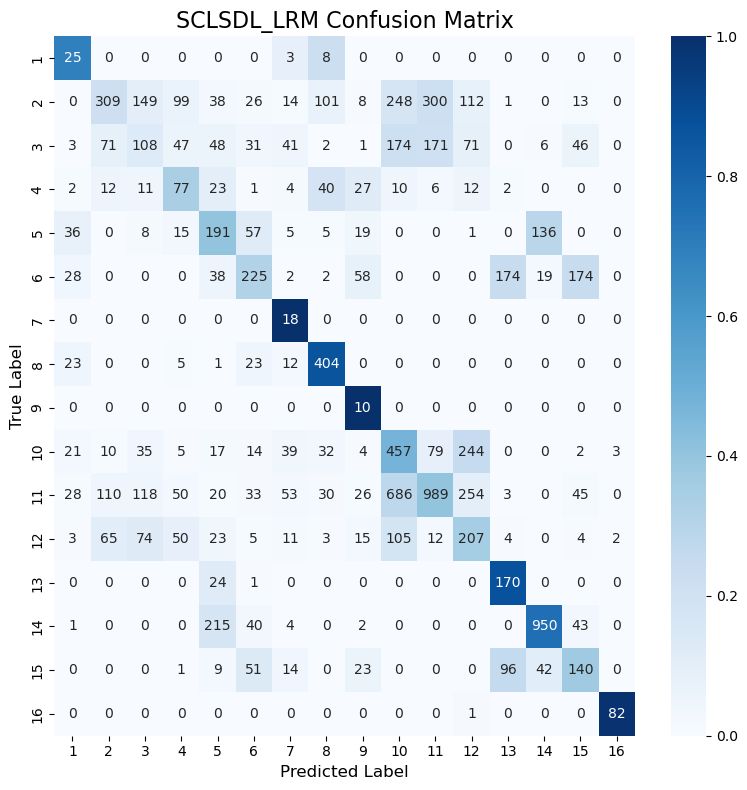

Classification Accuracy: 43.24%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


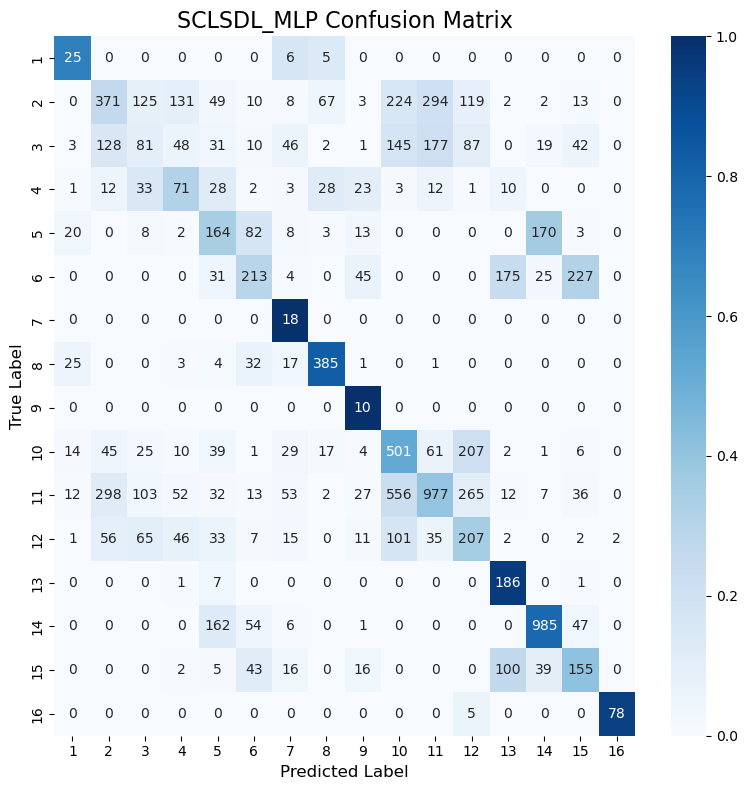

Classification Accuracy: 43.88%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          46.68
1    LRM (CAE)          39.80
2    MLP (CAE)          37.37
3     TSCL LRM          40.67
4     TSCL MLP          38.29
5  SCL_SDL LRM          43.24
6  SCL_SDL MLP          43.88

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          46.68
6  SCL_SDL MLP          43.88
5  SCL_SDL LRM          43.24
3     TSCL LRM          40.67
1    LRM (CAE)          39.80
4     TSCL MLP          38.29
2    MLP (CAE)          37.37
